# Analysis Comparing Clusters

## Imports + Dataset Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import collections
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, silhouette_score, v_measure_score, silhouette_samples, jaccard_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import math
import umap.plot
import umap.umap_ as umap_
from kneed import KneeLocator
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import json

### Data Setup

In [2]:
DATA_DIR_PATH = '/Users/cindywang/PycharmProjects/bpd-subtyping/data/'
CDATA_DIR_PATH = DATA_DIR_PATH + 'processed/clusters/'
VDATA_DIR_PATH = DATA_DIR_PATH + 'processed/vector/'
RDATA_DIR_PATH = DATA_DIR_PATH + 'processed/risk/'

In [3]:
# importing in important datasets
ds_df = pd.read_csv(DATA_DIR_PATH + 'daily_support.csv')  # daily support dataframe
dm_df = pd.read_csv(DATA_DIR_PATH + 'daily_medications.csv')  # daily medications dataframe
# dp_df = pd.read_csv(DATA_DIR_PATH + 'daily_procedures.csv')  # daily procedures dataframe
pf_df = pd.read_csv(DATA_DIR_PATH + 'patient_facts.csv')  # patient facts dataframe

In [30]:
pf_df['GestAge'].value_counts()

31    20183
30    15489
29    11576
28     9944
27     7837
26     6291
25     5281
24     4524
23     2628
Name: GestAge, dtype: int64

In [34]:
pf_df.shape[0]-20183

63570

In [31]:
pf_df.merge(pd.read_csv(DATA_DIR_PATH + 'patient_manifest.csv'))['GestAge'].value_counts()

30    15329
29    11413
28     9720
27     7593
26     6033
25     5014
24     4285
23     2518
Name: GestAge, dtype: int64

In [32]:
pd.read_csv(DATA_DIR_PATH + 'patient_manifest.csv').shape

(61905, 1)

In [19]:
dw_df = pd.read_csv(DATA_DIR_PATH + 'daily_weight.csv')

In [22]:
ds_df.head()

PatientSeqID  DSB   PMA  SupportType  SupportMax
0     5232405.0  0.0  28.0          3.0         NaN
1     5232405.0  5.0  28.7          3.0        0.25
2     5232405.0  6.0  28.9          2.0        0.25
3     5232405.0  7.0  29.0          2.0        0.25
4     5232405.0  8.0  29.1          2.0        0.25

In [23]:
dw_df.head()

PatientSeqID  Daily_DSB   PMA  Weight
0       5399406       48.0  31.9   1.355
1       5399406       22.0  28.1   0.900
2       5399406       44.0  31.3   1.190
3       5399406        3.0  25.4   0.810
4       5399406       42.0  31.0   1.210

In [24]:
ds_df.merge(dw_df)

PatientSeqID   DSB   PMA  SupportType  SupportMax  Daily_DSB  Weight
0           5232405.0   0.0  28.0          3.0         NaN        0.0   1.053
1           5232405.0   5.0  28.7          3.0        0.25        5.0   0.950
2           5232405.0   6.0  28.9          2.0        0.25        6.0   0.980
3           5232405.0   7.0  29.0          2.0        0.25        7.0   0.990
4           5232405.0   8.0  29.1          2.0        0.25        8.0   1.010
...               ...   ...   ...          ...         ...        ...     ...
4759522     6561095.0  40.0  36.7          0.0        0.21       40.0   2.515
4759523     6561095.0  41.0  36.9          0.0        0.21       41.0   2.565
4759524     6561095.0  42.0  37.0          0.0        0.21       42.0   2.600
4759525     6561095.0  43.0  37.1          0.0        0.21       43.0   2.600
4759526     6561095.0  44.0  37.3          0.0        0.21       44.0   2.650

[4759527 rows x 7 columns]

In [25]:
dw_df.head()
list(dw_df['Daily_DSB'].value_counts())

[82414,
 77602,
 77554,
 77364,
 77342,
 77219,
 77150,
 77090,
 77012,
 76928,
 76772,
 76705,
 76538,
 76495,
 76445,
 76394,
 76183,
 76139,
 75980,
 75498,
 75193,
 74529,
 74065,
 73900,
 73308,
 72955,
 72546,
 71630,
 70776,
 69990,
 69674,
 68706,
 67494,
 66228,
 64904,
 63615,
 62233,
 60900,
 59465,
 58081,
 56630,
 55178,
 53777,
 52428,
 51050,
 49729,
 48277,
 47009,
 45713,
 44354,
 43048,
 41835,
 40624,
 39377,
 38288,
 37214,
 36157,
 35153,
 34162,
 33186,
 32271,
 31416,
 30568,
 29777,
 28960,
 28174,
 27389,
 26541,
 25744,
 24912,
 24178,
 23408,
 22656,
 21989,
 21253,
 20554,
 19889,
 19312,
 18678,
 17993,
 17451,
 16895,
 16368,
 15816,
 15344,
 14804,
 14290,
 13834,
 13338,
 12862,
 12441,
 12023,
 11617,
 11200,
 10850,
 10429,
 10096,
 9722,
 9377,
 8996,
 8660,
 8332,
 8012,
 7710,
 7404,
 7099,
 6811,
 6510,
 6288,
 6050,
 5806,
 5564,
 5330,
 5105,
 4898,
 4709,
 4512,
 4346,
 4150,
 3995,
 3834,
 3654,
 3481,
 3358,
 3243,
 3129,
 3005,
 2871,
 2729,


In [5]:
clusters = ['lr_d1g0_', 'lr_d1g1_', 'lr_d1g2_', 'lr_d1g3_', 'lr_d1g4_',
              'lr_d3g0_', 'lr_d3g1_', 'lr_d3g2_', 'lr_d3g3_', 'lr_d3g4_',
              'lr_d7g0_', 'lr_d7g1_', 'lr_d7g2_', 'lr_d7g3_', 'lr_d7g4_',
              'lr_d14g0_', 'lr_d14g1_', 'lr_d14g2_', 'lr_d14g3_', 'lr_d14g4_',
              'lr_d21g0_', 'lr_d21g1_', 'lr_d21g2_', 'lr_d21g3_', 'lr_d21g4_',
              'lr_d27g0_', 'lr_d27g1_', 'lr_d27g2_', 'lr_d27g3_', 'lr_d27g4_']
f_clusters = ['lr_1_', 'lr_3_', 'lr_7_', 'lr_14_', 'lr_21_', 'lr_27_']

In [12]:
mf_df = pd.read_csv(DATA_DIR_PATH + 'maternal_facts.csv')  # patient facts dataframe
dis_df = pd.read_csv(DATA_DIR_PATH + 'discharge_bpd_status.csv')  # bpd grade df

In [8]:
pal = sns.color_palette('colorblind')
colors = pal.as_hex()
print(colors)
new_pal = ['#0173b2', '#de8f05', '#029e73', '#ece133']
colors

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

lr_1_


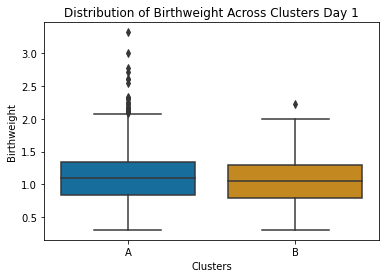

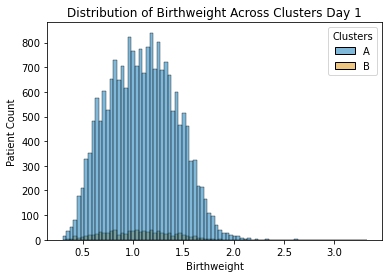

             Mean        SD
Cluster                    
A        1.091684  0.334348
B        1.050143  0.332337


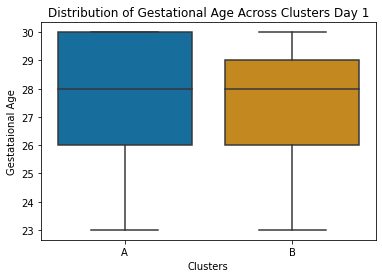

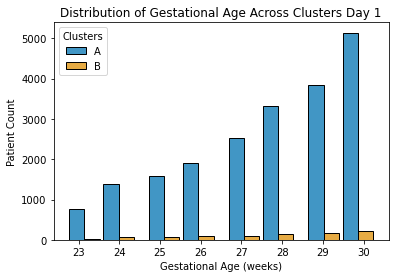

              Mean        SD
Cluster                     
A        27.690135  2.075305
B        27.630459  2.086700


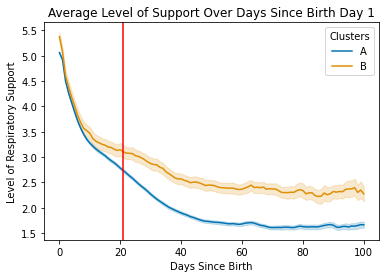

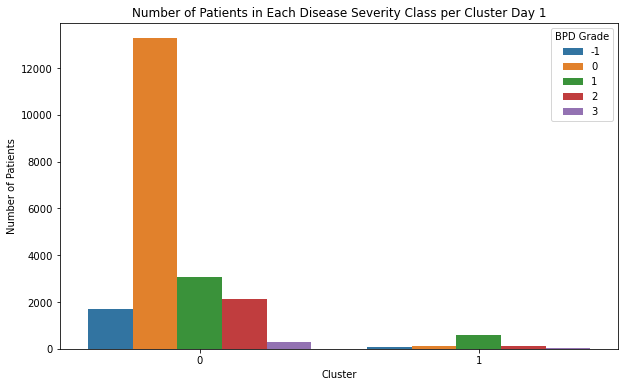

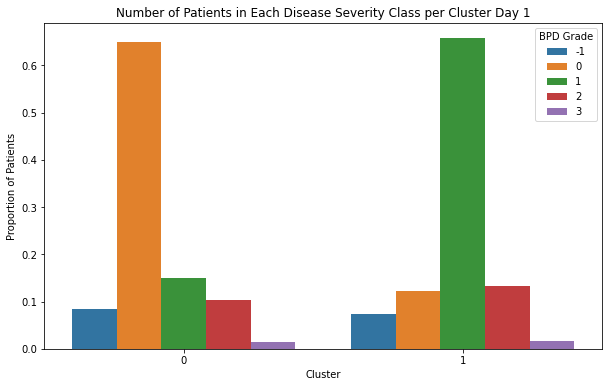

lr_3_


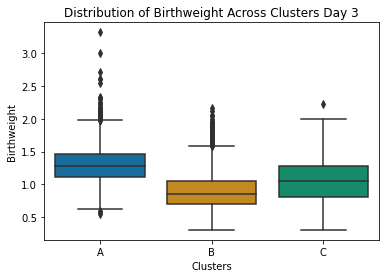

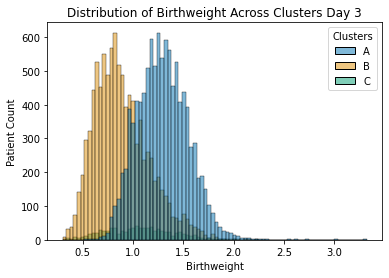

             Mean        SD
Cluster                    
A        1.296673  0.249429
B        0.888804  0.273085
C        1.057687  0.320967


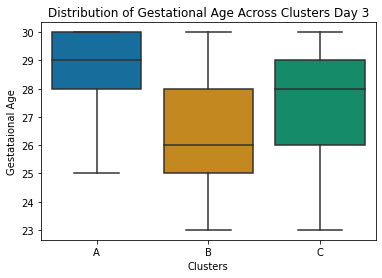

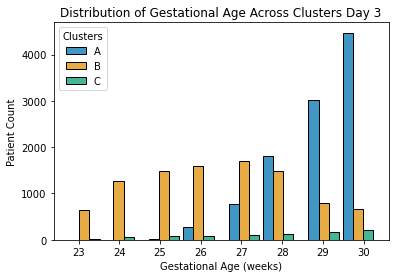

              Mean        SD
Cluster                     
A        29.022317  1.081234
B        26.394226  1.938060
C        27.715651  1.999499


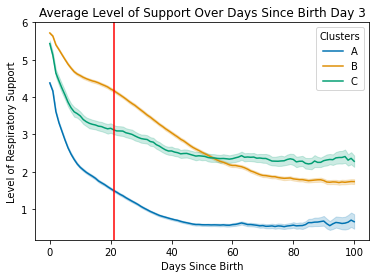

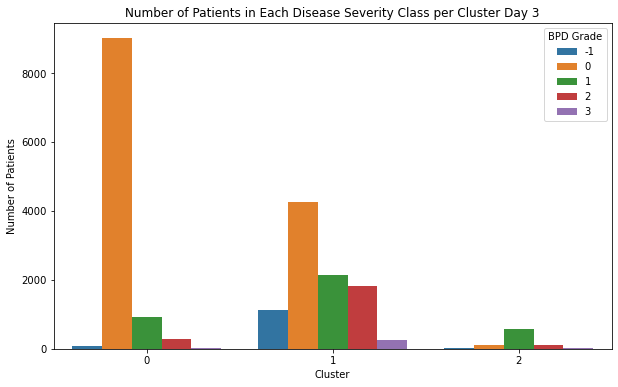

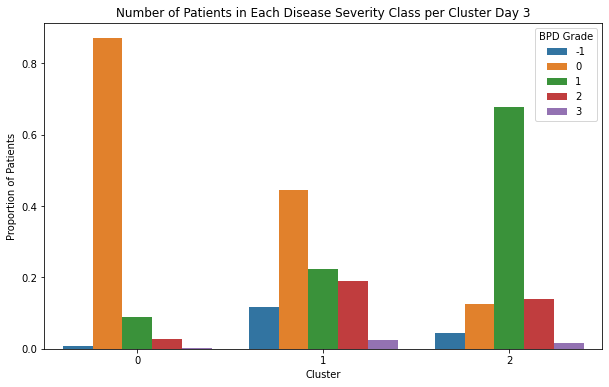

lr_7_


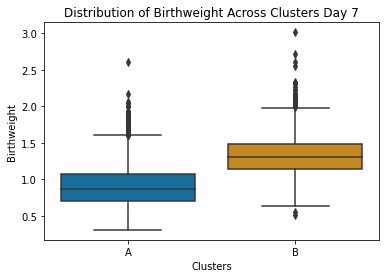

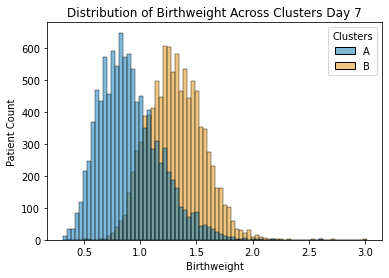

             Mean        SD
Cluster                    
A        0.905369  0.268095
B        1.314464  0.243150


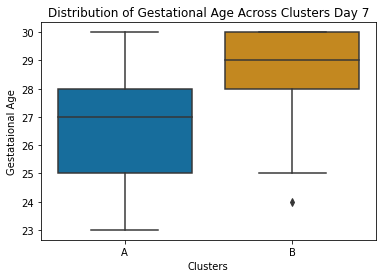

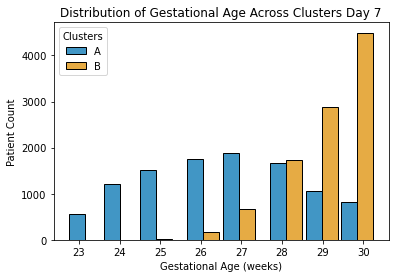

              Mean        SD
Cluster                     
A        26.578932  1.937297
B        29.085580  1.029088


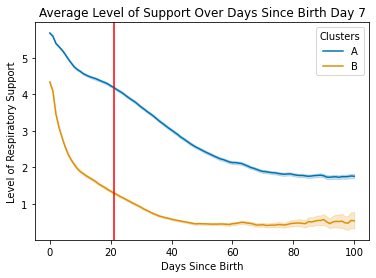

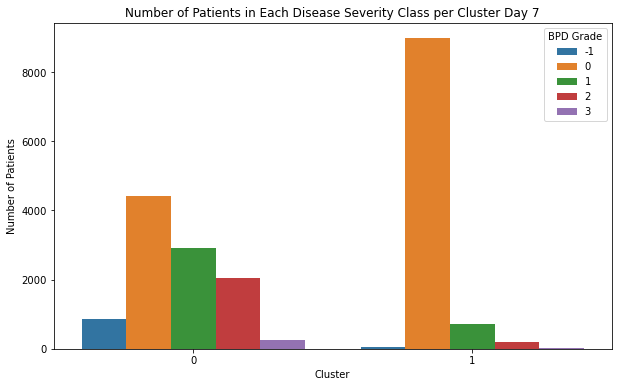

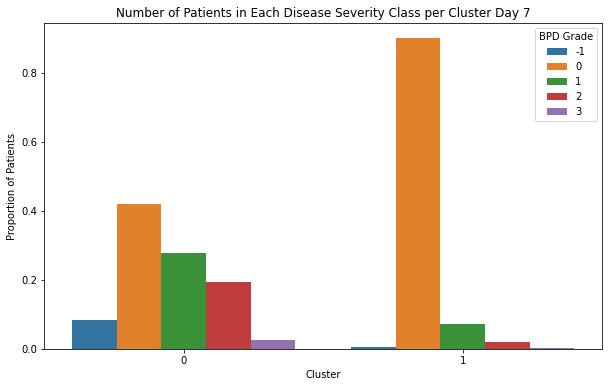

lr_14_


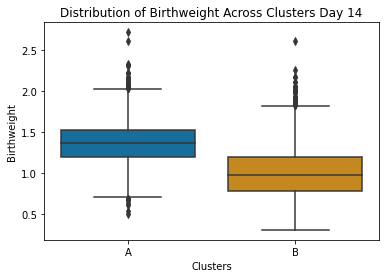

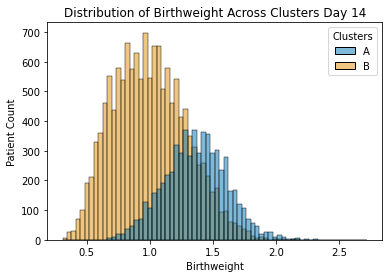

             Mean        SD
Cluster                    
A        1.365717  0.247273
B        1.001211  0.288980


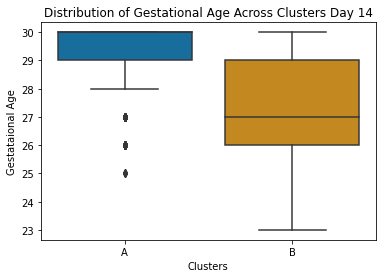

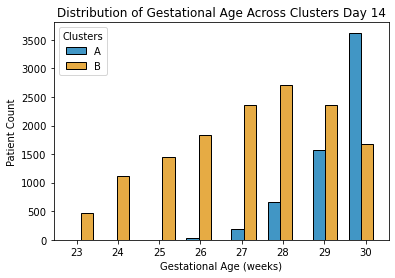

              Mean        SD
Cluster                     
A        29.406440  0.848387
B        27.177724  1.927999


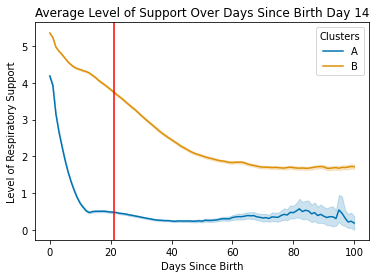

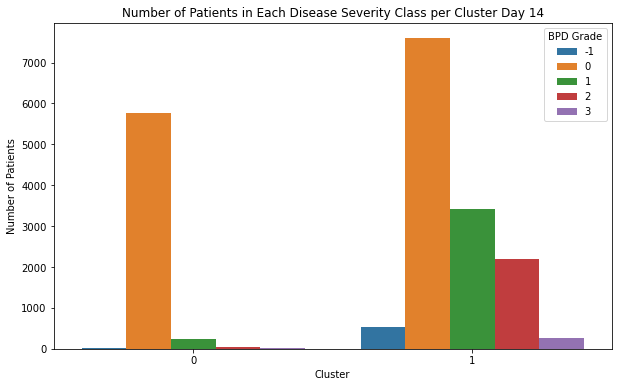

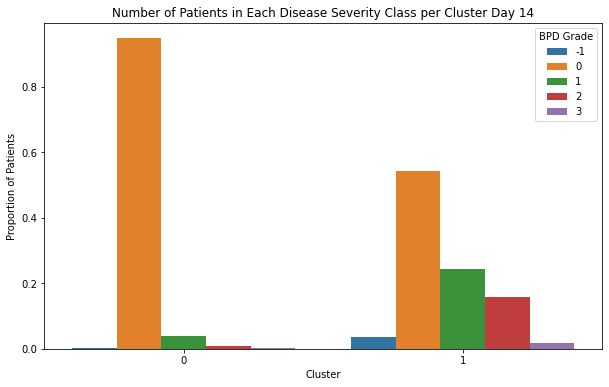

lr_21_


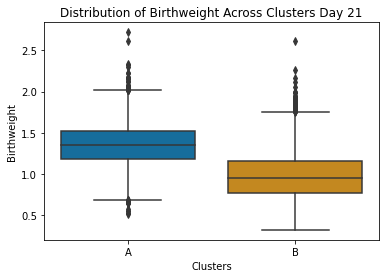

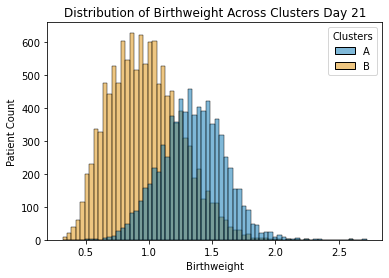

             Mean        SD
Cluster                    
A        1.347642  0.245835
B        0.972057  0.275647


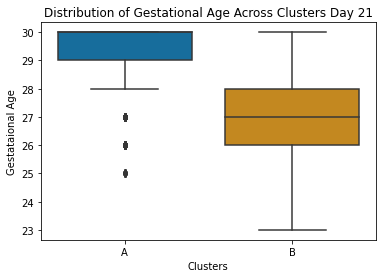

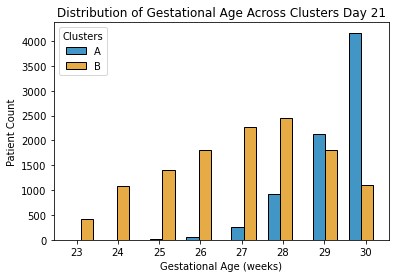

              Mean        SD
Cluster                     
A        29.337231  0.885926
B        26.985237  1.876518


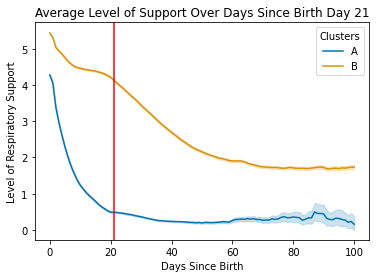

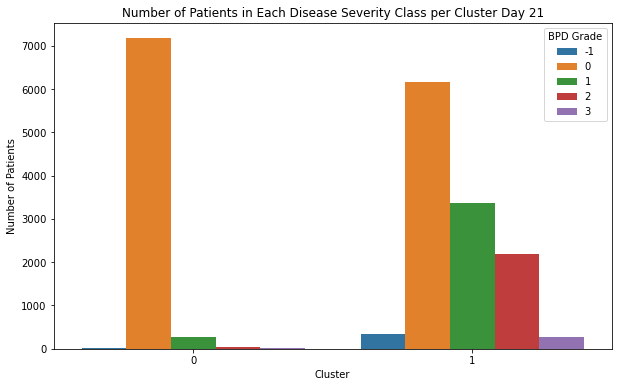

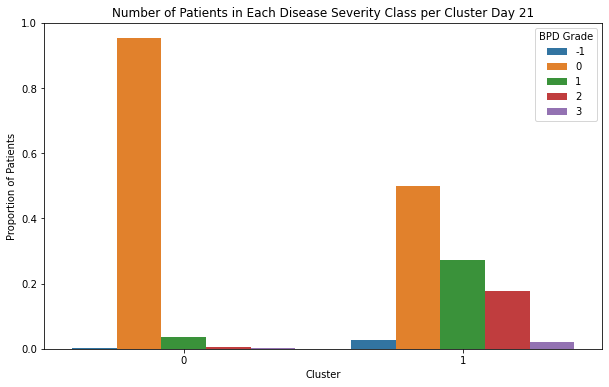

lr_27_


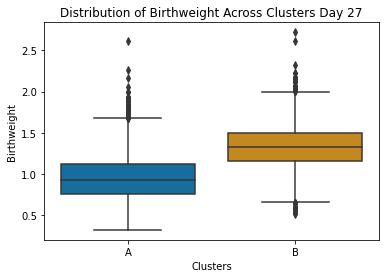

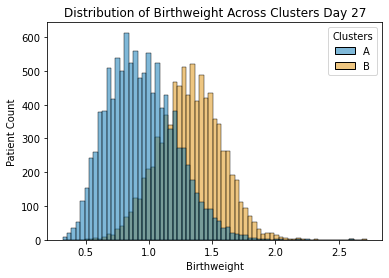

             Mean        SD
Cluster                    
A        0.945306  0.264423
B        1.327177  0.245322


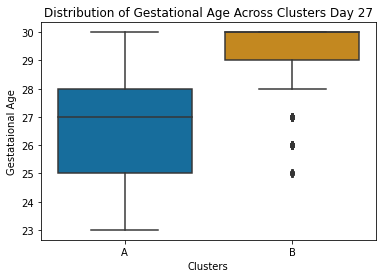

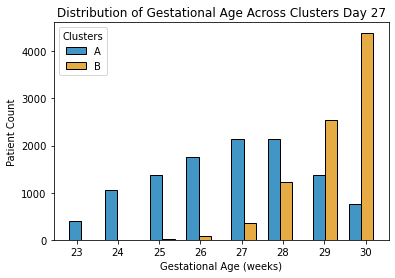

              Mean        SD
Cluster                     
A        26.802696  1.838041
B        29.249274  0.932200


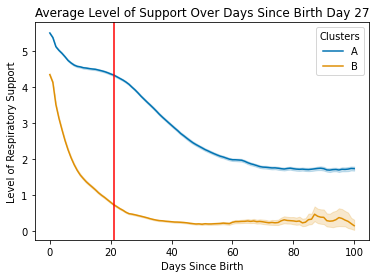

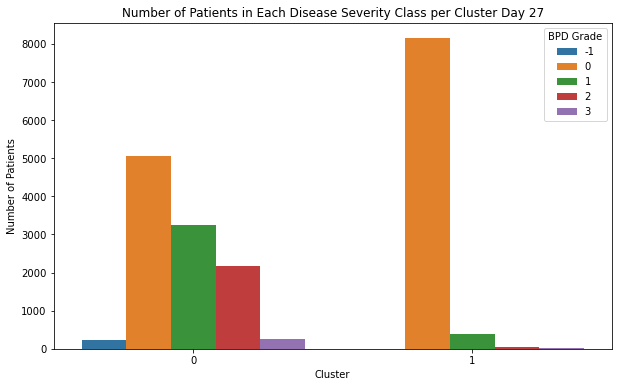

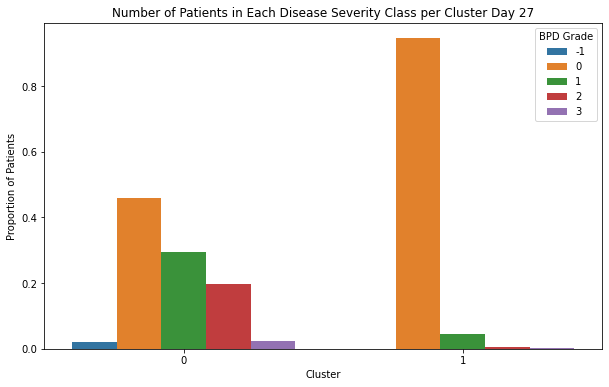

In [13]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']
days_mapping = {'lr_1_': 'Day 1', 'lr_3_': 'Day 3', 'lr_7_': 'Day 7', 'lr_14_': 'Day 14', 'lr_21_': 'Day 21', 
               'lr_27_': 'Day 27'}
for cluster in f_clusters:
    curr_c_df = pd.read_csv(CDATA_DIR_PATH + cluster + c_suffix)
    num_clusters = len(list(set(curr_c_df['umap_KMeans'])))
    curr_df = curr_c_df.merge(pf_df).merge(dis_df)
    curr_ds_df = curr_c_df.merge(ds_df)
    curr_labels = labels[0:num_clusters]
    identifier = days_mapping[cluster]
    print(cluster)
    # Birthweight
    g = sns.boxplot(data=curr_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
    g.set_xticks(range(len(curr_labels)))
    g.set_xticklabels(curr_labels)
    plt.title('Distribution of Birthweight Across Clusters ' + identifier)
    plt.xlabel('Clusters')
    plt.ylabel('Birthweight')

    fig, ax1 = plt.subplots()
    sp1 = sns.histplot(data=curr_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                       multiple='layer',
                      )
    ax1.set_title('Distribution of Birthweight Across Clusters ' + identifier)
    ax1.set_ylabel('Patient Count')
    ax1.set_xlabel('Birthweight')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
    plt.show()

    bw_means = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
    bw_means = list(bw_means['BirthWeight'])
    bw_sds = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
    bw_sds = list(bw_sds['BirthWeight'])
    bw = pd.DataFrame({'Cluster': curr_labels, 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
    print(bw)
    # Gestational Age
    g = sns.boxplot(data=curr_df, x='umap_KMeans', y='GestAge', palette='colorblind')
    g.set_xticks(range(len(curr_labels)))
    g.set_xticklabels(curr_labels)
    plt.title('Distribution of Gestational Age Across Clusters ' + identifier)
    plt.xlabel('Clusters')
    plt.ylabel('Gestataional Age')

    fig, ax1 = plt.subplots()
    sp1 = sns.histplot(data=curr_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                      shrink=2.7)
    ax1.set_title('Distribution of Gestational Age Across Clusters ' + identifier)
    ax1.set_ylabel('Patient Count')
    ax1.set_xlabel('Gestational Age (weeks)')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
    plt.show()

    ga_means = curr_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
    ga_means = list(ga_means['GestAge'])
    ga_sds = curr_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
    ga_sds = list(ga_sds['GestAge'])
    ga = pd.DataFrame({'Cluster': curr_labels, 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
    print(ga)

    # Support Type Trajectory
    fig, ax1 = plt.subplots()
    sp1 = sns.lineplot(data=curr_ds_df.loc[curr_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                       hue='umap_KMeans', palette = 'colorblind', ax=ax1)
    ax1.set_title('Average Level of Support Over Days Since Birth ' + identifier)
    ax1.set_ylabel('Level of Respiratory Support')
    ax1.set_xlabel('Days Since Birth')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
    ax1.axvline(x=21, c='red')

    # Purity Analysis
    grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
    plt.title('Number of Patients in Each Disease Severity Class per Cluster ' + identifier)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Patients')
    plt.show()
    
    # Calculate total counts for each 'umap_KMeans'
    totals = curr_df.groupby('umap_KMeans').size().reset_index(name='total_counts')

    # Calculate counts for each combination of 'umap_KMeans' and 'BPD Grade'
    grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')

    # Merge the total counts into grouped DataFrame
    grouped = pd.merge(grouped, totals, on='umap_KMeans')

    # Calculate normalized counts
    grouped['normalized_counts'] = grouped['counts'] / grouped['total_counts']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='umap_KMeans', y='normalized_counts', hue='BPD Grade', data=grouped)
    plt.title('Number of Patients in Each Disease Severity Class per Cluster ' + identifier)
    plt.xlabel('Cluster')
    plt.ylabel('Proportion of Patients')  # Update y label
    plt.show()

In [14]:
c_suffix = 'c_df.csv'
for cluster in f_clusters:
    curr_c_df = pd.read_csv(CDATA_DIR_PATH + cluster + c_suffix)
    print(days_mapping[cluster])
    print(curr_c_df['umap_KMeans'].value_counts())

Day 1
0    20467
1      893
Name: umap_KMeans, dtype: int64
Day 3
0    10351
1     9629
2      837
Name: umap_KMeans, dtype: int64
Day 7
0    10509
1     9979
Name: umap_KMeans, dtype: int64
Day 14
1    13988
0     6087
Name: umap_KMeans, dtype: int64
Day 21
1    12328
0     7526
Name: umap_KMeans, dtype: int64
Day 27
0    10978
1     8613
Name: umap_KMeans, dtype: int64


In [16]:
dis_df['BPD Grade'] = dis_df['BPD Grade'].replace(-1, 4)

lr_d1g0_


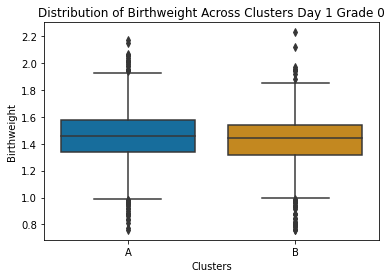

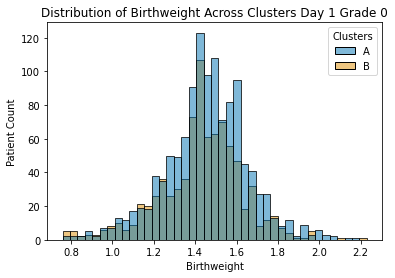

             Mean        SD
Cluster                    
A        1.455381  0.200623
B        1.425372  0.202399


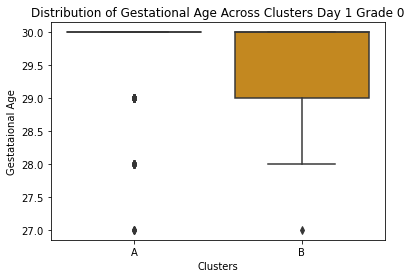

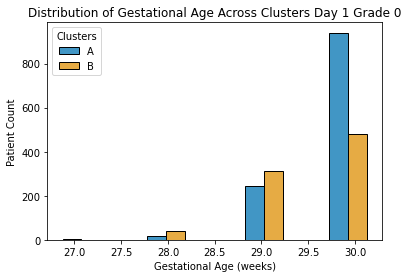

              Mean        SD
Cluster                     
A        29.757249  0.483453
B        29.523409  0.594237


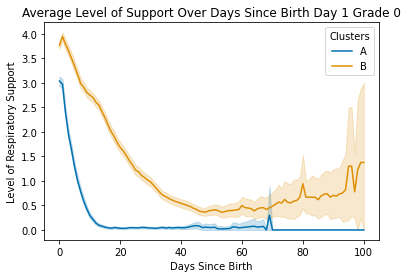

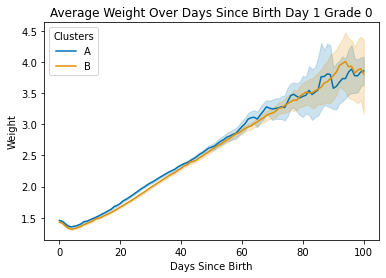

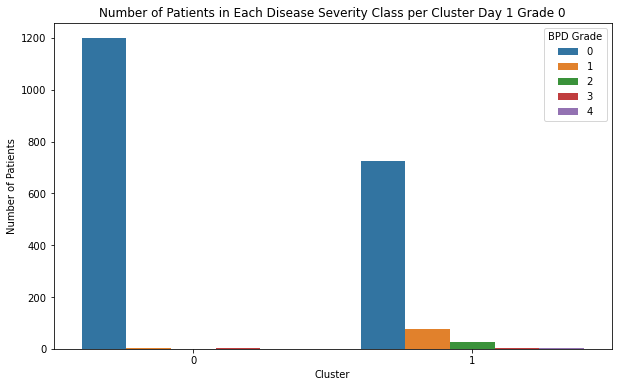

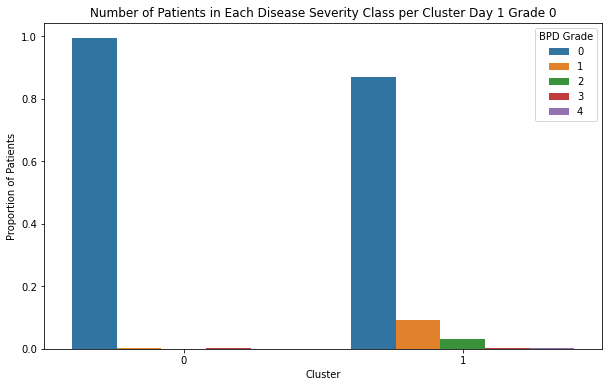

lr_d1g1_


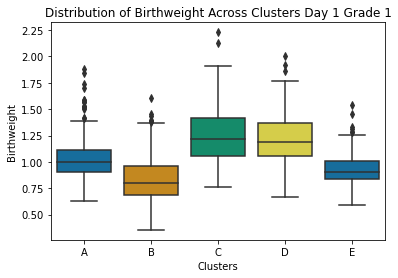

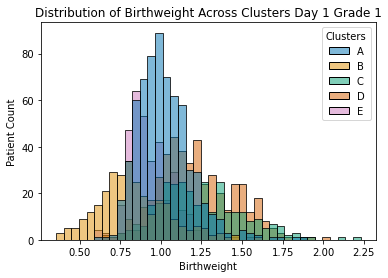

             Mean        SD
Cluster                    
A        1.020522  0.164444
B        0.827194  0.216936
C        1.249112  0.255107
D        1.220288  0.228938
E        0.932803  0.136954


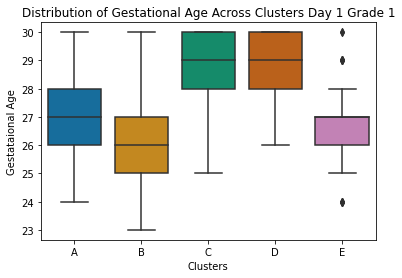

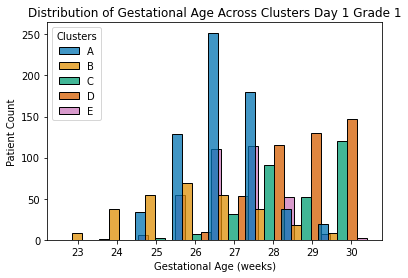

              Mean        SD
Cluster                     
A        27.173047  1.077834
B        26.222222  1.624913
C        28.795380  1.175514
D        28.771429  1.090839
E        26.523121  1.077188


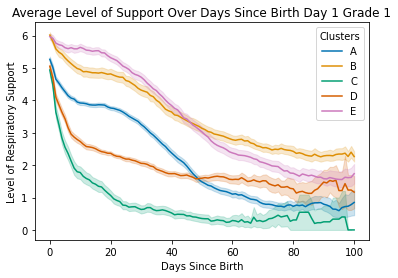

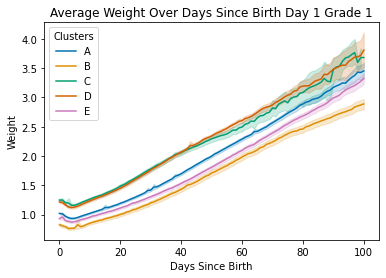

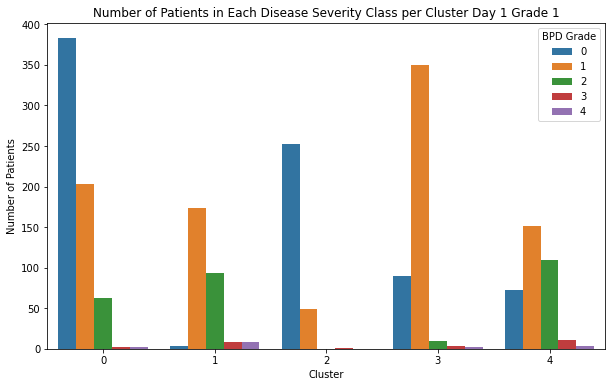

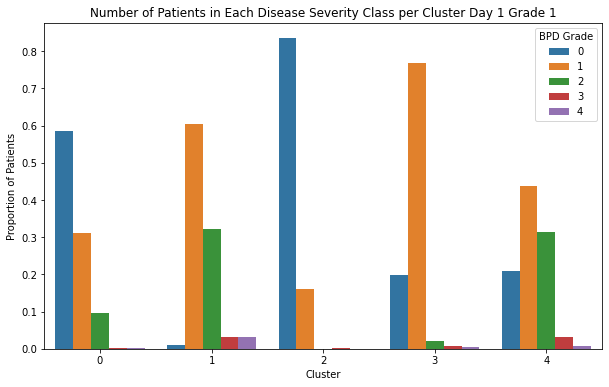

lr_d1g2_


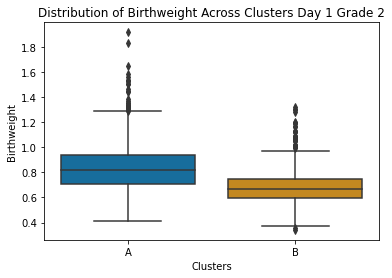

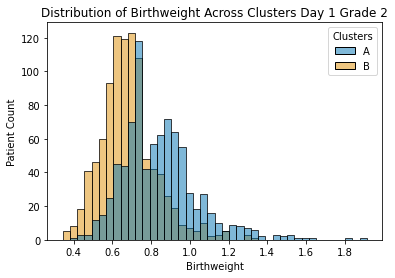

             Mean        SD
Cluster                    
A        0.840541  0.196128
B        0.681797  0.143751


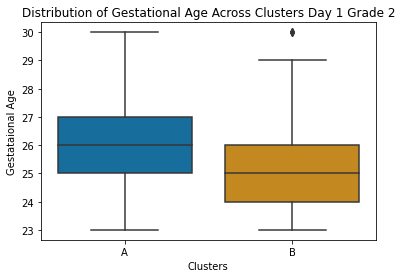

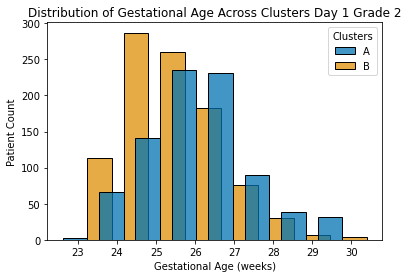

              Mean        SD
Cluster                     
A        26.446834  1.433904
B        24.956296  1.334699


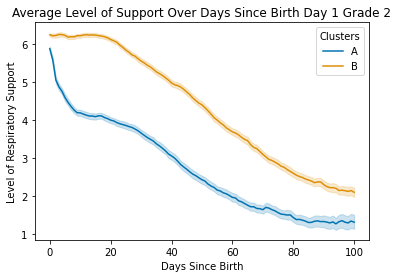

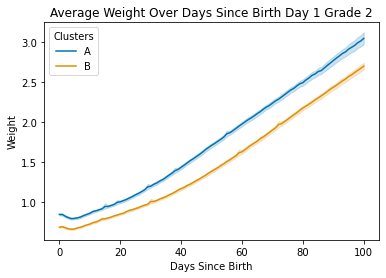

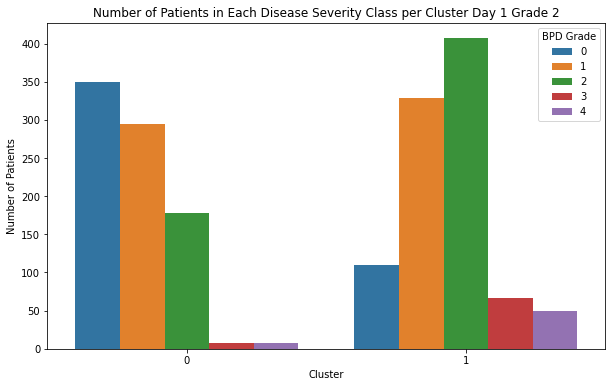

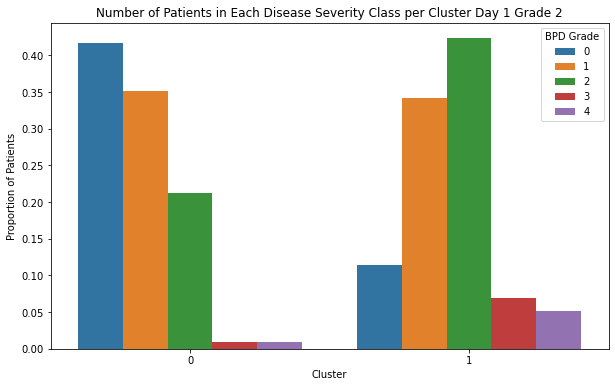

lr_d1g3_


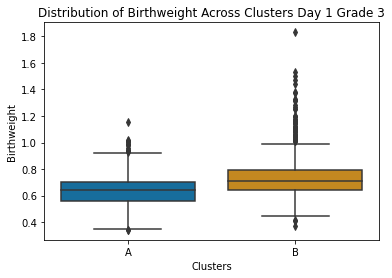

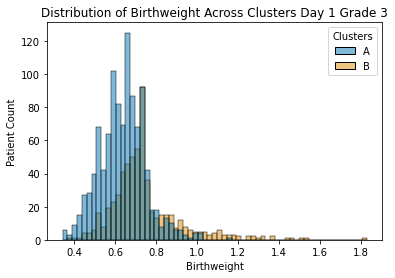

             Mean        SD
Cluster                    
A        0.636262  0.110973
B        0.744115  0.173358


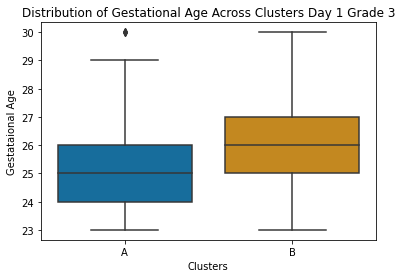

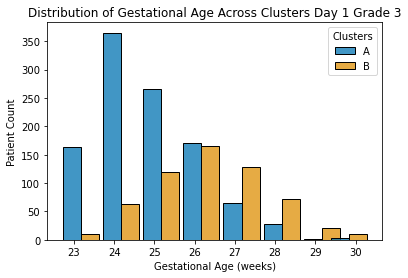

              Mean        SD
Cluster                     
A        24.725730  1.272788
B        26.170897  1.436651


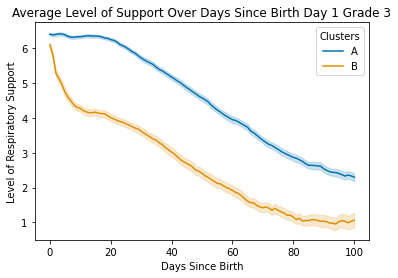

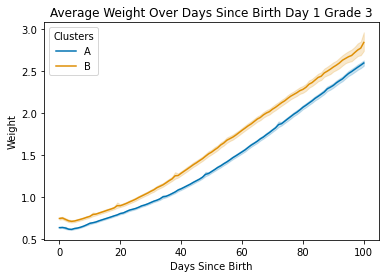

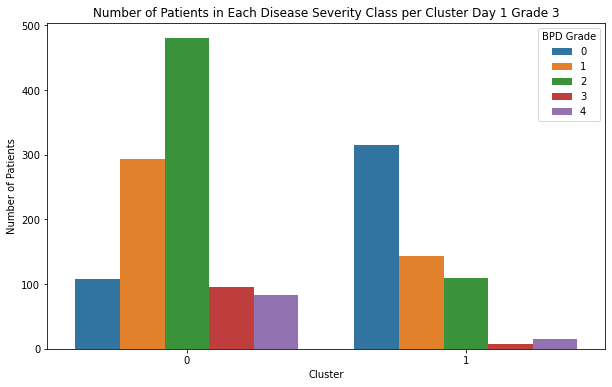

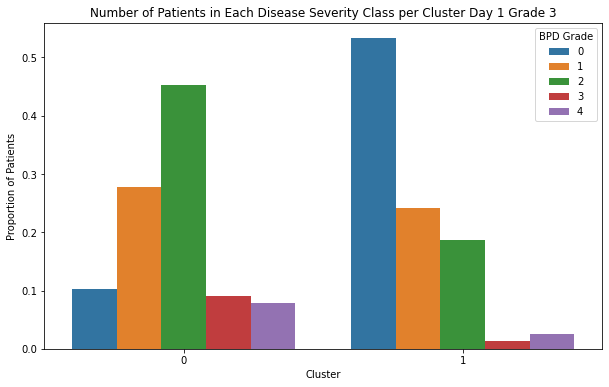

lr_d1g4_


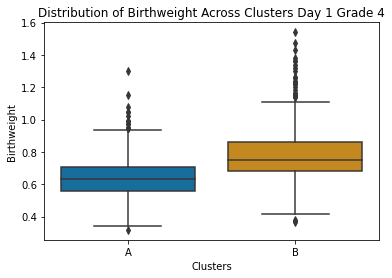

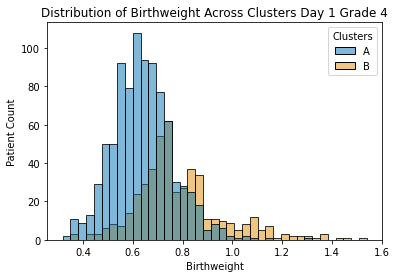

             Mean        SD
Cluster                    
A        0.639844  0.122322
B        0.786519  0.179181


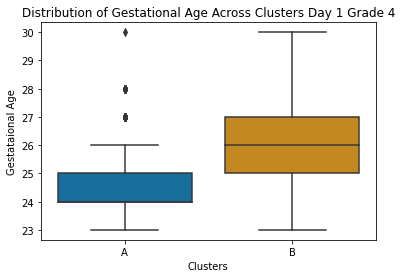

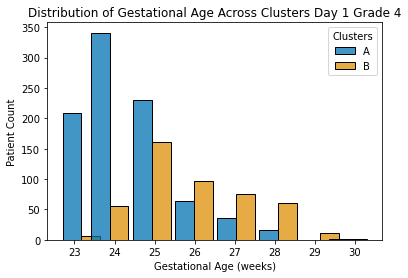

              Mean        SD
Cluster                     
A        24.366071  1.153052
B        25.876068  1.359251


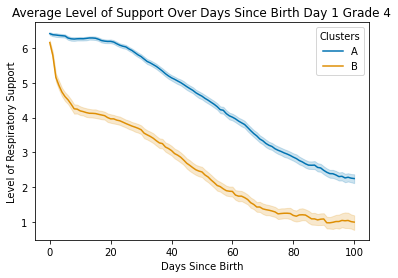

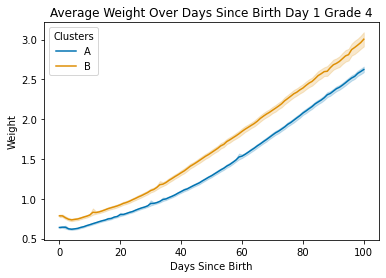

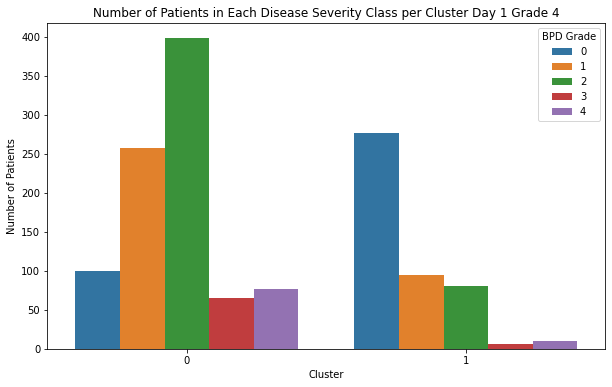

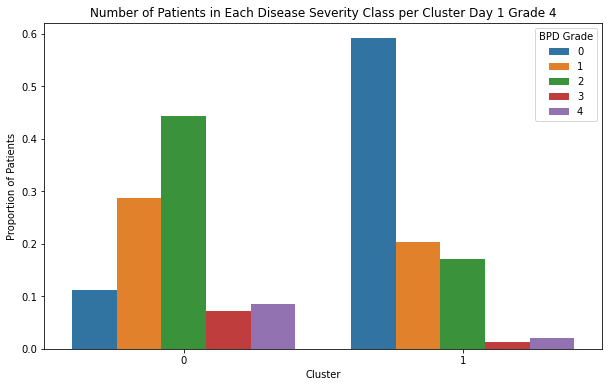

lr_d3g0_


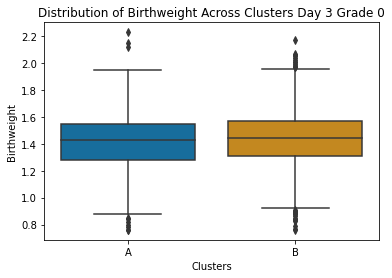

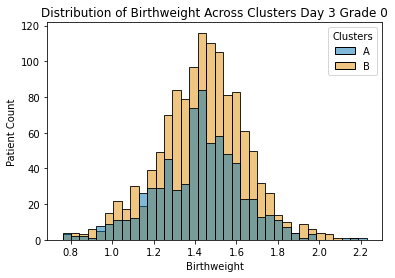

             Mean        SD
Cluster                    
A        1.417558  0.212201
B        1.435025  0.209250


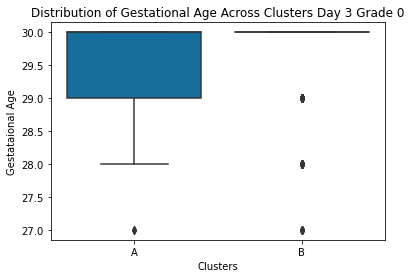

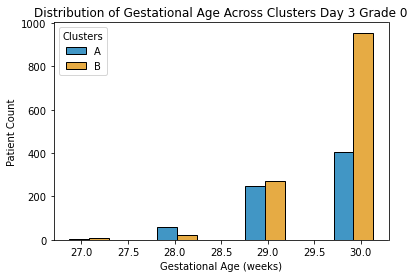

             Mean        SD
Cluster                    
A        29.47820  0.660145
B        29.72655  0.529130


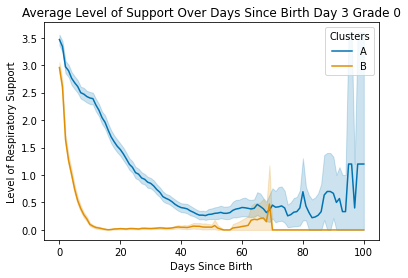

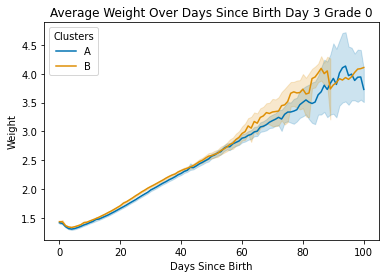

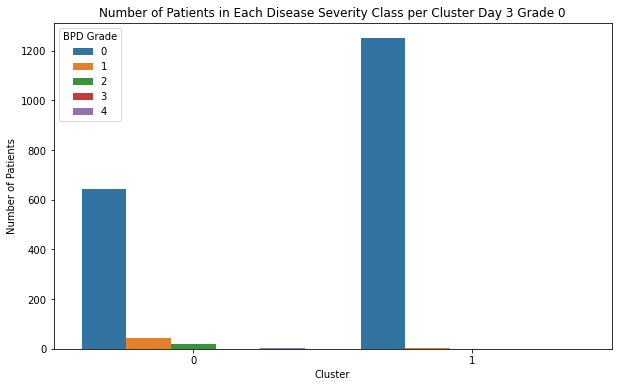

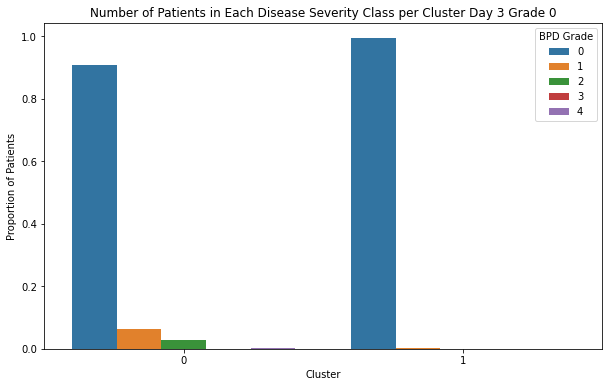

lr_d3g1_


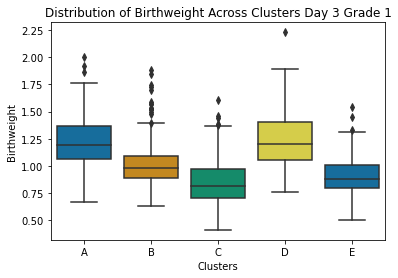

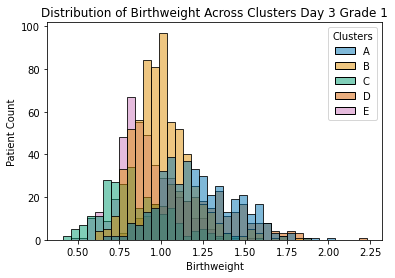

             Mean        SD
Cluster                    
A        1.223193  0.228934
B        0.999995  0.172300
C        0.844227  0.205812
D        1.232235  0.252162
E        0.905731  0.164315


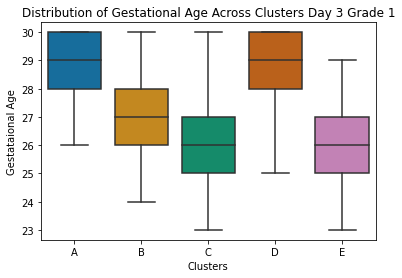

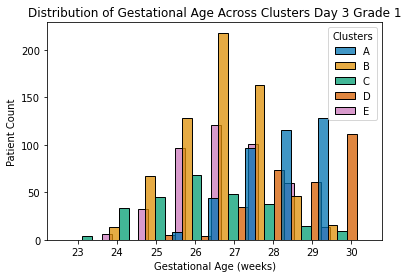

              Mean        SD
Cluster                     
A        28.793893  1.078909
B        27.003072  1.242822
C        26.315385  1.603734
D        28.778547  1.215963
E        26.194896  1.302617


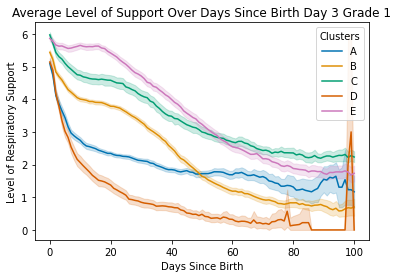

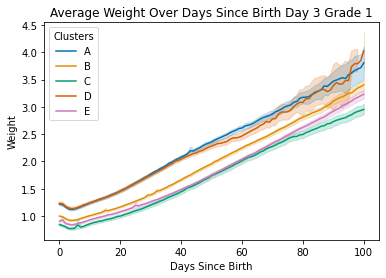

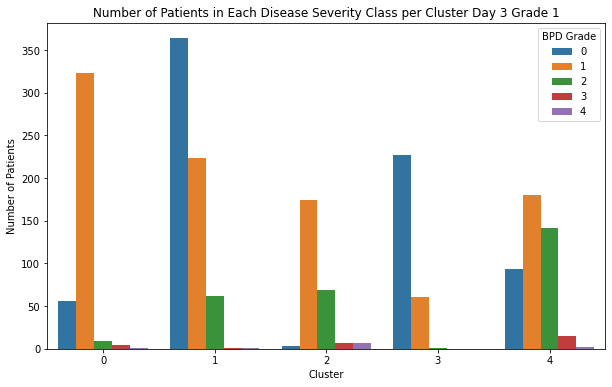

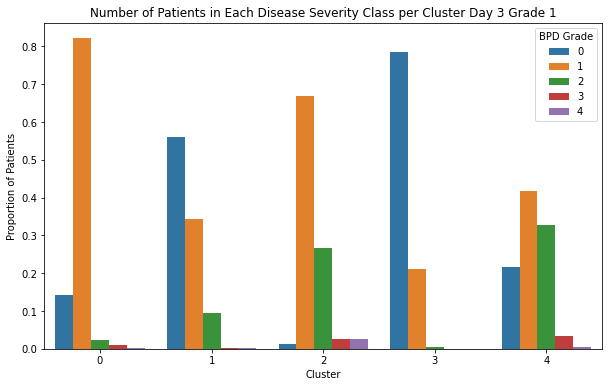

lr_d3g2_


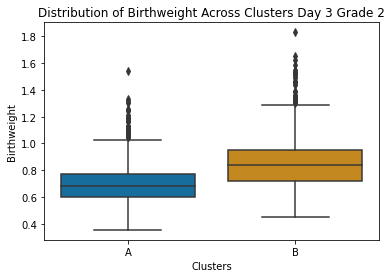

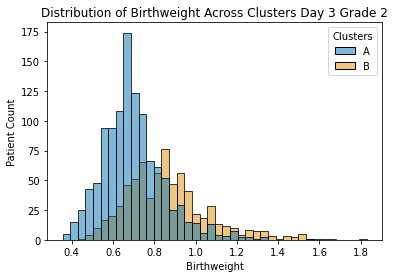

             Mean        SD
Cluster                    
A        0.696720  0.152374
B        0.863558  0.204093


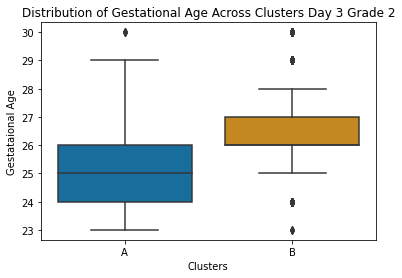

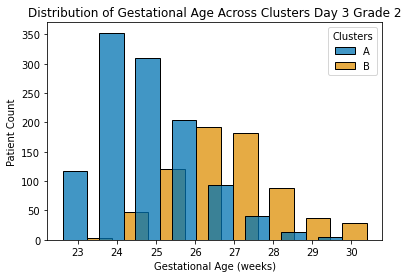

              Mean        SD
Cluster                     
A        25.000000  1.355792
B        26.516405  1.457523


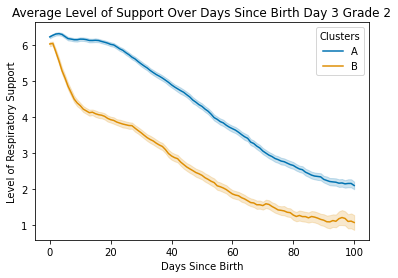

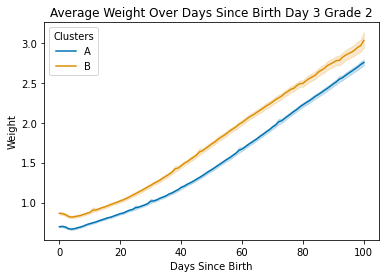

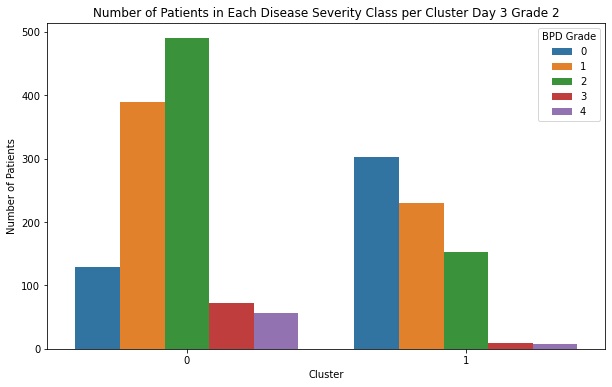

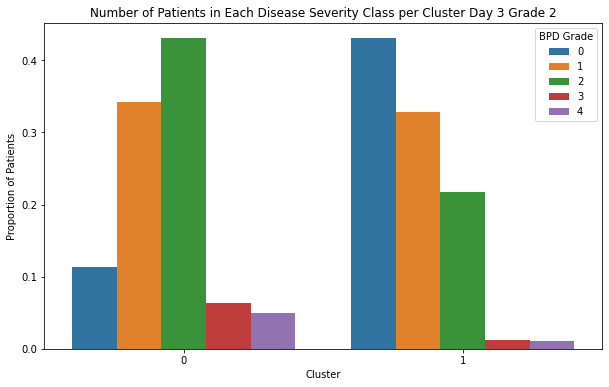

lr_d3g3_


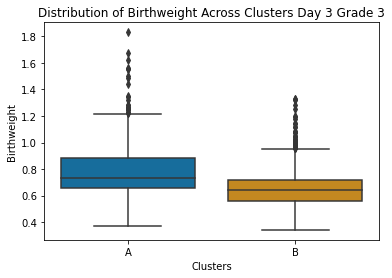

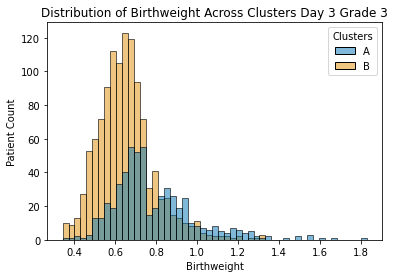

             Mean        SD
Cluster                    
A        0.788231  0.204786
B        0.651412  0.139877


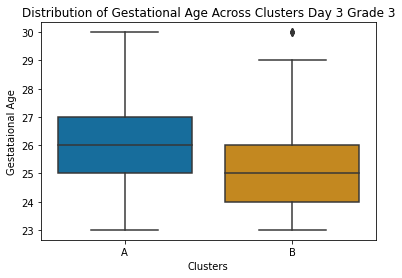

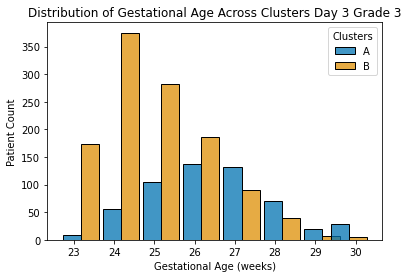

              Mean        SD
Cluster                     
A        26.376577  1.573870
B        24.838654  1.370434


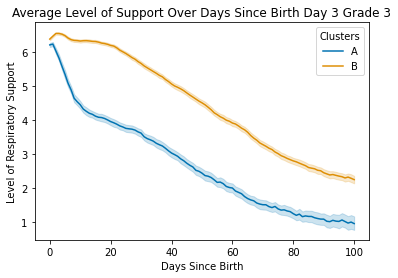

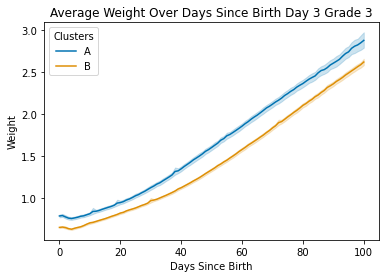

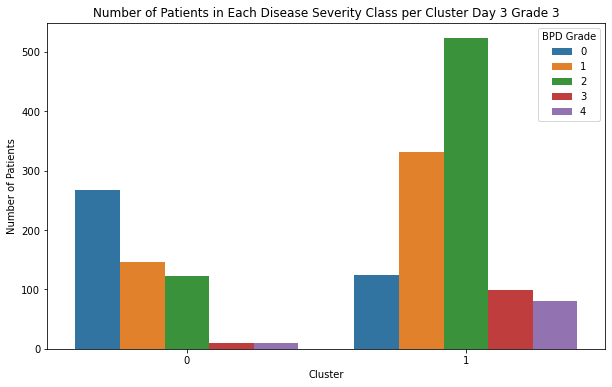

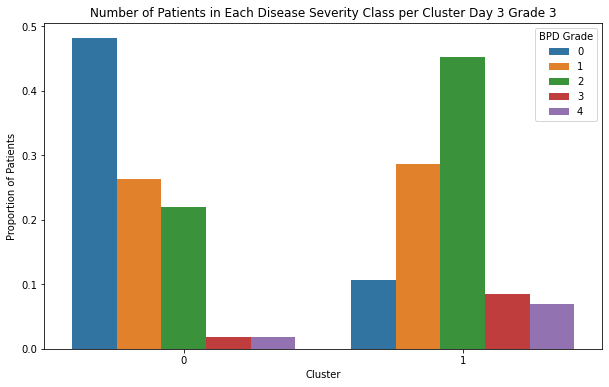

lr_d3g4_


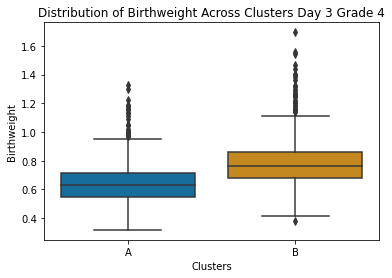

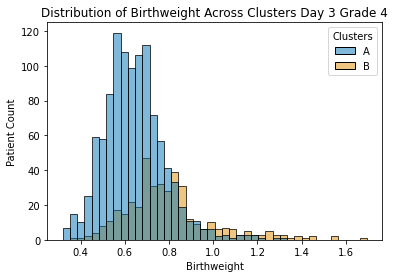

             Mean        SD
Cluster                    
A        0.640241  0.137999
B        0.797377  0.203819


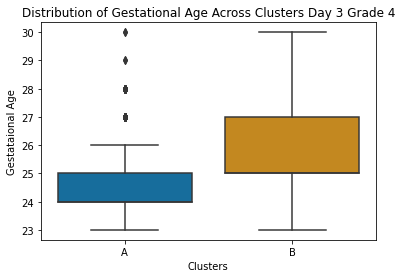

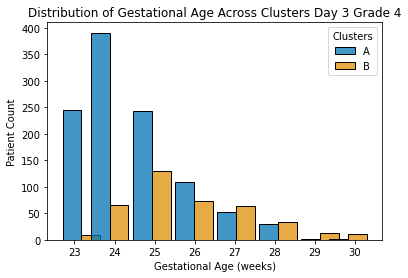

              Mean       SD
Cluster                    
A        24.480483  1.27611
B        25.814070  1.53895


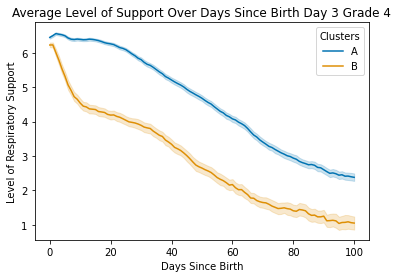

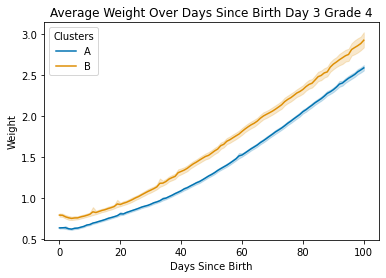

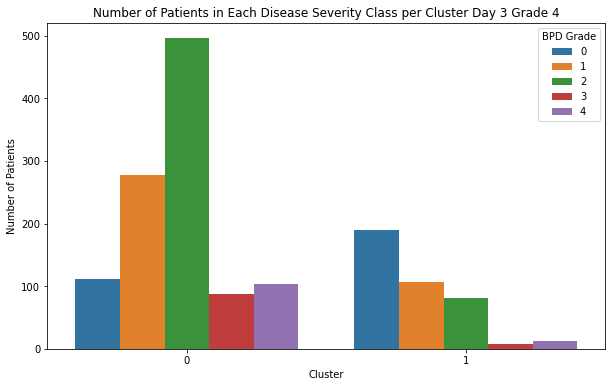

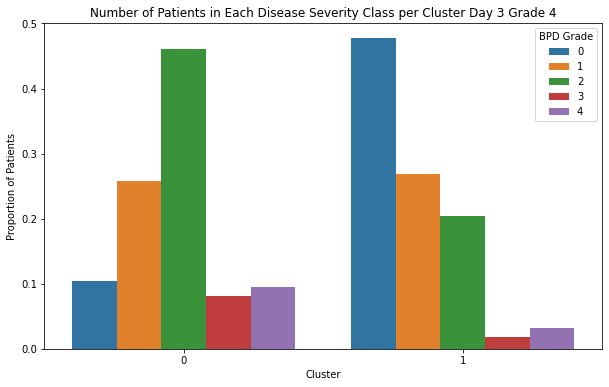

lr_d7g0_


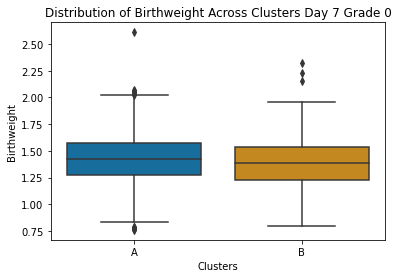

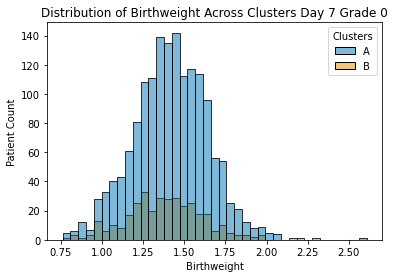

             Mean        SD
Cluster                    
A        1.415776  0.224508
B        1.386933  0.238152


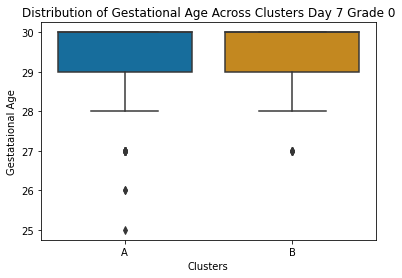

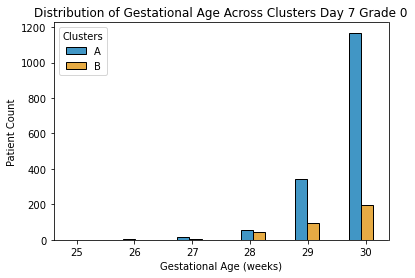

              Mean        SD
Cluster                     
A        29.676972  0.610622
B        29.402899  0.794233


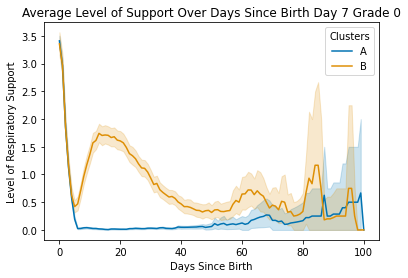

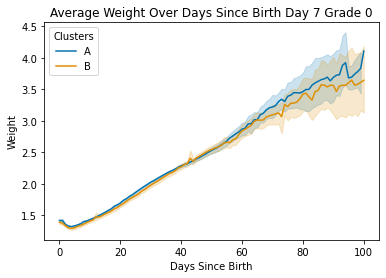

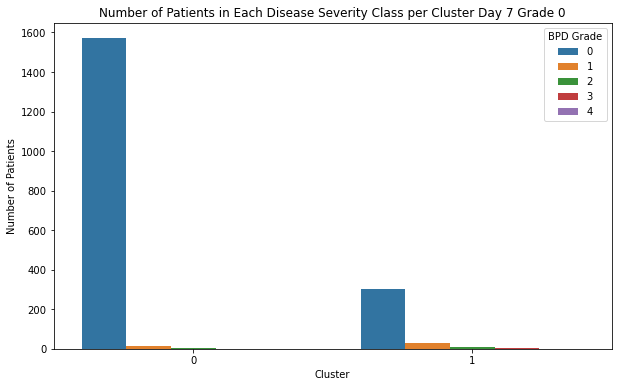

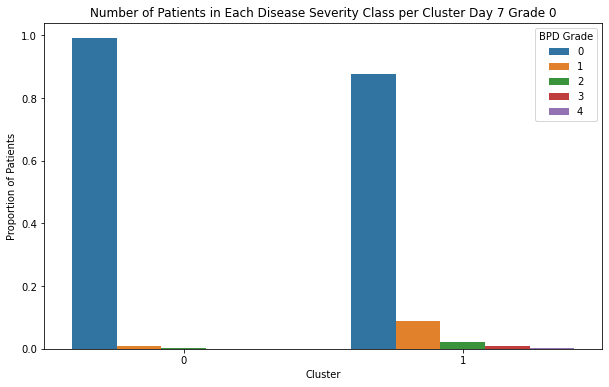

lr_d7g1_


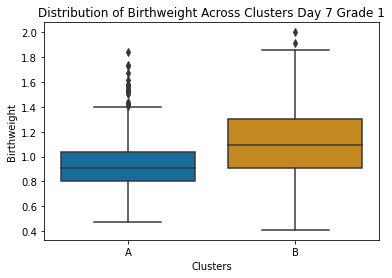

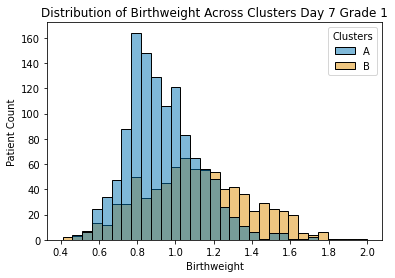

             Mean        SD
Cluster                    
A        0.931969  0.189352
B        1.106498  0.279648


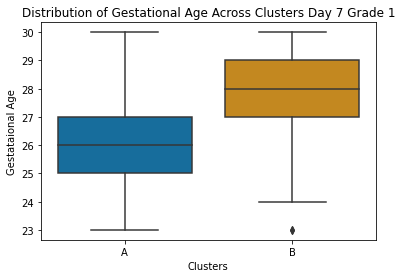

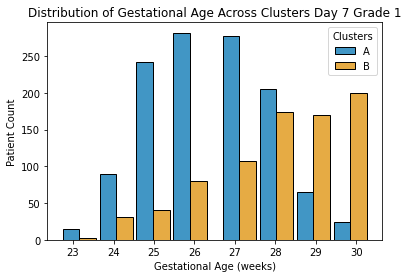

              Mean        SD
Cluster                     
A        26.425833  1.468433
B        28.057143  1.694802


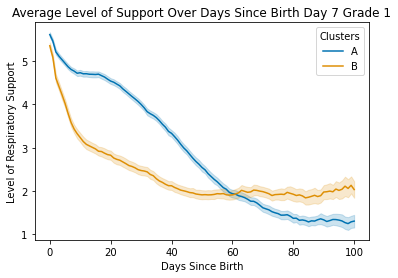

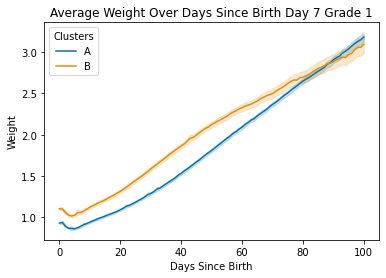

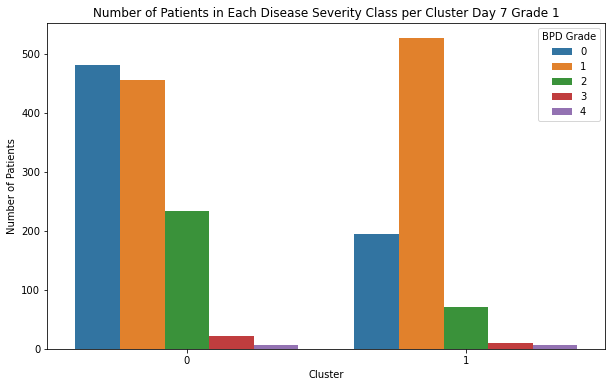

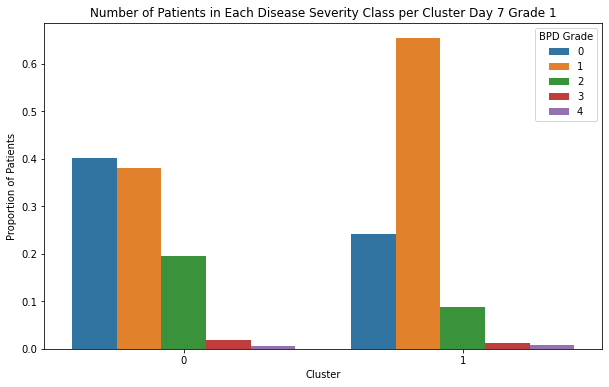

lr_d7g2_


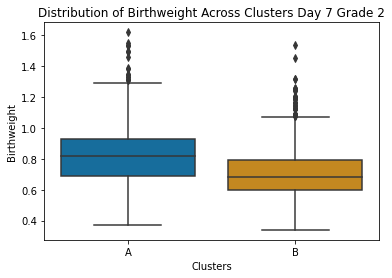

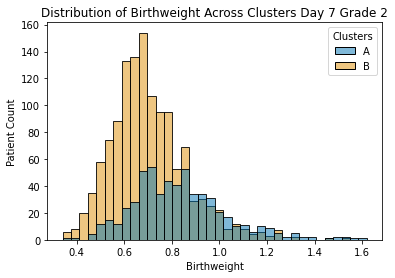

             Mean        SD
Cluster                    
A        0.830617  0.197505
B        0.701757  0.159682


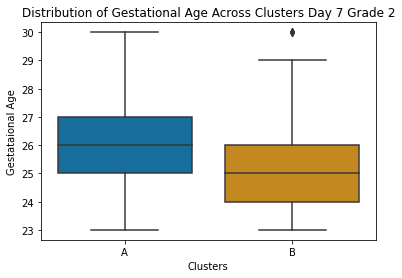

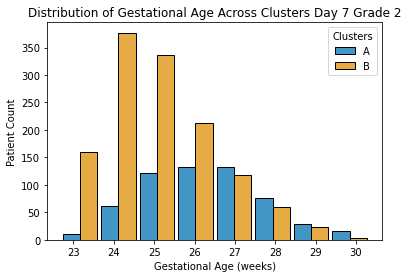

              Mean        SD
Cluster                     
A        26.279310  1.535280
B        25.032583  1.446411


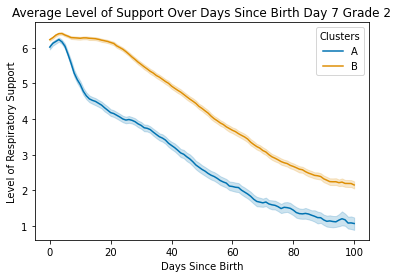

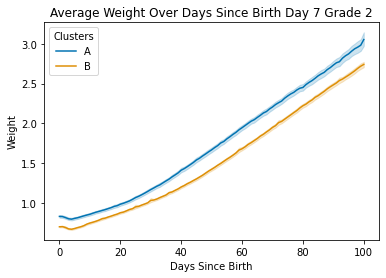

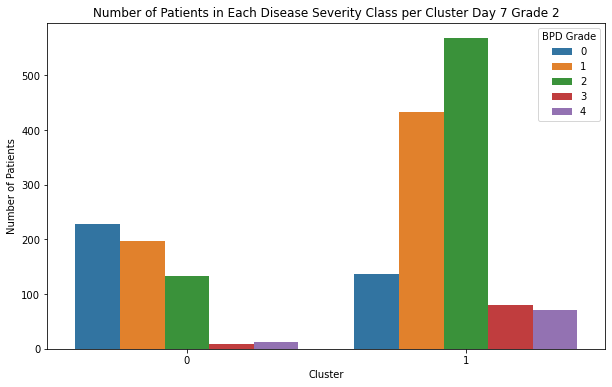

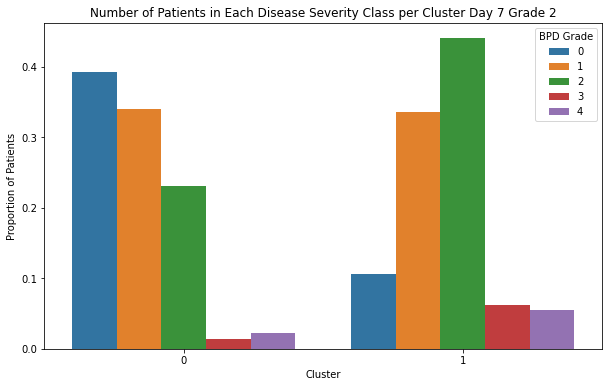

lr_d7g3_


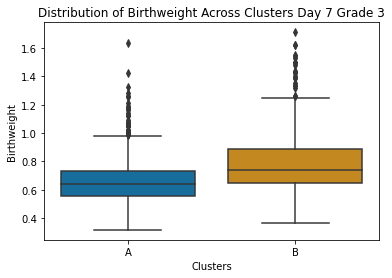

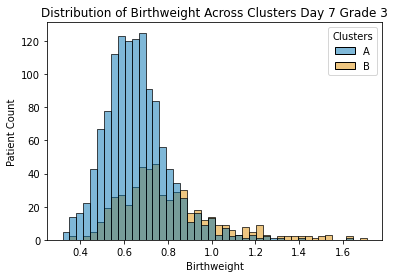

             Mean        SD
Cluster                    
A        0.655268  0.147171
B        0.795728  0.220294


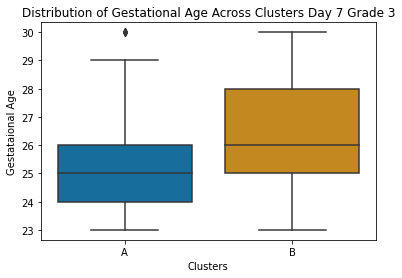

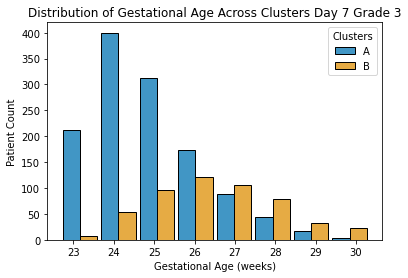

              Mean        SD
Cluster                     
A        24.798246  1.413637
B        26.437380  1.616586


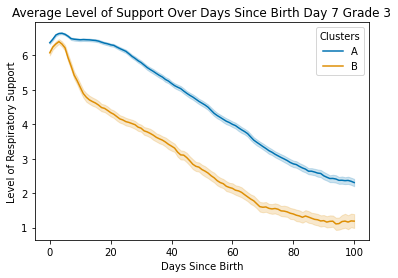

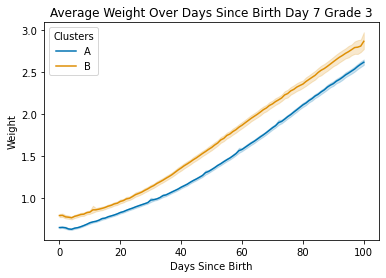

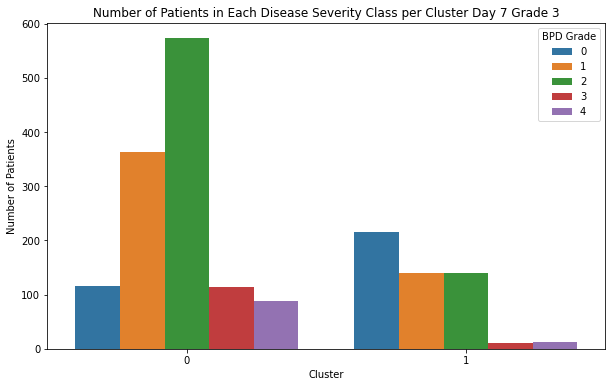

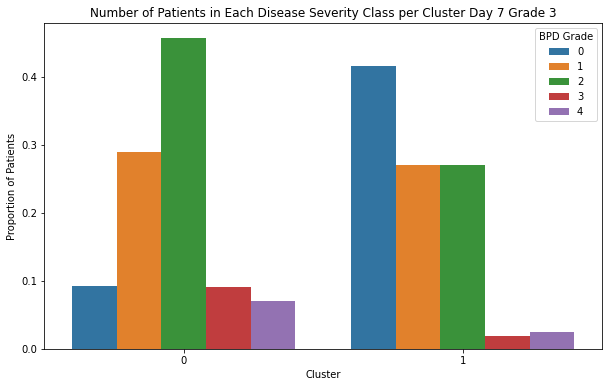

lr_d7g4_


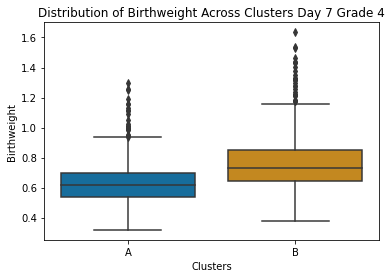

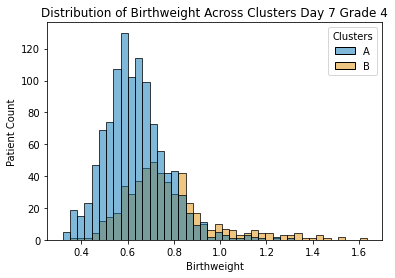

             Mean        SD
Cluster                    
A        0.632034  0.133736
B        0.771183  0.196544


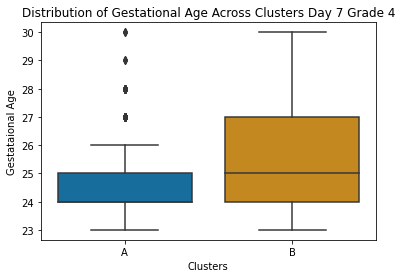

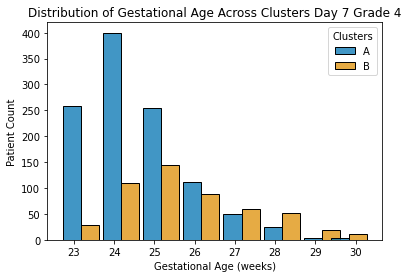

              Mean        SD
Cluster                     
A        24.452899  1.262310
B        25.641326  1.657136


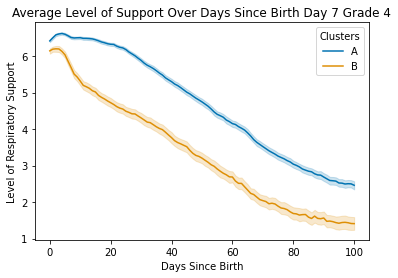

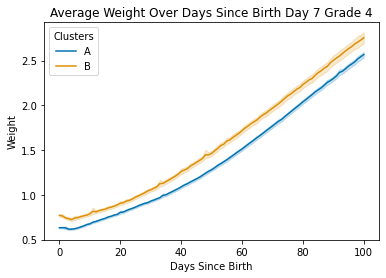

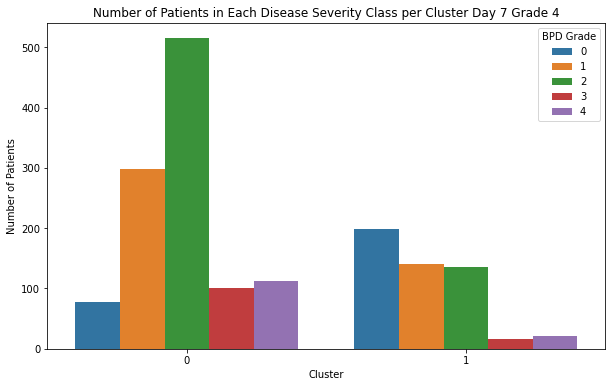

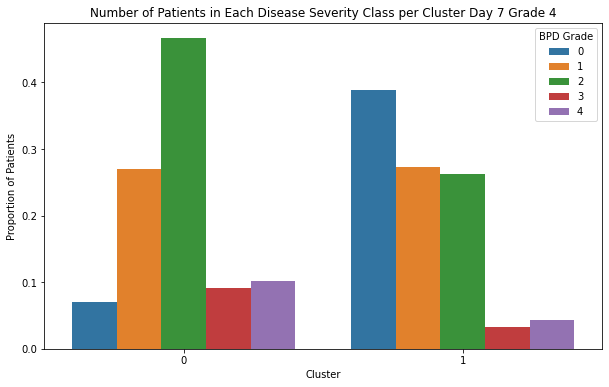

lr_d14g0_


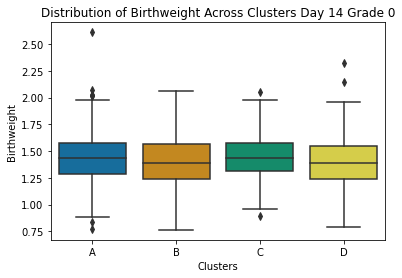

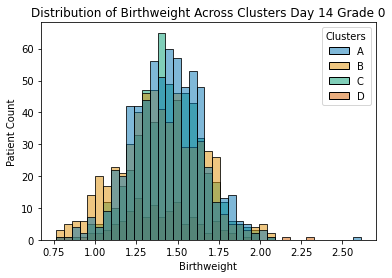

             Mean        SD
Cluster                    
A        1.440630  0.214768
B        1.396106  0.246661
C        1.446639  0.196838
D        1.408669  0.255567


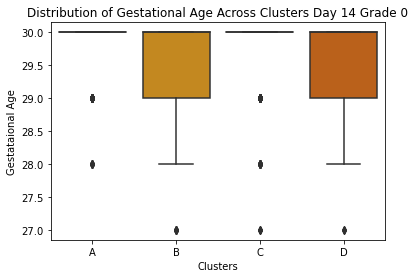

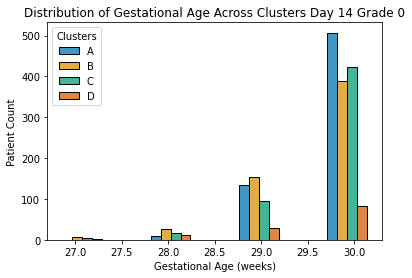

              Mean        SD
Cluster                     
A        29.764977  0.455803
B        29.601386  0.643233
C        29.741636  0.544290
D        29.524194  0.759372


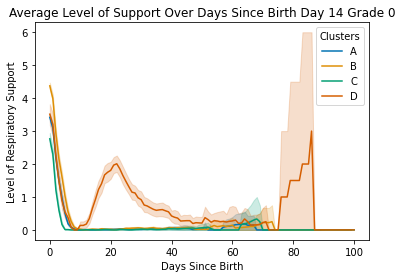

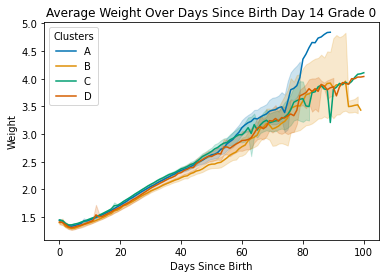

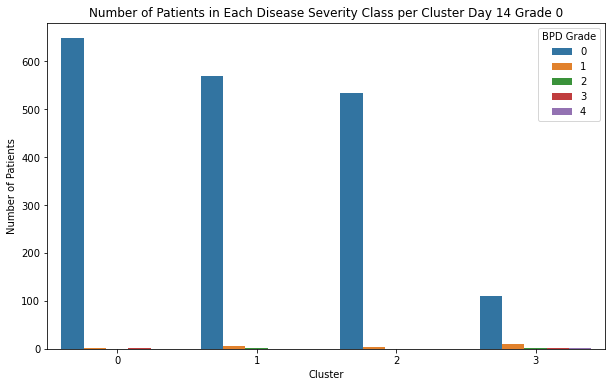

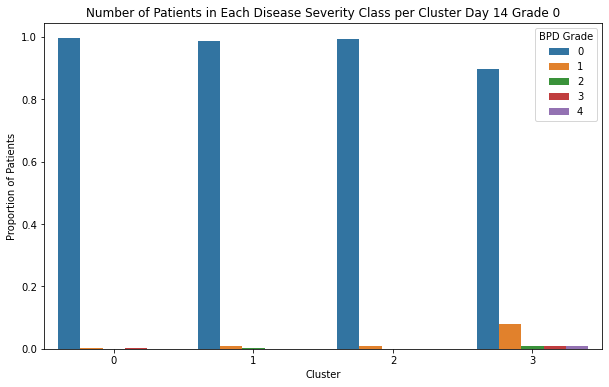

lr_d14g1_


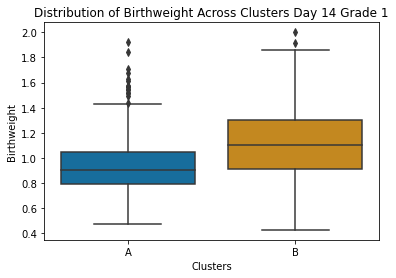

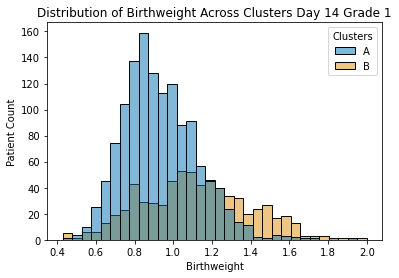

             Mean        SD
Cluster                    
A        0.930721  0.191998
B        1.115084  0.277097


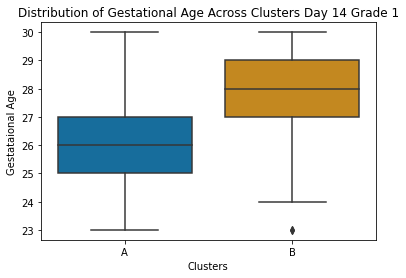

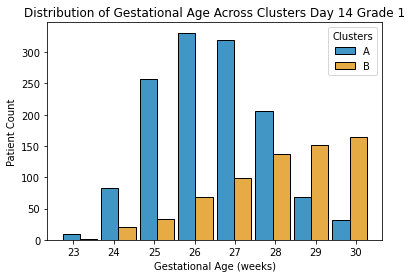

              Mean        SD
Cluster                     
A        26.473966  1.424906
B        28.087407  1.653987


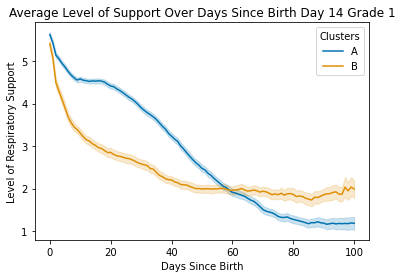

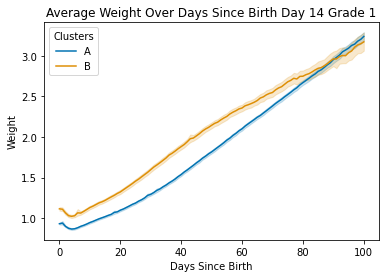

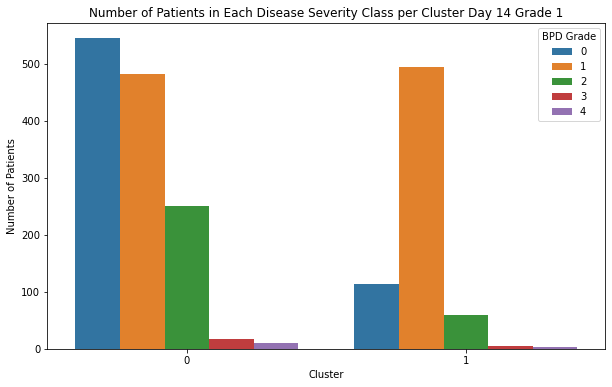

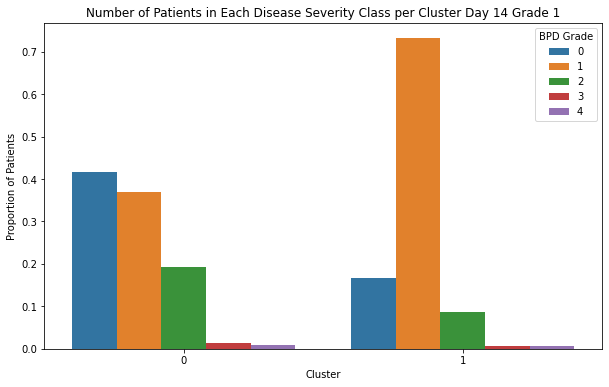

lr_d14g2_


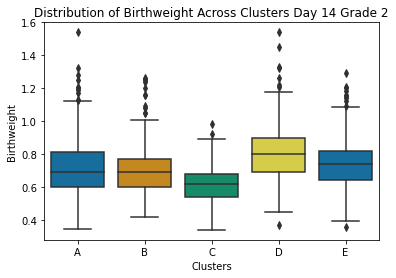

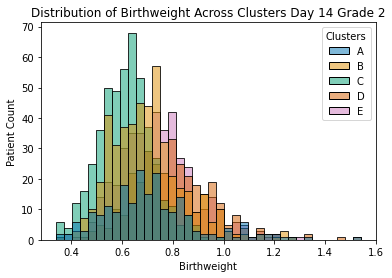

             Mean        SD
Cluster                    
A        0.719294  0.195409
B        0.702689  0.144920
C        0.614932  0.106542
D        0.806238  0.164612
E        0.743283  0.148591


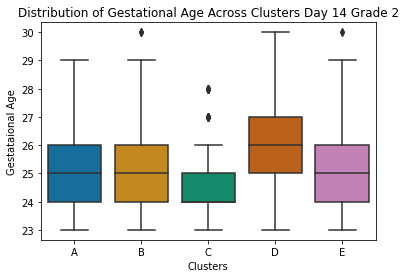

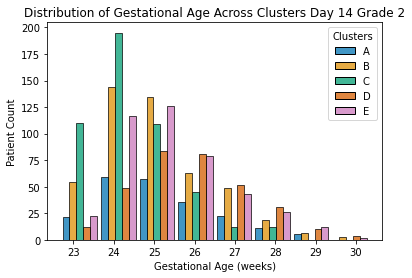

              Mean        SD
Cluster                     
A        25.151659  1.449379
B        25.010593  1.428365
C        24.358178  1.149630
D        25.820433  1.482386
E        25.327869  1.442235


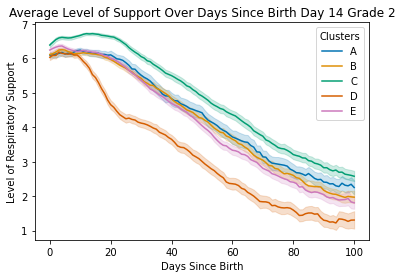

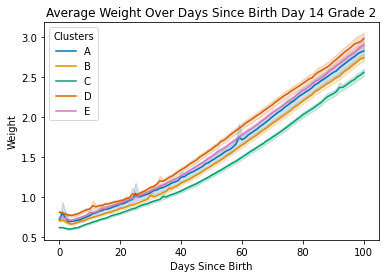

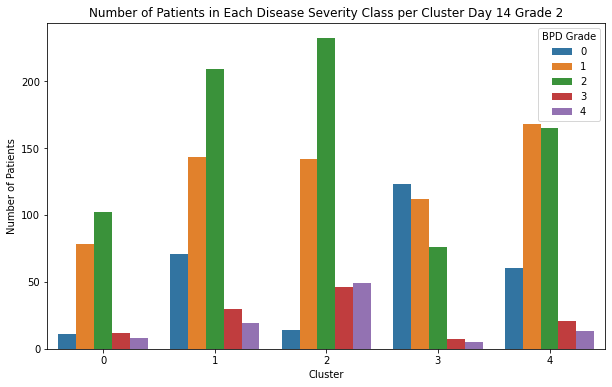

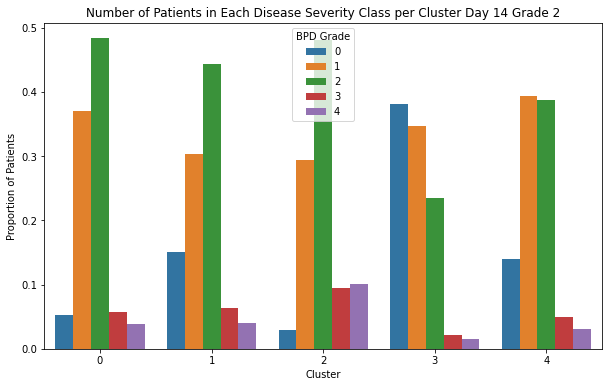

lr_d14g3_


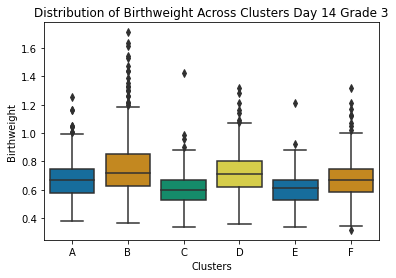

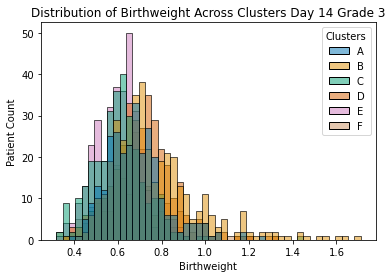

             Mean        SD
Cluster                    
A        0.680272  0.137774
B        0.772542  0.213181
C        0.604524  0.124700
D        0.715145  0.145950
E        0.607389  0.111926
F        0.679524  0.166500


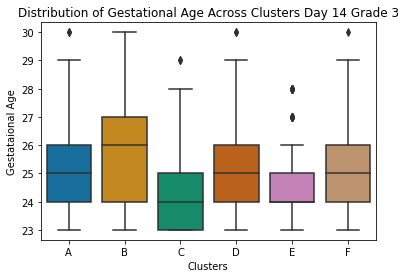

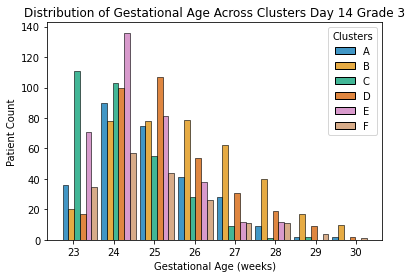

              Mean        SD
Cluster                     
A        24.929329  1.394755
B        25.841146  1.691099
C        24.132686  1.167136
D        25.250737  1.428459
E        24.485714  1.222319
F        24.867725  1.550040


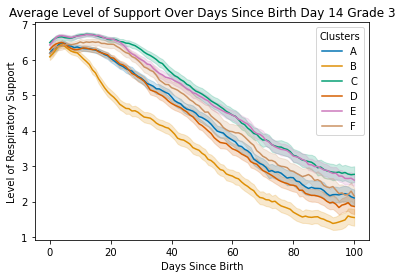

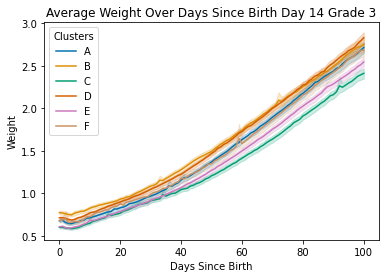

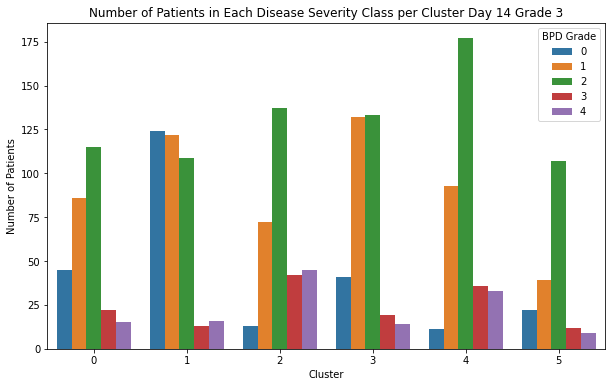

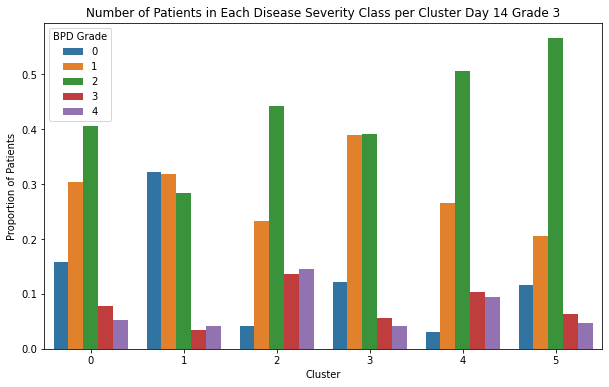

lr_d14g4_


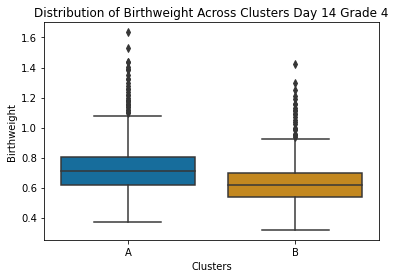

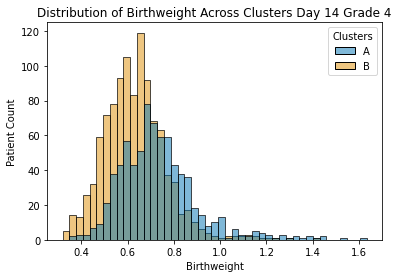

             Mean        SD
Cluster                    
A        0.730265  0.170075
B        0.628839  0.133626


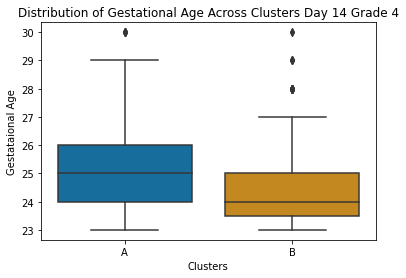

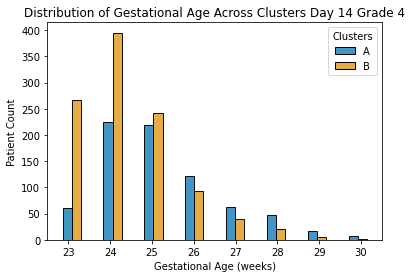

              Mean        SD
Cluster                     
A        25.201581  1.500289
B        24.378175  1.235070


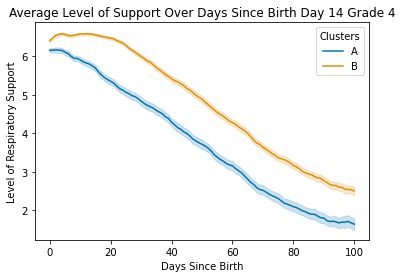

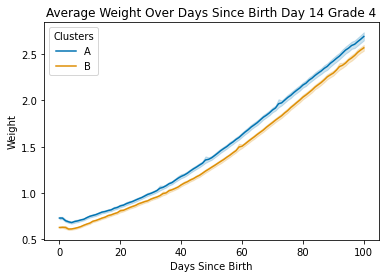

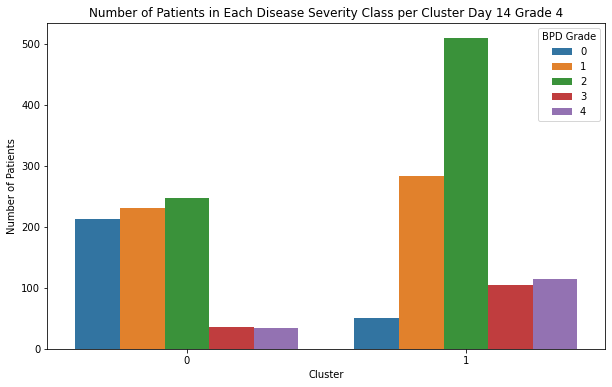

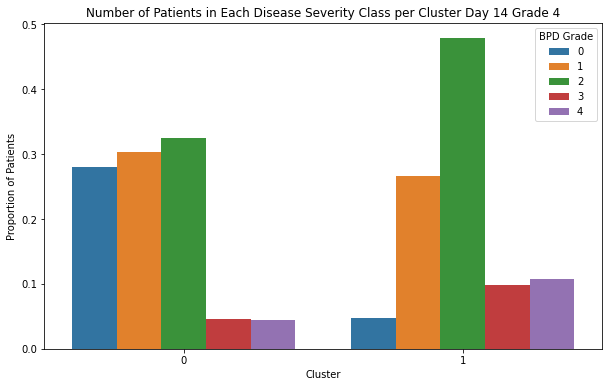

lr_d21g0_


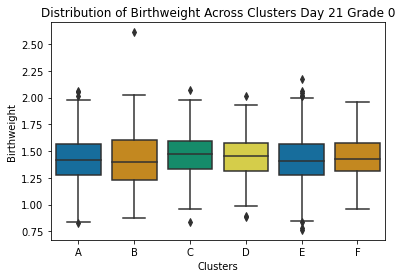

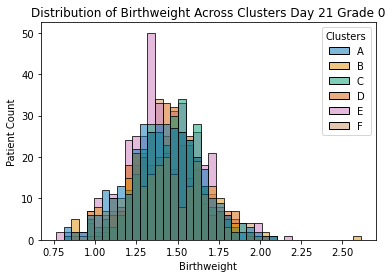

             Mean        SD
Cluster                    
A        1.414914  0.227644
B        1.405378  0.256935
C        1.454245  0.199068
D        1.445003  0.190285
E        1.421586  0.230961
F        1.444956  0.196066


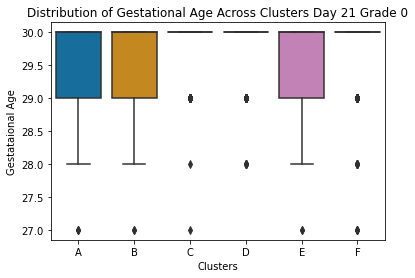

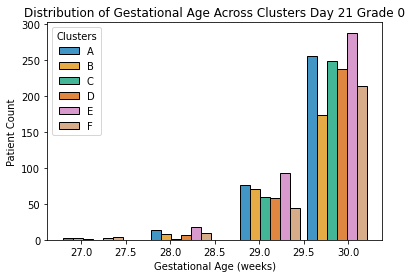

              Mean        SD
Cluster                     
A        29.680115  0.587669
B        29.633858  0.586235
C        29.790323  0.438337
D        29.762376  0.477615
E        29.663342  0.586411
F        29.726937  0.595643


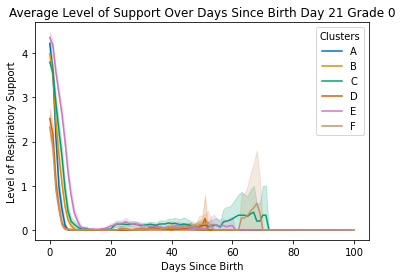

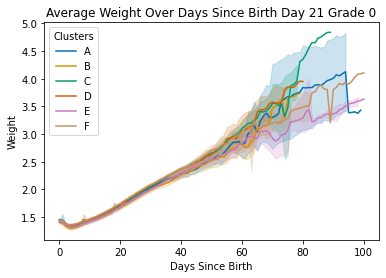

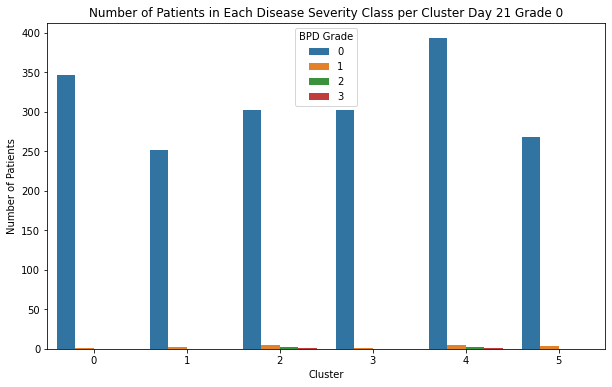

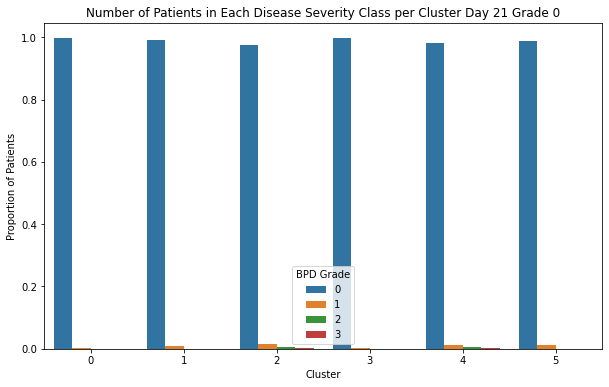

lr_d21g1_


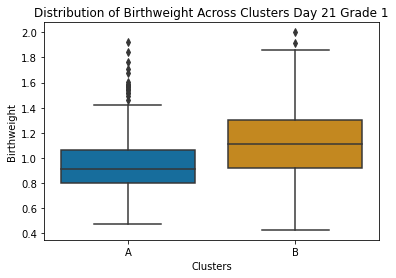

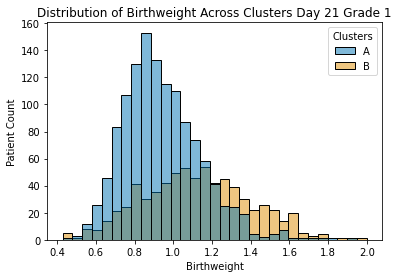

             Mean        SD
Cluster                    
A        0.937986  0.196843
B        1.117989  0.274894


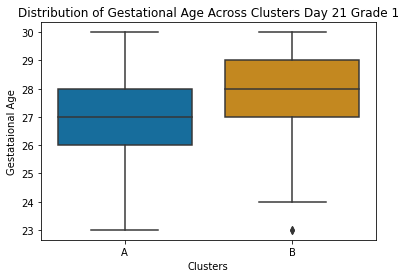

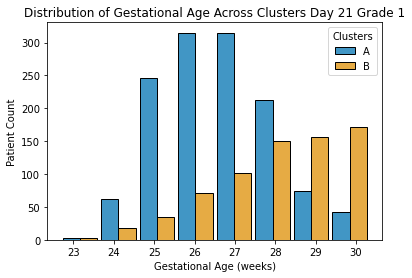

              Mean        SD
Cluster                     
A        26.595276  1.429171
B        28.102128  1.626593


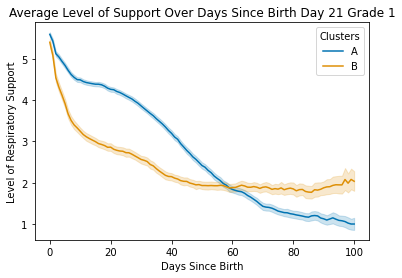

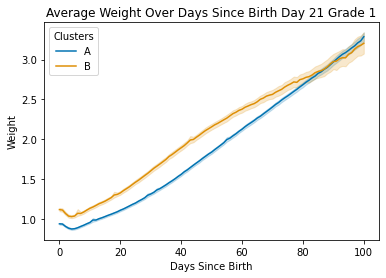

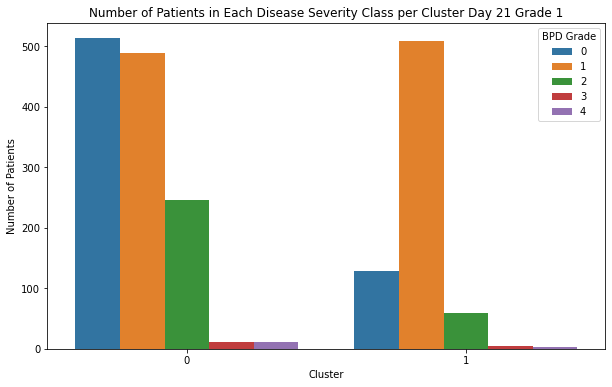

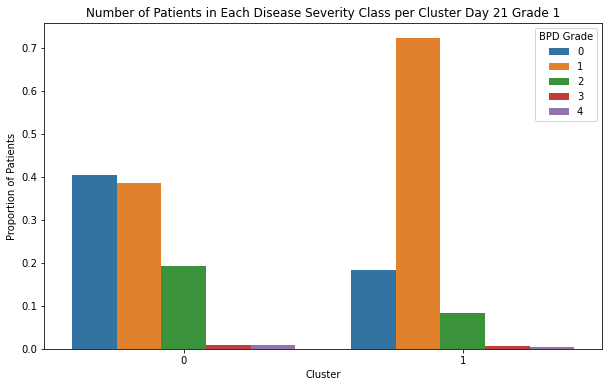

lr_d21g2_


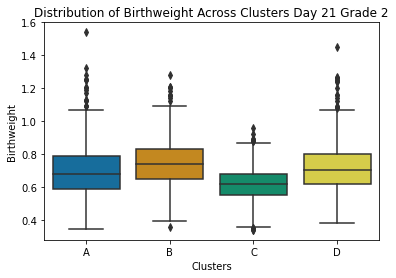

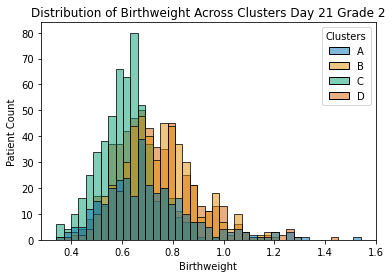

             Mean        SD
Cluster                    
A        0.704972  0.182554
B        0.747335  0.148627
C        0.617195  0.105565
D        0.726739  0.156418


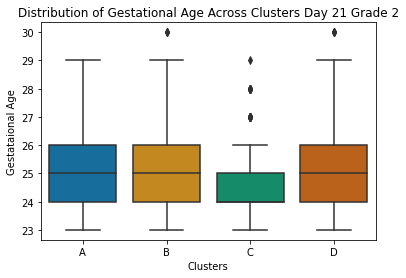

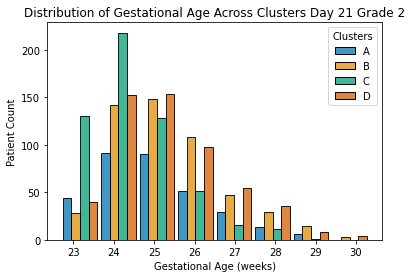

              Mean        SD
Cluster                     
A        24.978395  1.415142
B        25.319231  1.437864
C        24.354955  1.153455
D        25.248629  1.450140


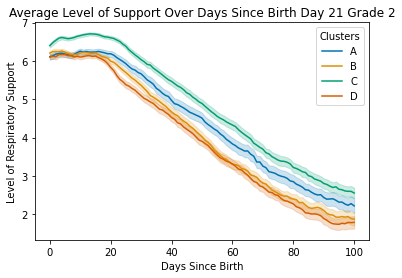

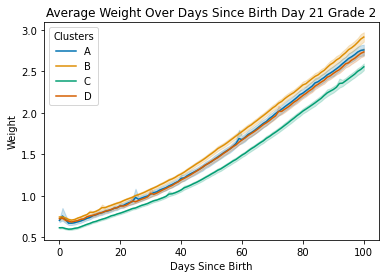

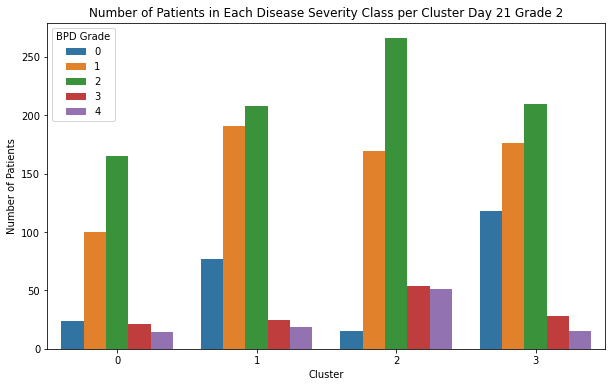

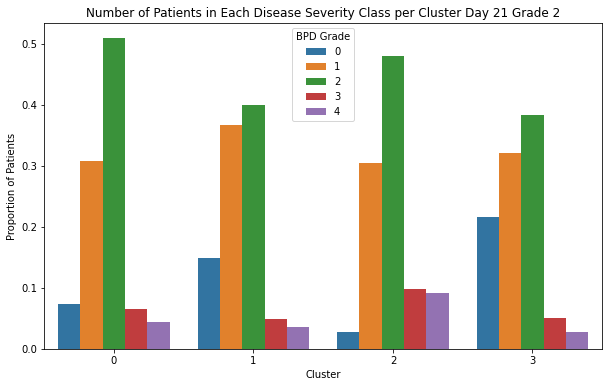

lr_d21g3_


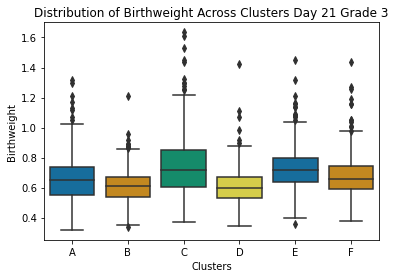

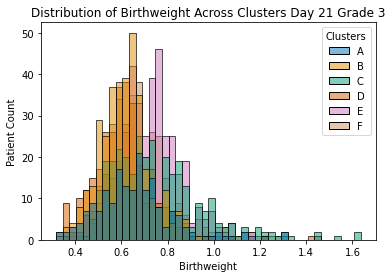

             Mean        SD
Cluster                    
A        0.662005  0.172805
B        0.613644  0.112224
C        0.754261  0.205522
D        0.608597  0.131364
E        0.725766  0.146895
F        0.678934  0.141058


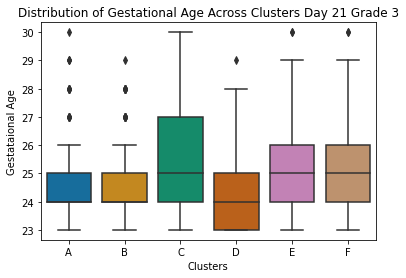

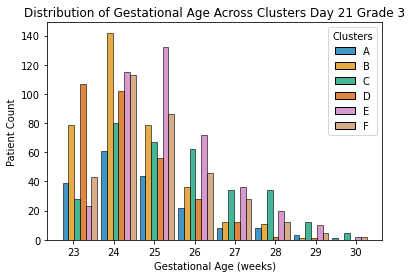

              Mean        SD
Cluster                     
A        24.677419  1.464250
B        24.436111  1.229320
C        25.524845  1.696892
D        24.175325  1.184224
E        25.226829  1.391473
F        24.907463  1.424898


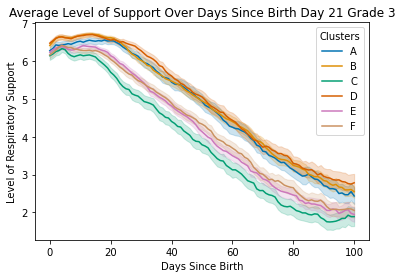

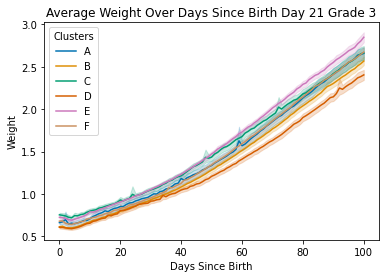

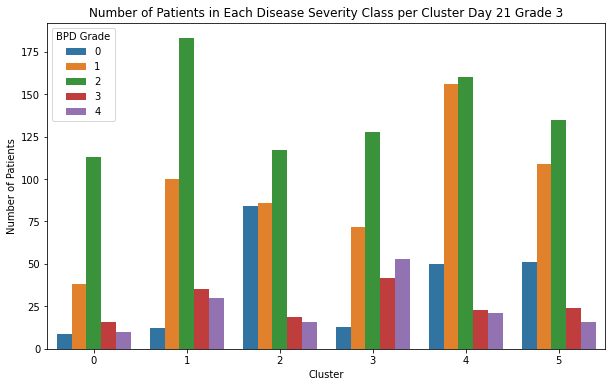

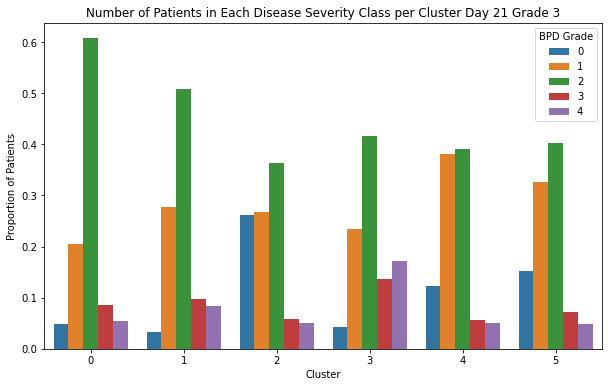

lr_d21g4_


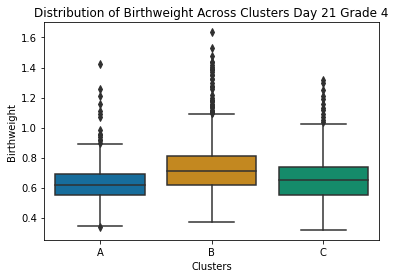

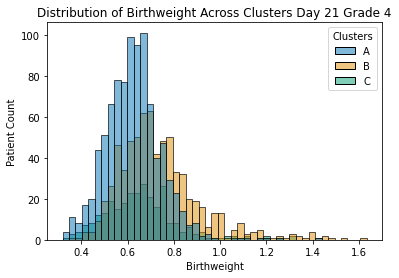

             Mean        SD
Cluster                    
A        0.624958  0.121384
B        0.738503  0.183704
C        0.661323  0.167114


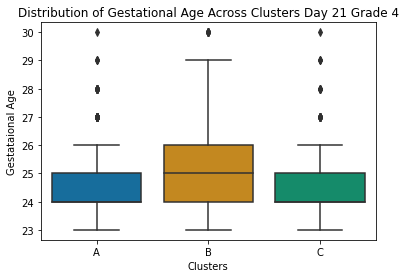

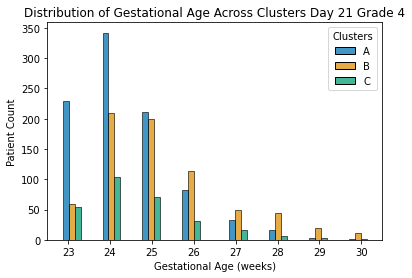

              Mean        SD
Cluster                     
A        24.362745  1.200784
B        25.212465  1.559292
C        24.600000  1.322077


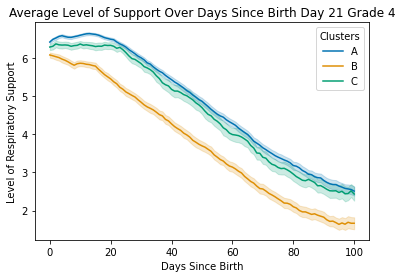

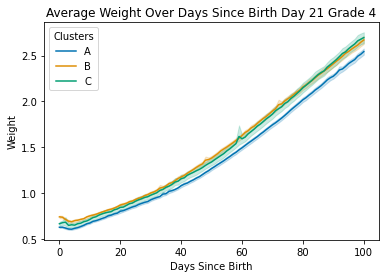

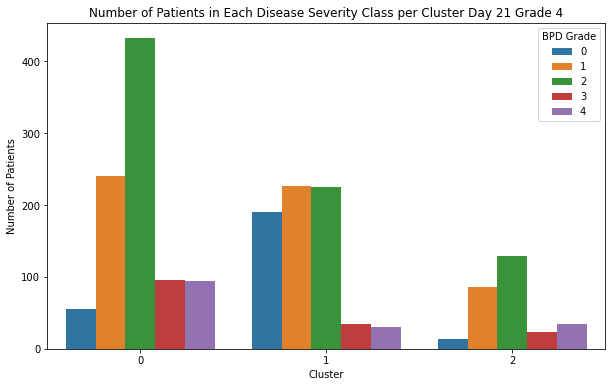

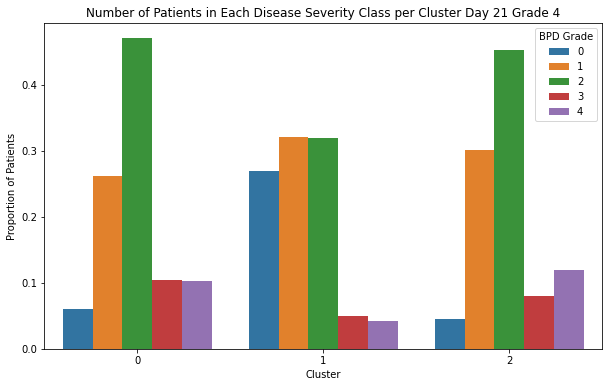

lr_d27g0_


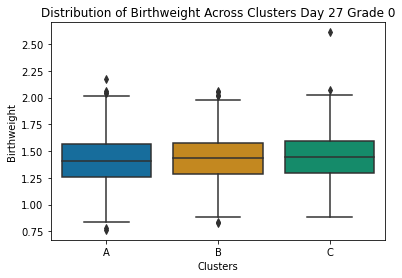

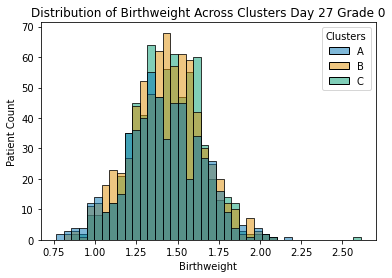

             Mean        SD
Cluster                    
A        1.413431  0.231945
B        1.431254  0.215363
C        1.443623  0.208983


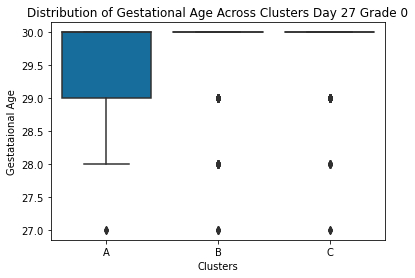

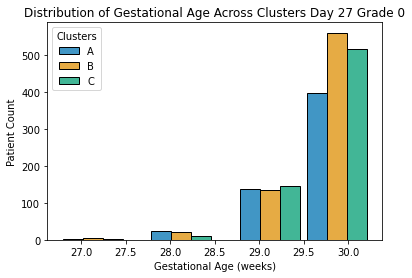

              Mean        SD
Cluster                     
A        29.655971  0.583405
B        29.727901  0.555865
C        29.743323  0.494539


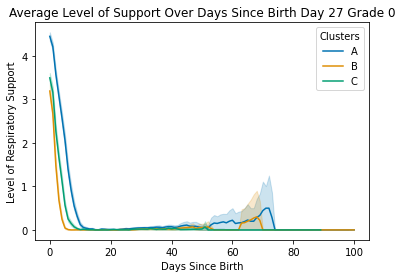

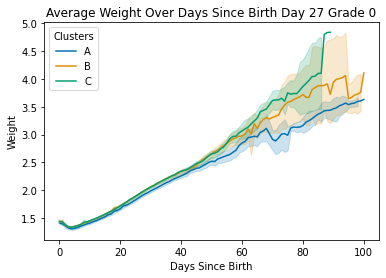

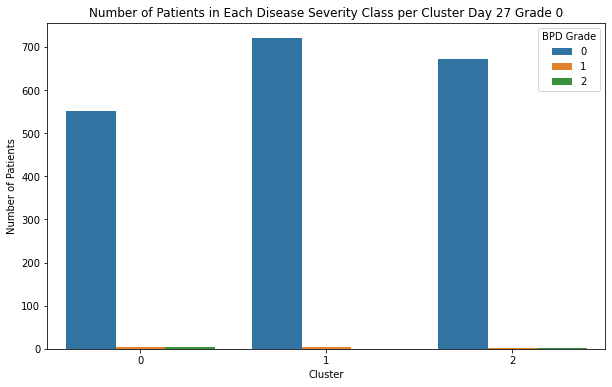

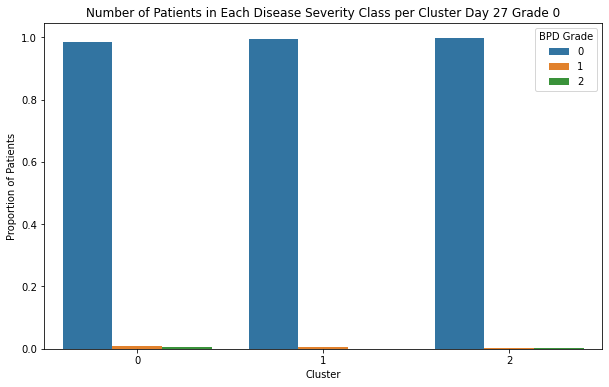

lr_d27g1_


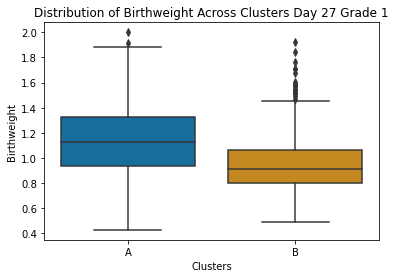

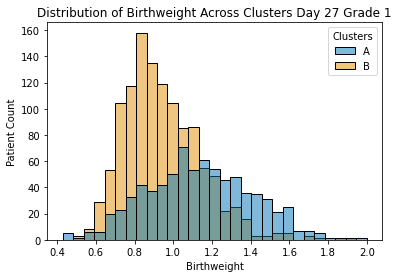

             Mean        SD
Cluster                    
A        1.134248  0.272421
B        0.941139  0.198911


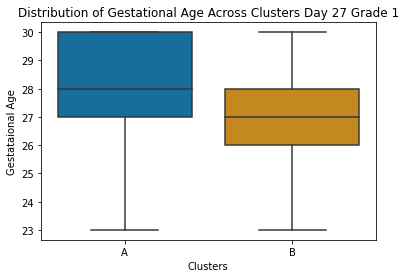

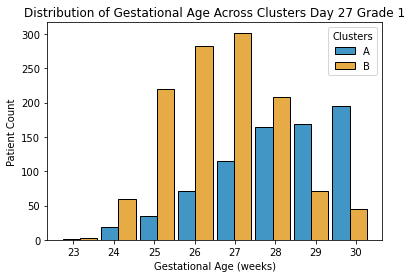

              Mean        SD
Cluster                     
A        28.156047  1.596413
B        26.642857  1.443996


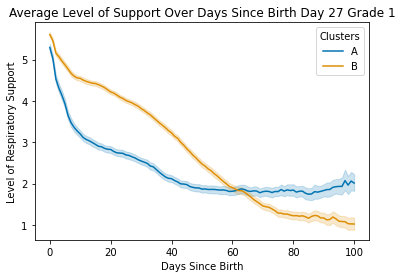

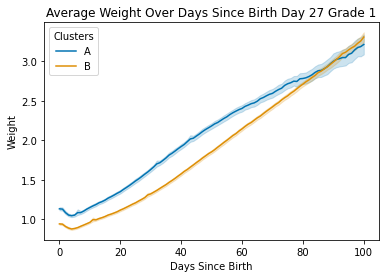

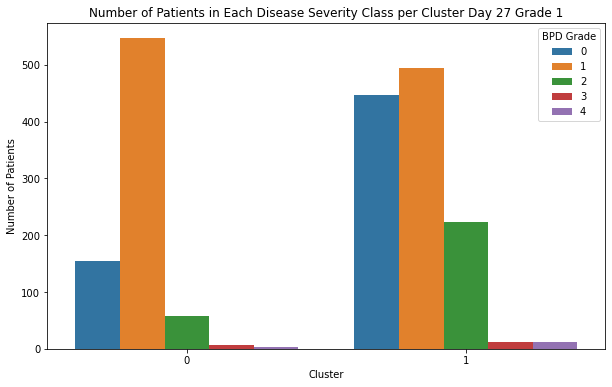

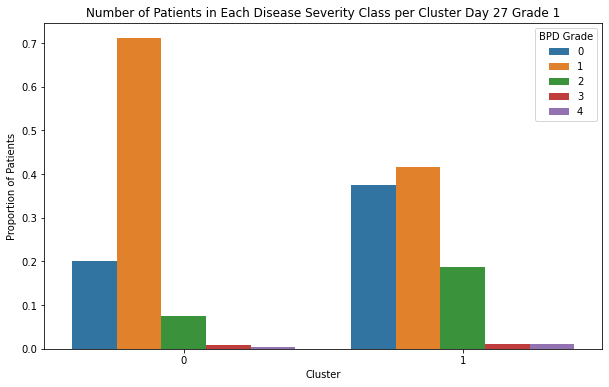

lr_d27g2_


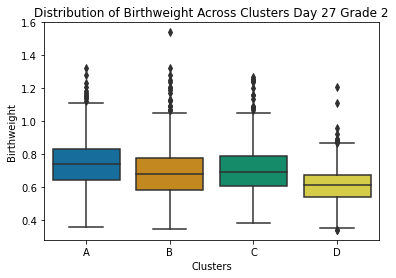

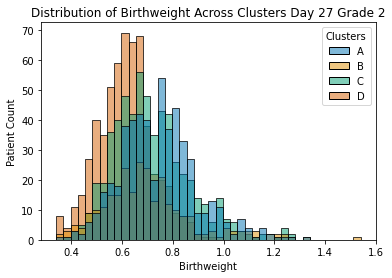

             Mean        SD
Cluster                    
A        0.743253  0.151236
B        0.701985  0.188588
C        0.712701  0.151382
D        0.613447  0.110573


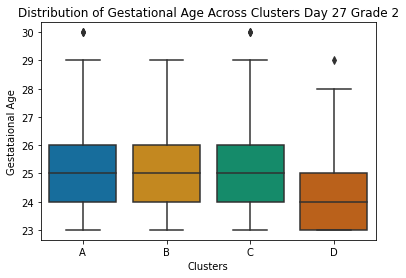

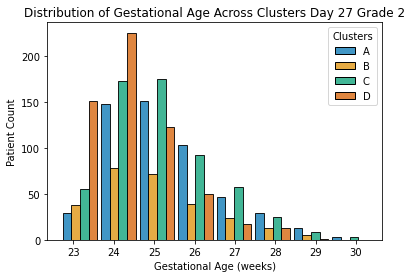

              Mean        SD
Cluster                     
A        25.273946  1.423565
B        24.970260  1.447801
C        25.076531  1.392090
D        24.310345  1.178490


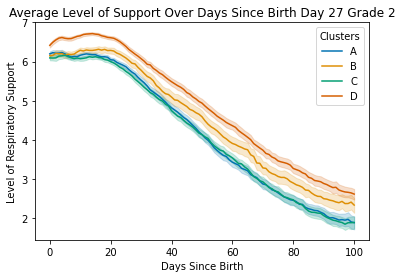

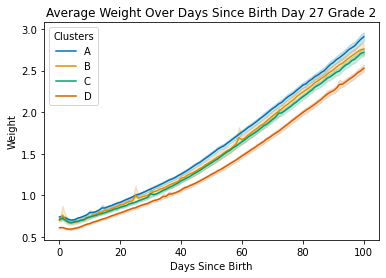

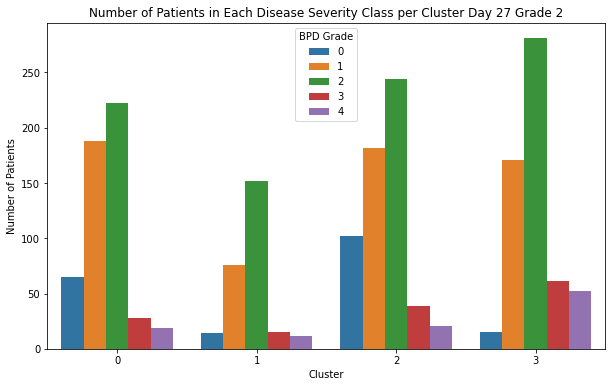

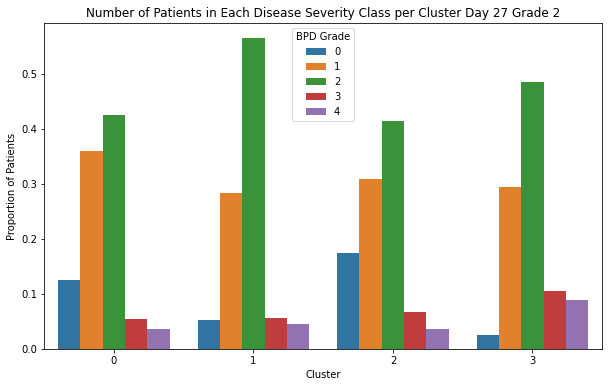

lr_d27g3_


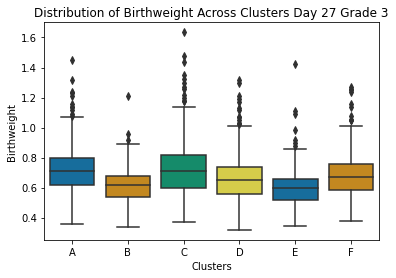

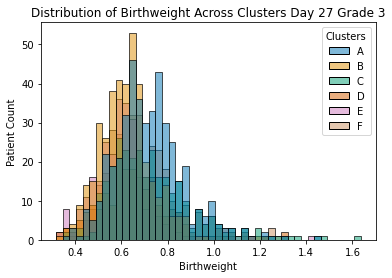

             Mean        SD
Cluster                    
A        0.721361  0.152865
B        0.617139  0.112803
C        0.733794  0.192134
D        0.667445  0.172932
E        0.602359  0.129035
F        0.691706  0.149435


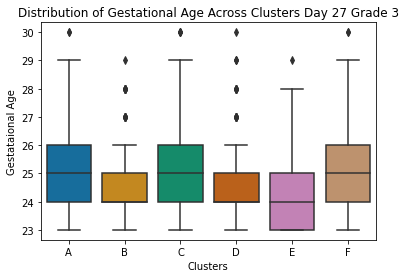

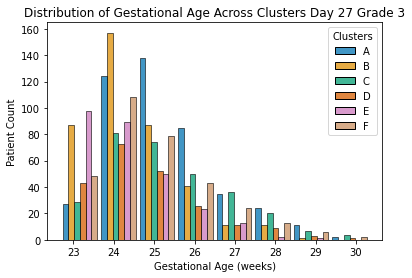

              Mean        SD
Cluster                     
A        25.230942  1.402416
B        24.415190  1.202692
C        25.302326  1.586914
D        24.692661  1.437497
E        24.181159  1.213473
F        24.876161  1.471306


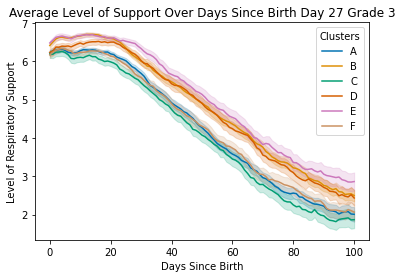

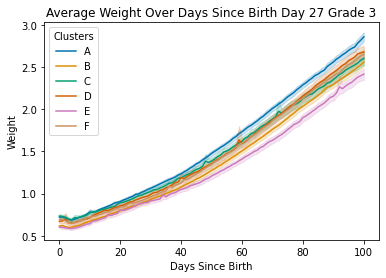

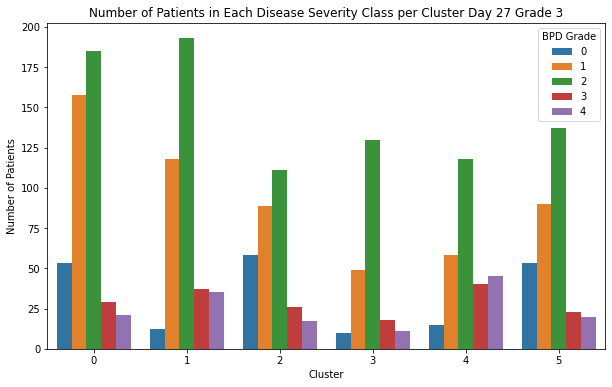

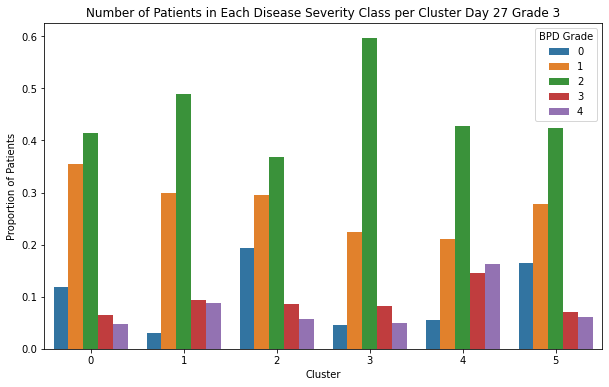

lr_d27g4_


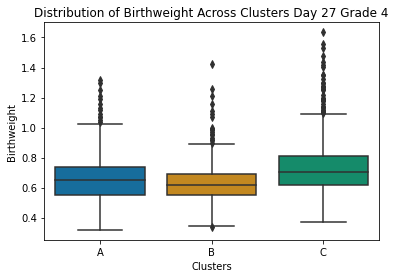

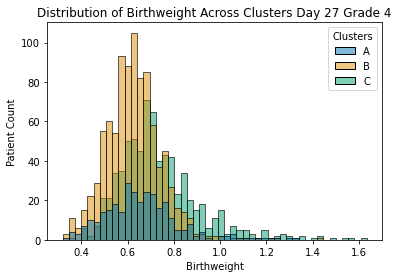

             Mean        SD
Cluster                    
A        0.660382  0.167257
B        0.626453  0.122554
C        0.734205  0.179991


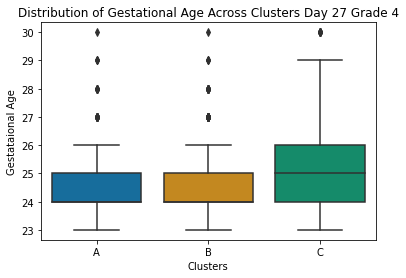

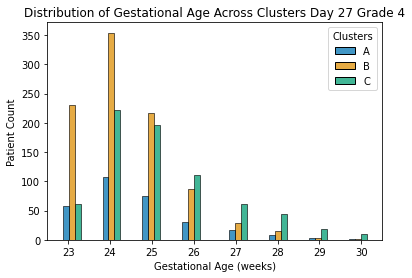

              Mean        SD
Cluster                     
A        24.607973  1.338831
B        24.348663  1.172643
C        25.197787  1.546471


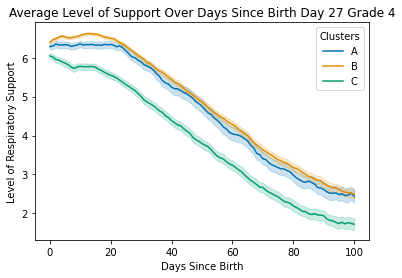

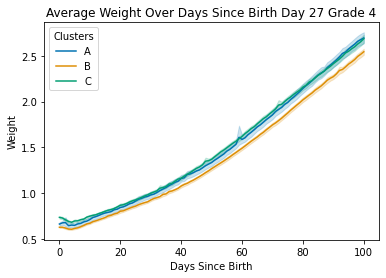

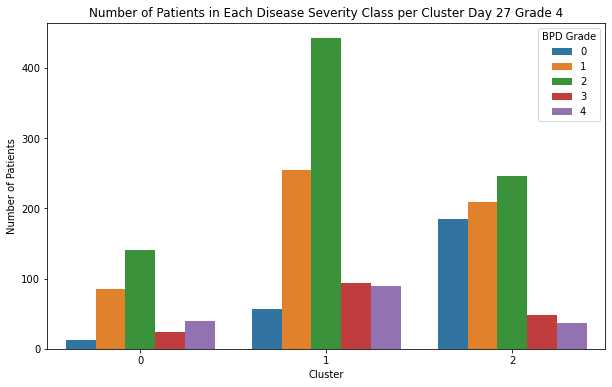

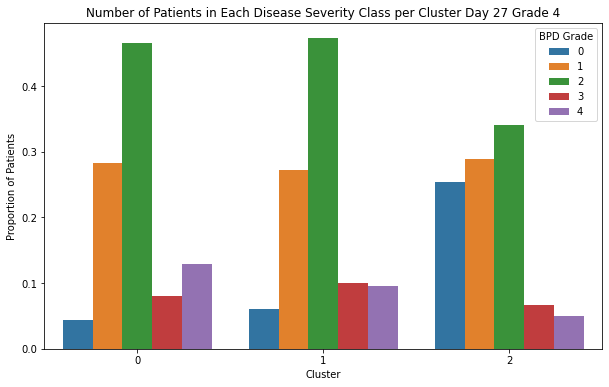

In [28]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']
days = [1, 3, 7, 14, 21, 27]
grades = [0, 1, 2, 3, 4]
categories = [f"Day {day} Grade {grade}" for day in days for grade in grades]
days_mapping = dict(zip(clusters, categories))
for cluster in clusters:
    curr_c_df = pd.read_csv(CDATA_DIR_PATH + cluster + c_suffix)
    num_clusters = len(list(set(curr_c_df['umap_KMeans'])))
    curr_df = curr_c_df.merge(pf_df).merge(dis_df)
    curr_ds_df = curr_c_df.merge(ds_df)
    curr_dw_df = curr_c_df.merge(dw_df)
    curr_labels = labels[0:num_clusters]
    identifier = days_mapping[cluster]
    print(cluster)
    # Birthweight
    g = sns.boxplot(data=curr_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
    g.set_xticks(range(len(curr_labels)))
    g.set_xticklabels(curr_labels)
    plt.title('Distribution of Birthweight Across Clusters ' + identifier)
    plt.xlabel('Clusters')
    plt.ylabel('Birthweight')

    fig, ax1 = plt.subplots()
    sp1 = sns.histplot(data=curr_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                       multiple='layer',
                      )
    ax1.set_title('Distribution of Birthweight Across Clusters ' + identifier)
    ax1.set_ylabel('Patient Count')
    ax1.set_xlabel('Birthweight')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
    plt.show()

    bw_means = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
    bw_means = list(bw_means['BirthWeight'])
    bw_sds = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
    bw_sds = list(bw_sds['BirthWeight'])
    bw = pd.DataFrame({'Cluster': curr_labels, 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
    print(bw)
    # Gestational Age
    g = sns.boxplot(data=curr_df, x='umap_KMeans', y='GestAge', palette='colorblind')
    g.set_xticks(range(len(curr_labels)))
    g.set_xticklabels(curr_labels)
    plt.title('Distribution of Gestational Age Across Clusters ' + identifier)
    plt.xlabel('Clusters')
    plt.ylabel('Gestataional Age')

    fig, ax1 = plt.subplots()
    sp1 = sns.histplot(data=curr_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                      shrink=2.7)
    ax1.set_title('Distribution of Gestational Age Across Clusters ' + identifier)
    ax1.set_ylabel('Patient Count')
    ax1.set_xlabel('Gestational Age (weeks)')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
    plt.show()

    ga_means = curr_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
    ga_means = list(ga_means['GestAge'])
    ga_sds = curr_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
    ga_sds = list(ga_sds['GestAge'])
    ga = pd.DataFrame({'Cluster': curr_labels, 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
    print(ga)

    # Support Type Trajectory
    fig, ax1 = plt.subplots()
    sp1 = sns.lineplot(data=curr_ds_df.loc[curr_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                       hue='umap_KMeans', palette = 'colorblind', ax=ax1)
    ax1.set_title('Average Level of Support Over Days Since Birth ' + identifier)
    ax1.set_ylabel('Level of Respiratory Support')
    ax1.set_xlabel('Days Since Birth')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')
  

    # try to add weight too
    # Support Type Trajectory
    fig, ax1 = plt.subplots()
    sp1 = sns.lineplot(data=curr_dw_df.loc[curr_dw_df['Daily_DSB'] <= 100], x='Daily_DSB', y='Weight', 
                       hue='umap_KMeans', palette = 'colorblind', ax=ax1)
    ax1.set_title('Average Weight Over Days Since Birth ' + identifier)
    ax1.set_ylabel('Weight')
    ax1.set_xlabel('Days Since Birth')
    legend = ax1.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax1.legend(handles, curr_labels, title='Clusters')

    
    # Purity Analysis
    grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
    plt.title('Number of Patients in Each Disease Severity Class per Cluster ' + identifier)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Patients')
    plt.show()
    
    
    # Calculate total counts for each 'umap_KMeans'
    totals = curr_df.groupby('umap_KMeans').size().reset_index(name='total_counts')

    # Calculate counts for each combination of 'umap_KMeans' and 'BPD Grade'
    grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')

    # Merge the total counts into grouped DataFrame
    grouped = pd.merge(grouped, totals, on='umap_KMeans')

    # Calculate normalized counts
    grouped['normalized_counts'] = grouped['counts'] / grouped['total_counts']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='umap_KMeans', y='normalized_counts', hue='BPD Grade', data=grouped)
    plt.title('Number of Patients in Each Disease Severity Class per Cluster ' + identifier)
    plt.xlabel('Cluster')
    plt.ylabel('Proportion of Patients')  # Update y label
    plt.show()
    

In [18]:
g3_clusters = ['lr_d1g3_', 'lr_d3g3_', 'lr_d7g3_', 'lr_d14g3_', 'lr_d21g3_', 'lr_d27g3_']
mr_suffix = 'mr_df.csv'
for cluster in g3_clusters:
    print(days_mapping[cluster])
    curr_c_df = pd.read_csv(CDATA_DIR_PATH + cluster + c_suffix)
    curr_mr_df = pd.read_csv(RDATA_DIR_PATH + cluster + mr_suffix)
    merged = curr_c_df.merge(curr_mr_df.loc[:, ['PatientSeqID', 'grade_3_prob']])
    print(merged.groupby('umap_KMeans').mean())
    print('\n')
#     for c in list(set(curr_c_df['umap_KMeans'])):
#         merged.loc[merged['umap_KMeans'] == c]

Day 1 Grade 3
             PatientSeqID  grade_3_prob
umap_KMeans                            
0            5.796049e+06      0.068101
1            5.828598e+06      0.068055


Day 3 Grade 3
             PatientSeqID  grade_3_prob
umap_KMeans                            
0            5.853621e+06      0.074844
1            5.828714e+06      0.076510


Day 7 Grade 3
             PatientSeqID  grade_3_prob
umap_KMeans                            
0            5.838873e+06      0.094131
1            5.842149e+06      0.090262


Day 14 Grade 3
             PatientSeqID  grade_3_prob
umap_KMeans                            
0            5.948300e+06      0.100323
1            5.792631e+06      0.097854
2            5.747356e+06      0.110969
3            5.816948e+06      0.098397
4            5.844341e+06      0.115445
5            5.908074e+06      0.106935


Day 21 Grade 3
             PatientSeqID  grade_3_prob
umap_KMeans                            
0            5.894909e+06      0.113629


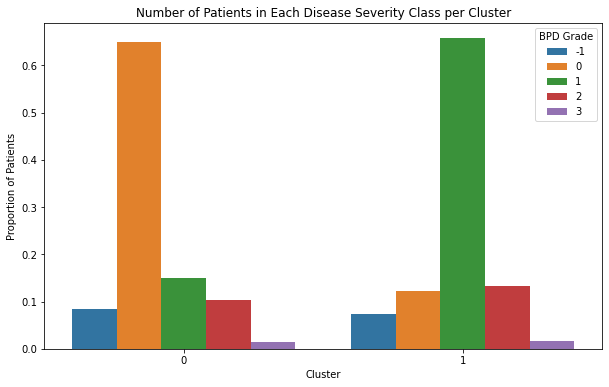

In [21]:
# Calculate total counts for each 'umap_KMeans'
totals = curr_df.groupby('umap_KMeans').size().reset_index(name='total_counts')

# Calculate counts for each combination of 'umap_KMeans' and 'BPD Grade'
grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')

# Merge the total counts into grouped DataFrame
grouped = pd.merge(grouped, totals, on='umap_KMeans')

# Calculate normalized counts
grouped['normalized_counts'] = grouped['counts'] / grouped['total_counts']

plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='normalized_counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Patients')  # Update y label
plt.show()


In [10]:
# Birthweight
g = sns.boxplot(data=curr_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(curr_labels)
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=curr_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, curr_labels, title='Clusters')
plt.show()

bw_means = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = curr_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': curr_labels, 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=curr_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(curr_labels)
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=curr_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, curr_labels, title='Clusters')
plt.show()

ga_means = curr_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g3_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': curr_labels, 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=curr_ds_df.loc[curr_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, curr_labels, title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = curr_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


SyntaxError: invalid syntax (<ipython-input-10-ce342a50a384>, line 7)

## day 14

In [5]:
# day 14 cluster dfs
t27g_d14g0_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d14g0_c_df.csv')
t27g_d14g1_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d14g1_c_df.csv')
t27g_d14g2_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d14g2_c_df.csv')
t27g_d14g3_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d14g3_c_df.csv')
t27g_d14g4_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d14g4_c_df.csv')

In [58]:
# day 14 risk dfs
t27g_d14g0_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d14g0_mr_df.csv')
t27g_d14g1_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d14g1_mr_df.csv')
t27g_d14g2_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d14g2_mr_df.csv')
t27g_d14g3_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d14g3_mr_df.csv')
t27g_d14g4_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d14g4_mr_df.csv')


In [69]:
# finding average risks
pd.set_option('display.float_format', '{:.3f}'.format)
for df in [t27g_d14g0_mrdf, t27g_d14g1_mrdf, t27g_d14g2_mrdf, t27g_d14g3_mrdf, t27g_d14g4_mrdf]:
    print(df.mean()*100)

PatientSeqID        576805266.916
DSB                      1400.000
Label                       3.986
grade_0_prob               99.009
grade_1_prob                0.812
grade_2_prob                0.063
grade_3_prob                0.073
grade_minus1_prob           0.043
dtype: float64
PatientSeqID        585311009.816
DSB                      1400.000
Label                     169.158
grade_0_prob               27.180
grade_1_prob               49.505
grade_2_prob               18.129
grade_3_prob                2.387
grade_minus1_prob           2.799
dtype: float64
PatientSeqID        585796149.327
DSB                      1400.000
Label                     306.129
grade_0_prob                6.521
grade_1_prob               25.205
grade_2_prob               44.637
grade_3_prob                9.342
grade_minus1_prob          14.295
dtype: float64
PatientSeqID        583846718.635
DSB                      1400.000
Label                     344.395
grade_0_prob                6.261
gra

### Grade 0

In [29]:
t27g_d14g0_pf_df = t27g_d14g0_cdf.merge(pf_df).merge(dis_df)
# t27g_d14g0_ds_df = t27g_d14g0_cdf.merge(ds_df)
# t27g_d14g0_dm_df = t27g_d14g0_cdf.merge(dm_df)

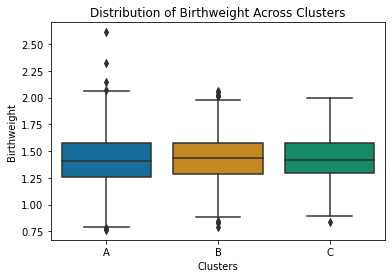

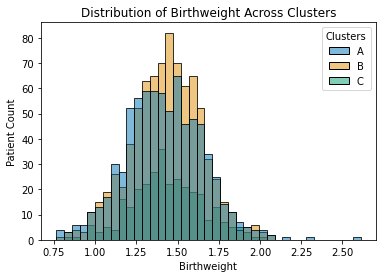

             Mean        SD
Cluster                    
B1       1.417426  0.237900
B2       1.431086  0.214685
B3       1.438000  0.212012


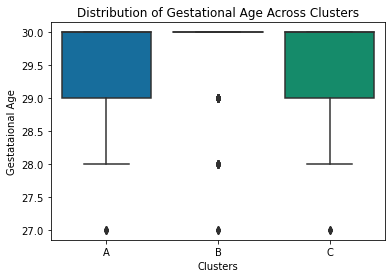

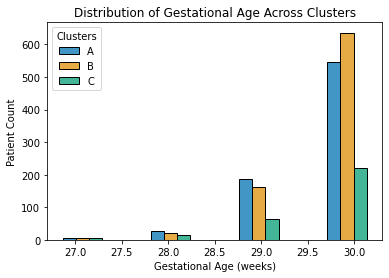

              Mean        SD
Cluster                     
B1       29.659269  0.587527
B2       29.736330  0.528718
B3       29.657807  0.631807


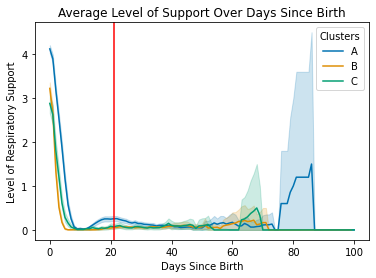

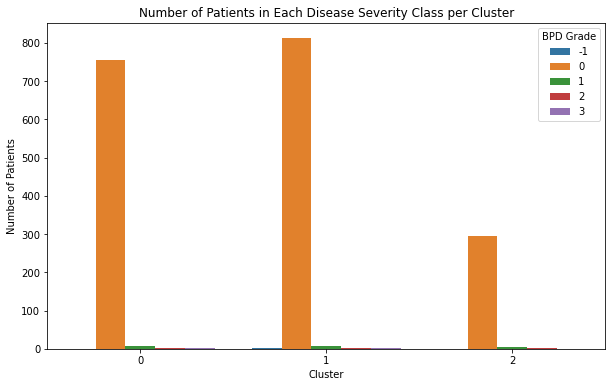

In [40]:
# Birthweight
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(3))
g.set_xticklabels(['A', 'B', 'C'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
plt.show()

bw_means = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(3))
g.set_xticklabels(['A', 'B', 'C'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
plt.show()

ga_means = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d14g0_ds_df.loc[t27g_d14g0_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d14g0_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 1

In [16]:
t27g_d14g1_cdf['umap_KMeans'].value_counts()

0    1380
1     601
Name: umap_KMeans, dtype: int64

In [42]:
t27g_d14g1_pf_df = t27g_d14g1_cdf.merge(pf_df).merge(dis_df)
t27g_d14g1_ds_df = t27g_d14g1_cdf.merge(ds_df)

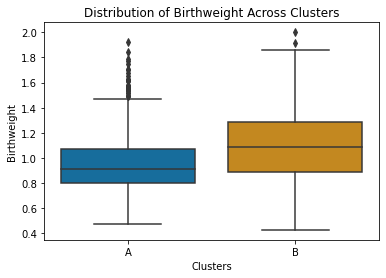

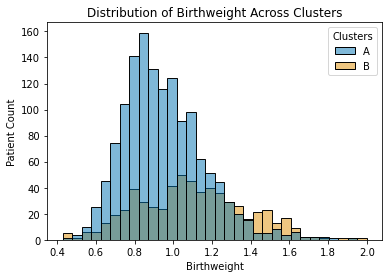

             Mean        SD
Cluster                    
A        0.948038  0.208533
B        1.098020  0.275678


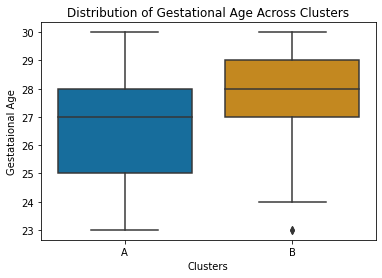

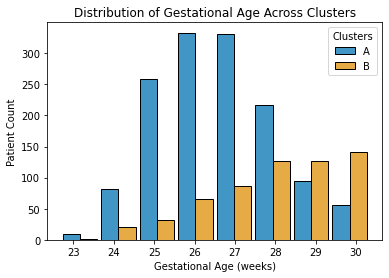

              Mean        SD
Cluster                     
A        26.595652  1.503772
B        28.006656  1.683238


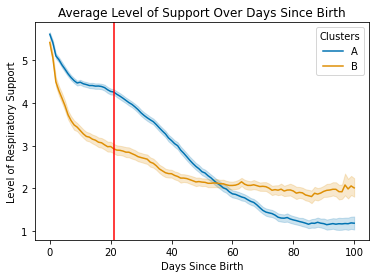

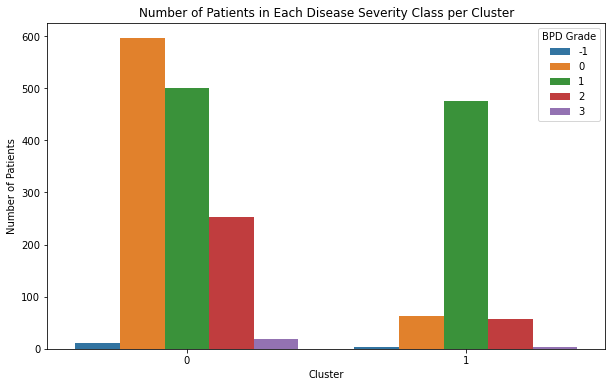

In [43]:
# Birthweight
g = sns.boxplot(data=t27g_d14g1_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g1_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d14g1_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g1_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d14g1_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g1_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d14g1_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g1_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d14g1_ds_df.loc[t27g_d14g1_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d14g1_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 2

In [44]:
t27g_d14g2_cdf['umap_KMeans'].value_counts()

0    1560
1     356
Name: umap_KMeans, dtype: int64

In [45]:
t27g_d14g2_pf_df = t27g_d14g2_cdf.merge(pf_df).merge(dis_df)
t27g_d14g2_ds_df = t27g_d14g2_cdf.merge(ds_df)

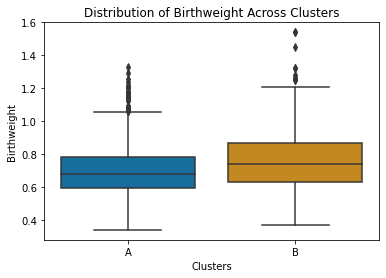

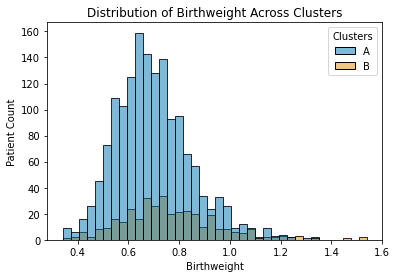

             Mean        SD
Cluster                    
A        0.695693  0.149038
B        0.766764  0.193494


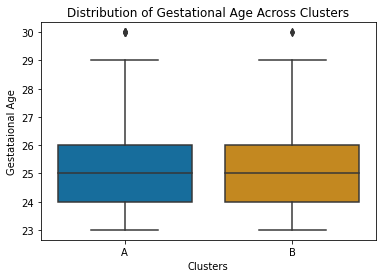

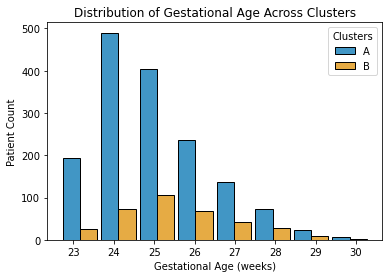

              Mean        SD
Cluster                     
A        24.982051  1.440613
B        25.449438  1.493733


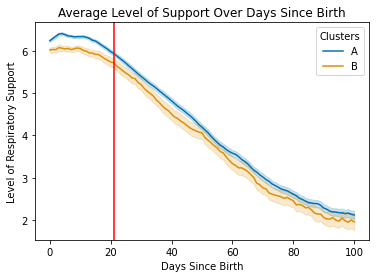

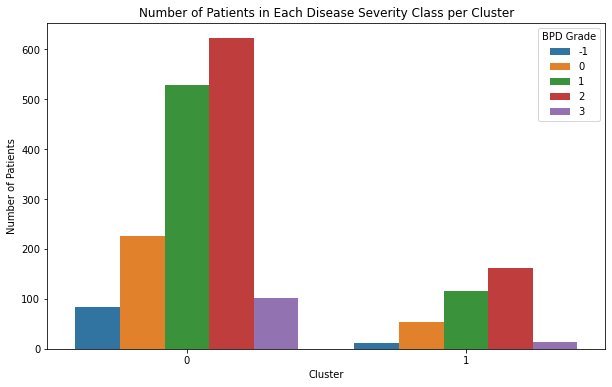

In [47]:
# Birthweight
g = sns.boxplot(data=t27g_d14g2_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g2_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d14g2_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g2_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d14g2_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g2_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d14g2_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g2_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d14g2_ds_df.loc[t27g_d14g2_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d14g2_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 3


In [48]:
t27g_d14g3_cdf['umap_KMeans'].value_counts()

0    1545
1     309
Name: umap_KMeans, dtype: int64

In [49]:
t27g_d14g3_pf_df = t27g_d14g3_cdf.merge(pf_df).merge(dis_df)
t27g_d14g3_ds_df = t27g_d14g3_cdf.merge(ds_df)

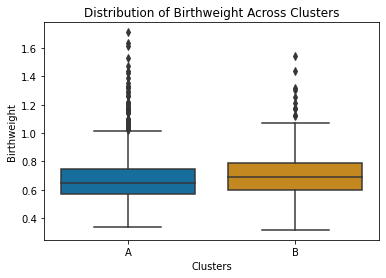

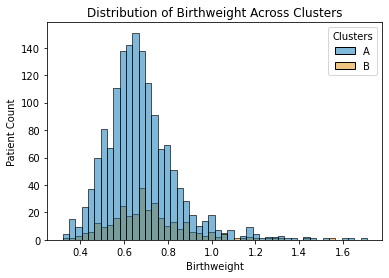

             Mean        SD
Cluster                    
A        0.673071  0.163741
B        0.710440  0.179174


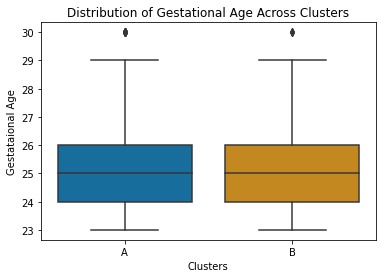

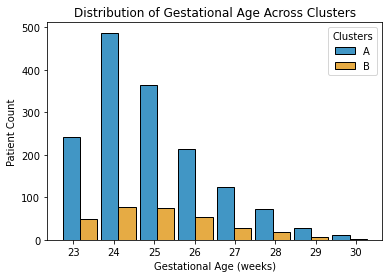

              Mean        SD
Cluster                     
A        24.924272  1.519336
B        25.103560  1.583894


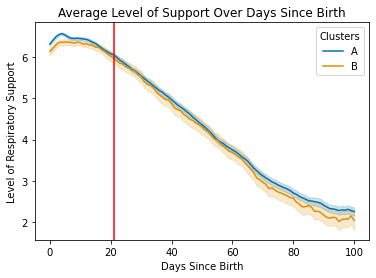

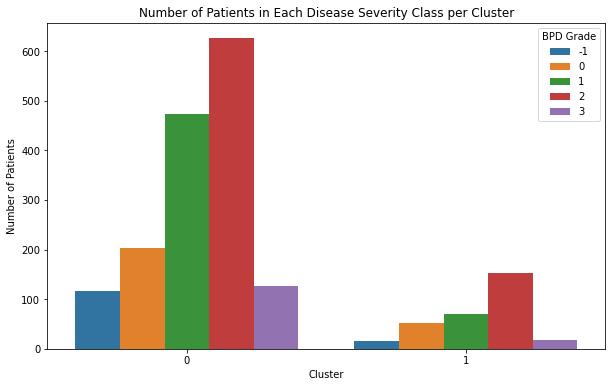

In [50]:
# Birthweight
g = sns.boxplot(data=t27g_d14g3_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g3_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d14g3_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g3_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d14g3_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g3_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d14g3_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g3_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d14g3_ds_df.loc[t27g_d14g3_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d14g3_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade -1/4

In [51]:
t27g_d14g4_cdf['umap_KMeans'].value_counts()

0    1477
1     345
Name: umap_KMeans, dtype: int64

In [53]:
t27g_d14g4_pf_df = t27g_d14g4_cdf.merge(pf_df).merge(dis_df)
t27g_d14g4_ds_df = t27g_d14g4_cdf.merge(ds_df)

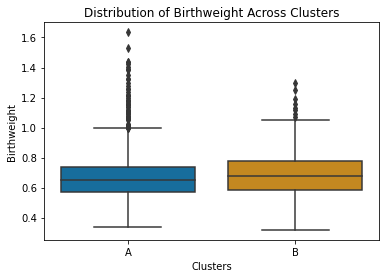

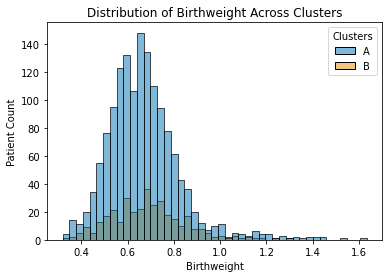

             Mean        SD
Cluster                    
A        0.667446  0.157161
B        0.686693  0.160699


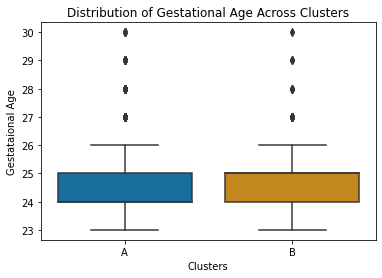

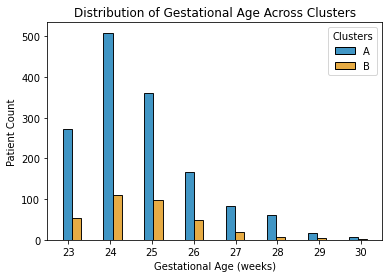

              Mean        SD
Cluster                     
A        24.706161  1.422924
B        24.785507  1.359856


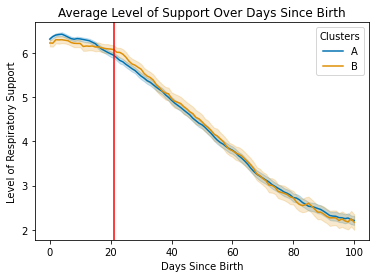

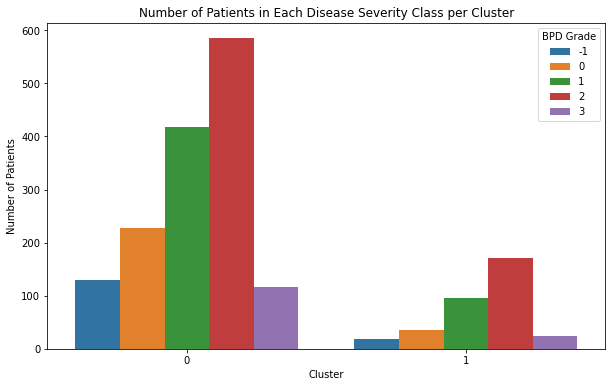

In [54]:
# Birthweight
g = sns.boxplot(data=t27g_d14g4_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g4_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d14g4_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g4_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d14g4_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g4_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d14g4_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d14g4_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d14g4_ds_df.loc[t27g_d14g4_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d14g4_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


## day 27

In [70]:
# day 27 cluster dfs
t27g_d27g0_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d27g0_c_df.csv')
t27g_d27g1_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d27g1_c_df.csv')
t27g_d27g2_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d27g2_c_df.csv')
t27g_d27g3_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d27g3_c_df.csv')
t27g_d27g4_cdf = pd.read_csv(CDATA_DIR_PATH + 't27g_d27g4_c_df.csv')

In [71]:
# day 27 risk dfs
t27g_d27g0_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d27g0_mr_df.csv')
t27g_d27g1_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d27g1_mr_df.csv')
t27g_d27g2_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d27g2_mr_df.csv')
t27g_d27g3_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d27g3_mr_df.csv')
t27g_d27g4_mrdf = pd.read_csv(RDATA_DIR_PATH + 't27g_d27g4_mr_df.csv')


In [72]:
# finding average risks
pd.set_option('display.float_format', '{:.3f}'.format)
for df in [t27g_d27g0_mrdf, t27g_d27g1_mrdf, t27g_d27g2_mrdf, t27g_d27g3_mrdf, t27g_d27g4_mrdf]:
    print(df.mean()*100)

PatientSeqID        578858330.628
DSB                      2700.000
Label                       1.889
grade_0_prob               99.307
grade_1_prob                0.549
grade_2_prob                0.043
grade_3_prob                0.071
grade_minus1_prob           0.030
dtype: float64
PatientSeqID        583704470.189
DSB                      2700.000
Label                     164.727
grade_0_prob               27.396
grade_1_prob               54.712
grade_2_prob               14.847
grade_3_prob                1.664
grade_minus1_prob           1.380
dtype: float64
PatientSeqID        584092482.338
DSB                      2700.000
Label                     306.840
grade_0_prob                5.551
grade_1_prob               24.992
grade_2_prob               49.468
grade_3_prob                9.940
grade_minus1_prob          10.049
dtype: float64
PatientSeqID        581156736.192
DSB                      2700.000
Label                     325.676
grade_0_prob                5.646
gra

### Grade 0

In [73]:
t27g_d27g0_pf_df = t27g_d27g0_cdf.merge(pf_df).merge(dis_df)
t27g_d27g0_ds_df = t27g_d27g0_cdf.merge(ds_df)


In [78]:
t27g_d27g0_cdf['umap_KMeans'].value_counts()

0    899
1    804
2    256
Name: umap_KMeans, dtype: int64

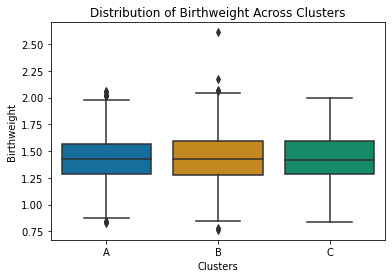

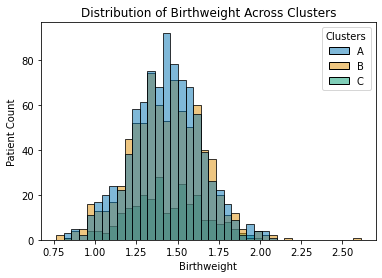

         Mean    SD
Cluster            
A       1.428 0.212
B       1.430 0.225
C       1.439 0.218


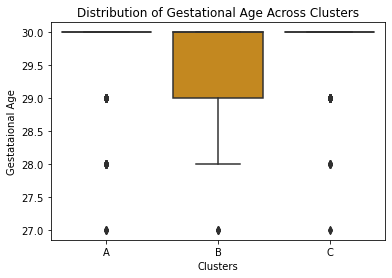

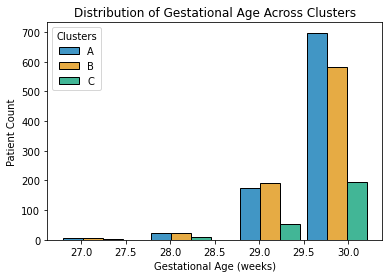

          Mean    SD
Cluster             
A       29.741 0.524
B       29.682 0.561
C       29.711 0.562


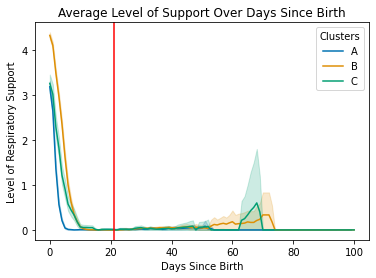

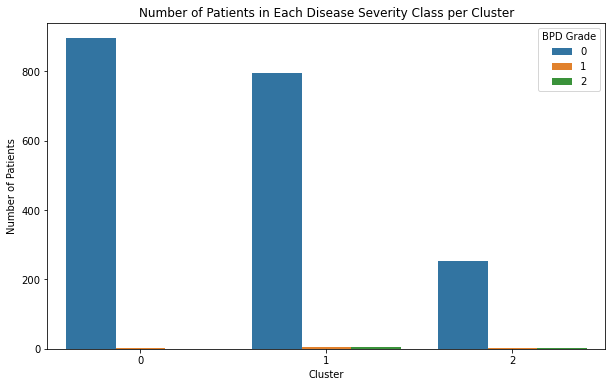

In [80]:
# Birthweight
g = sns.boxplot(data=t27g_d27g0_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(3))
g.set_xticklabels(['A', 'B', 'C'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g0_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
plt.show()

bw_means = t27g_d27g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d27g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B', 'C'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')

print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d27g0_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(3))
g.set_xticklabels(['A', 'B', 'C'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g0_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
plt.show()

ga_means = t27g_d27g0_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d27g0_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B', 'C'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d27g0_ds_df.loc[t27g_d27g0_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d27g0_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 1

In [81]:
t27g_d27g1_cdf['umap_KMeans'].value_counts()

1    1368
0     591
Name: umap_KMeans, dtype: int64

In [82]:
t27g_d27g1_pf_df = t27g_d27g1_cdf.merge(pf_df).merge(dis_df)
t27g_d27g1_ds_df = t27g_d27g1_cdf.merge(ds_df)

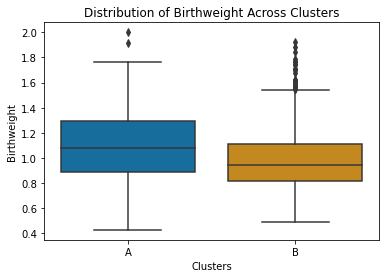

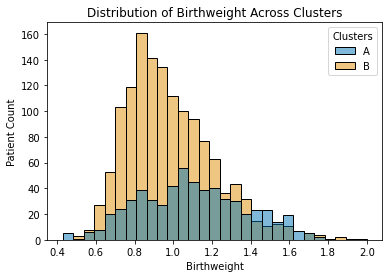

         Mean    SD
Cluster            
A       1.101 0.279
B       0.981 0.226


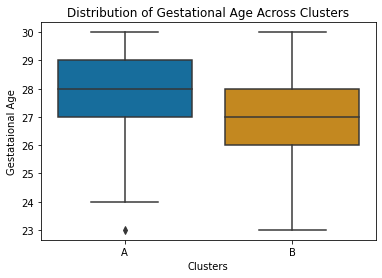

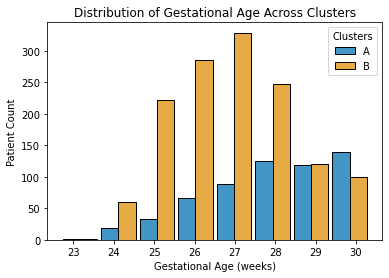

          Mean    SD
Cluster             
A       28.002 1.670
B       26.906 1.569


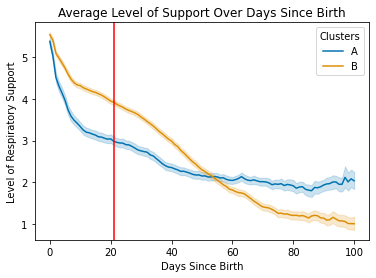

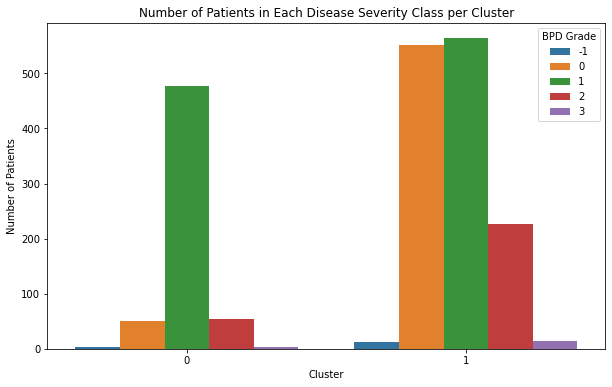

In [83]:
# Birthweight
g = sns.boxplot(data=t27g_d27g1_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g1_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d27g1_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d27g1_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d27g1_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g1_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d27g1_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d27g1_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d27g1_ds_df.loc[t27g_d27g1_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d27g1_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 2

In [84]:
t27g_d27g2_cdf['umap_KMeans'].value_counts()

0    1590
1     369
Name: umap_KMeans, dtype: int64

In [85]:
t27g_d27g2_pf_df = t27g_d27g2_cdf.merge(pf_df).merge(dis_df)
t27g_d27g2_ds_df = t27g_d27g2_cdf.merge(ds_df)

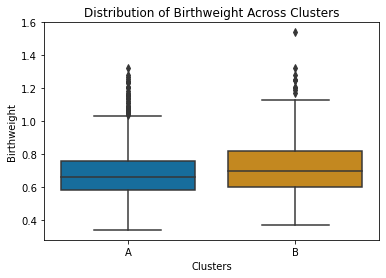

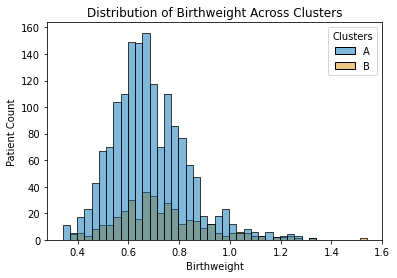

         Mean    SD
Cluster            
A       0.681 0.148
B       0.728 0.179


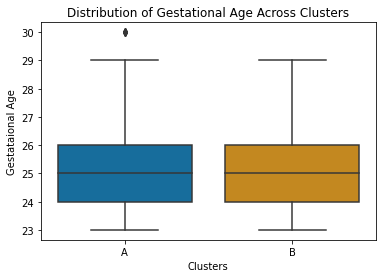

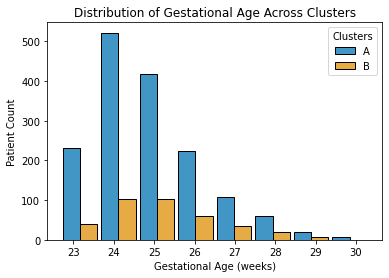

          Mean    SD
Cluster             
A       24.840 1.393
B       25.092 1.428


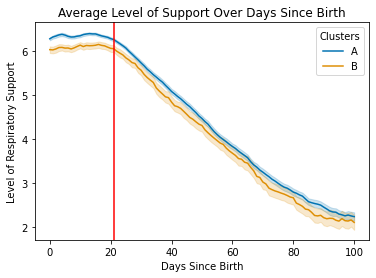

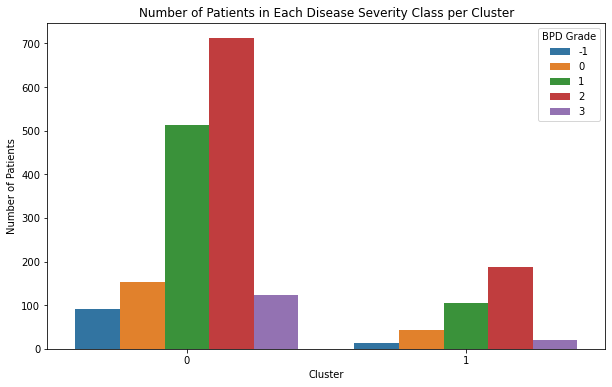

In [86]:
# Birthweight
g = sns.boxplot(data=t27g_d27g2_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g2_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d27g2_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d27g2_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d27g2_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g2_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d27g2_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d27g2_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d27g2_ds_df.loc[t27g_d27g2_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d27g2_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade 3


In [87]:
t27g_d27g3_cdf['umap_KMeans'].value_counts()

0    1686
1     273
Name: umap_KMeans, dtype: int64

In [88]:
t27g_d27g3_pf_df = t27g_d27g3_cdf.merge(pf_df).merge(dis_df)
t27g_d27g3_ds_df = t27g_d27g3_cdf.merge(ds_df)

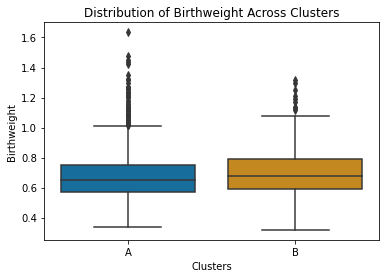

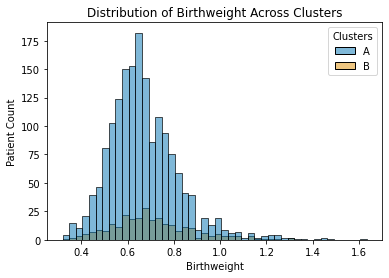

         Mean    SD
Cluster            
A       0.670 0.155
B       0.702 0.178


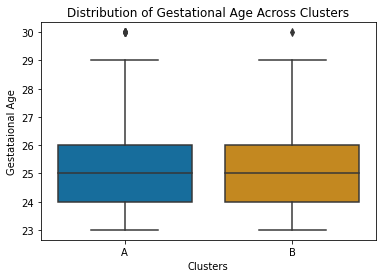

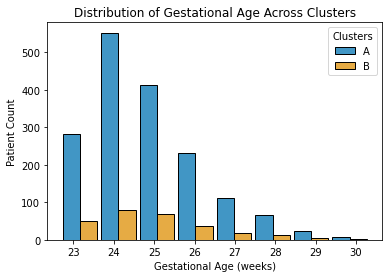

          Mean    SD
Cluster             
A       24.801 1.431
B       24.875 1.519


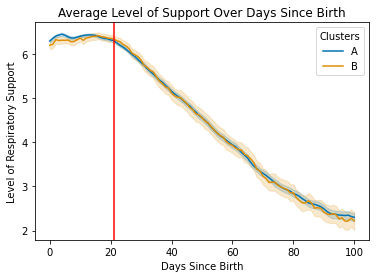

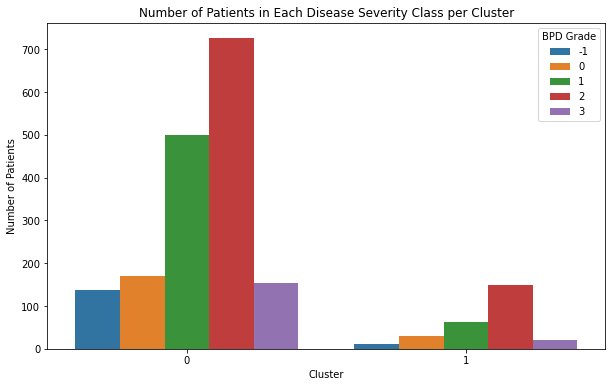

In [90]:
# Birthweight
g = sns.boxplot(data=t27g_d27g3_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g3_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d27g3_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d27g3_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d27g3_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g3_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d27g3_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d27g3_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d27g3_ds_df.loc[t27g_d27g3_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d27g3_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


### grade -1/4

In [91]:
t27g_d27g4_cdf['umap_KMeans'].value_counts()

0    1595
1     364
Name: umap_KMeans, dtype: int64

In [92]:
t27g_d27g4_pf_df = t27g_d27g4_cdf.merge(pf_df).merge(dis_df)
t27g_d27g4_ds_df = t27g_d27g4_cdf.merge(ds_df)

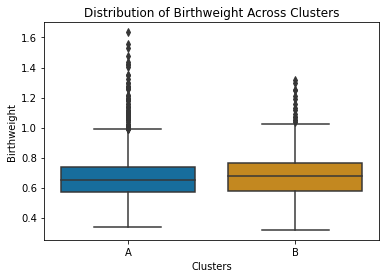

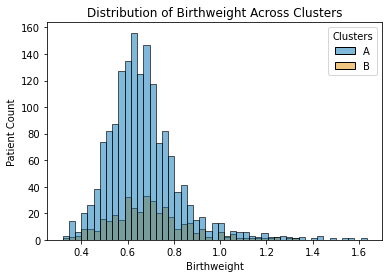

         Mean    SD
Cluster            
A       0.668 0.159
B       0.688 0.167


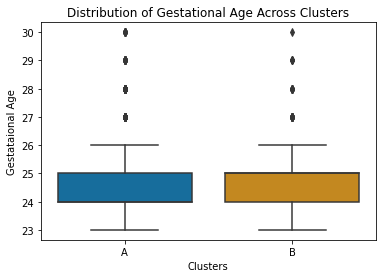

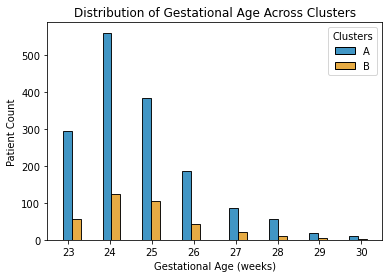

          Mean    SD
Cluster             
A       24.693 1.418
B       24.739 1.326


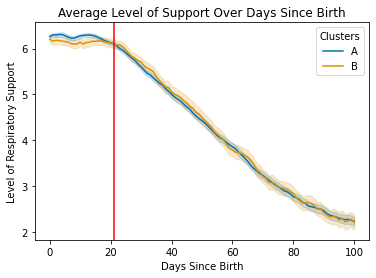

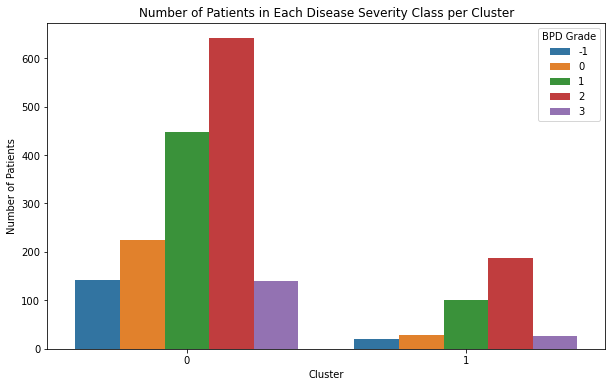

In [94]:
# Birthweight
g = sns.boxplot(data=t27g_d27g4_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g4_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

bw_means = t27g_d27g4_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d27g4_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
bw = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')
print(bw)
# Gestational Age
g = sns.boxplot(data=t27g_d27g4_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(2))
g.set_xticklabels(['A', 'B'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d27g4_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
plt.show()

ga_means = t27g_d27g4_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = t27g_d27g4_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
ga = pd.DataFrame({'Cluster': ['A', 'B'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')
print(ga)

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=t27g_d27g4_ds_df.loc[t27g_d27g4_ds_df['DSB'] <= 100], x='DSB', y='SupportType', 
                   hue='umap_KMeans', palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis
grouped = t27g_d27g4_pf_df.groupby(['umap_KMeans', 'BPD Grade']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='umap_KMeans', y='counts', hue='BPD Grade', data=grouped)
plt.title('Number of Patients in Each Disease Severity Class per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.show()


## Cluster Exploration/Visualization

### UMAP

In [9]:
def make_2D_UMAP(X, df, subgroups=['Subgroup_A', 'Subgroup_B', 'Subgroup_BW', 'Subgroup_GA']):
    mapper = umap_.UMAP().fit(X)
    for sg in subgroups:
        plt.figure()
        umap.plot.points(mapper, labels=df[sg], background='black', theme='fire')

In [10]:
def make_X(df):
    # assuming the vectorized dataframes are all constructed with only column 0, PatientSeqID,
    # to be removed from the values
    X = df.iloc[:, 1:].values
    X = StandardScaler().fit_transform(X)
    return X

<Figure size 432x288 with 0 Axes>

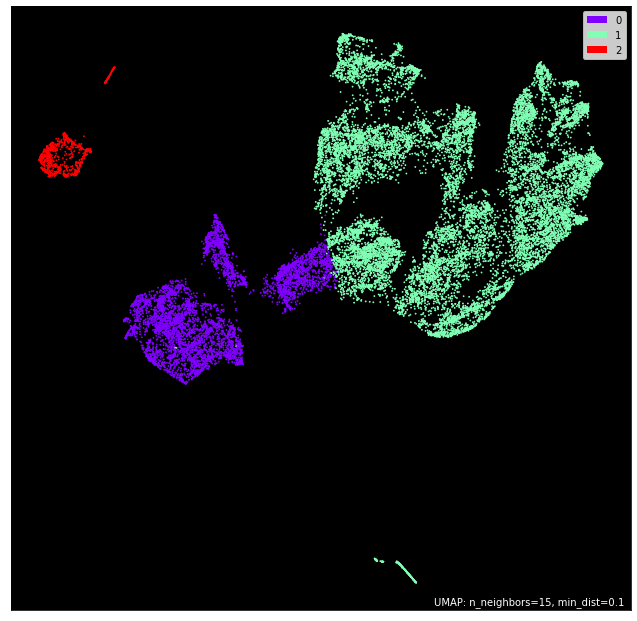

In [14]:
make_2D_UMAP(make_X(d1_vdf), d1_df, subgroups=['umap_KMeans'])

### Birth Weight + Gestational Age

#### Birth Weight

In [6]:
pal = sns.color_palette('colorblind')
colors = pal.as_hex()
print(colors)
new_pal = ['#0173b2', '#de8f05', '#029e73', '#ece133']
colors

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

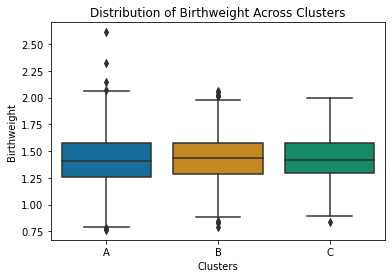

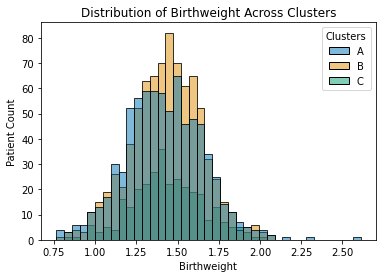

Mean        SD
Cluster                    
B1       1.417426  0.237900
B2       1.431086  0.214685
B3       1.438000  0.212012

In [21]:
# Birthweight
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(3))
g.set_xticklabels(['A', 'B', 'C'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C'], title='Clusters')
plt.show()

bw_means = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = t27g_d14g0_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')

# Gestational Age
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(3))
g.set_xticklabels(['B1', 'B2', 'B3'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')
plt.show()

ga_means = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')

# Support Type Trajectory
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=tgat1cbc_ds_df.loc[tgat1cbc_ds_df['DSB'] <= 100], x='DSB', y='SupportType', hue='umap_KMeans', 
             palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')
ax1.axvline(x=21, c='red')

# Purity Analysis



Text(0, 0.5, 'Birthweight')

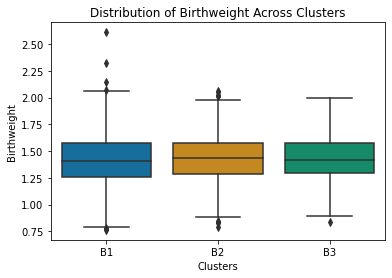

In [8]:
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='BirthWeight', palette=new_pal)
g.set_xticks(range(3))
g.set_xticklabels(['B1', 'B2', 'B3'])
plt.title('Distribution of Birthweight Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Birthweight')

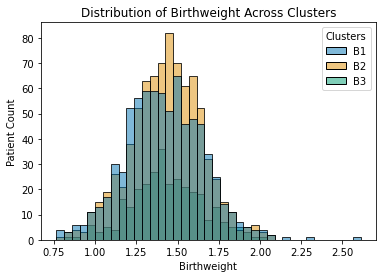

In [9]:
fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='BirthWeight', hue='umap_KMeans', palette='colorblind', ax=ax1, 
                   multiple='layer',
                  )
ax1.set_title('Distribution of Birthweight Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Birthweight')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')
plt.show()

In [28]:
bw_means = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').mean().reset_index()
bw_means = list(bw_means['BirthWeight'])
bw_sds = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'BirthWeight']].groupby('umap_KMeans').std().reset_index()
bw_sds = list(bw_sds['BirthWeight'])
pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': bw_means, 'SD': bw_sds}).set_index('Cluster')

Mean        SD
Cluster                    
B1       0.684684  0.137115
B2       0.890316  0.197497
B3       0.852651  0.224599

Text(0, 0.5, 'Gestataional Age')

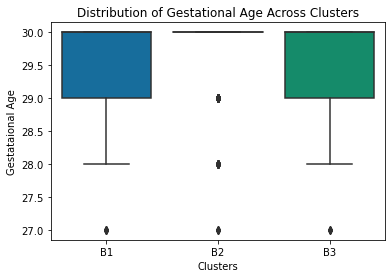

In [10]:
g = sns.boxplot(data=t27g_d14g0_pf_df, x='umap_KMeans', y='GestAge', palette='colorblind')
g.set_xticks(range(3))
g.set_xticklabels(['B1', 'B2', 'B3'])
plt.title('Distribution of Gestational Age Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Gestataional Age')

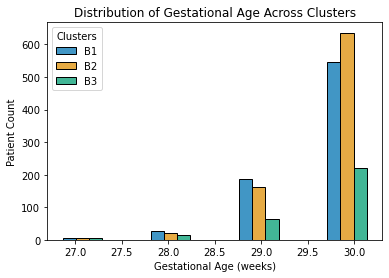

In [11]:
fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=t27g_d14g0_pf_df, x='GestAge', hue='umap_KMeans', palette='colorblind', ax=ax1, multiple='dodge',
                  shrink=2.7)
ax1.set_title('Distribution of Gestational Age Across Clusters')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Gestational Age (weeks)')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')
plt.show()

In [32]:
ga_means = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').mean().reset_index()
ga_means = list(ga_means['GestAge'])
ga_sds = tgat1cbc_pf_df.loc[:, ['umap_KMeans', 'GestAge']].groupby('umap_KMeans').std().reset_index()
ga_sds = list(ga_sds['GestAge'])
pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': ga_means, 'SD': ga_sds}).set_index('Cluster')

Mean        SD
Cluster                     
B1       24.835278  1.297392
B2       26.598687  1.381602
B3       26.070345  1.738980

### Avg Support Trajectory + Std Dev of Support Type

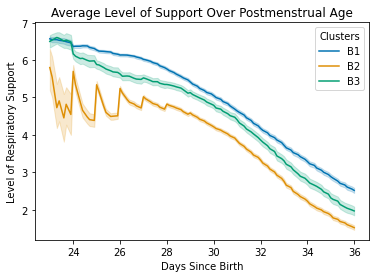

In [40]:
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=tgat1cbc_ds_df.loc[tgat1cbc_ds_df['PMA'] <= 36.0], x='PMA', y='SupportType', hue='umap_KMeans', 
             palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Postmenstrual Age')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')


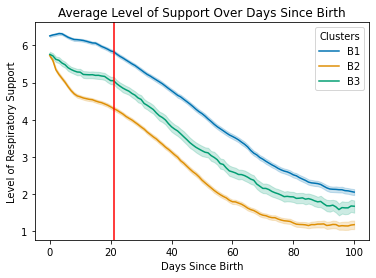

In [13]:
# sns.lineplot(data=tgat1c_ds_df.loc[tgat1c_ds_df['DSB'] <= 150], x='DSB', y='SupportType', hue='umap_KMeans', 
#              palette = 'colorblind')
# plt.ylabel('Level of Respiratory Support')
# plt.xlabel('Days Since Birth')
# plt.title('Average Level of Support Over Days Since Birth')
# legend = plt.legend(title="Clusters",
#                     loc=4, fontsize='small', fancybox=True)
fig, ax1 = plt.subplots()
sp1 = sns.lineplot(data=tgat1cbc_ds_df.loc[tgat1cbc_ds_df['DSB'] <= 100], x='DSB', y='SupportType', hue='umap_KMeans', 
             palette = 'colorblind', ax=ax1)
ax1.set_title('Average Level of Support Over Days Since Birth')
ax1.set_ylabel('Level of Respiratory Support')
ax1.set_xlabel('Days Since Birth')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['B1', 'B2', 'B3'], title='Clusters')
ax1.axvline(x=21, c='red')

In [41]:
tgat1cbc_stdst_df = tgat1cbc_ds_df.groupby('PatientSeqID').std().reset_index().loc[:, ['PatientSeqID', 'SupportType']]
tgat1cbc_stdst_df.columns = ['PatientSeqID', 'Support Type SD']

In [42]:
tgat1cbc_pf_sd_df = tgat1cbc_pf_df.merge(tgat1cbc_stdst_df)

Text(0, 0.5, 'Support Type SD')

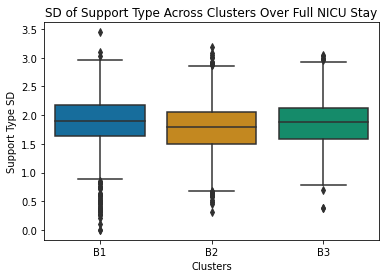

In [43]:
g = sns.boxplot(data=tgat1cbc_pf_sd_df, x='umap_KMeans', y='Support Type SD', palette='colorblind')
g.set_xticks(range(3))
g.set_xticklabels(['B1', 'B2', 'B3'])
plt.title('SD of Support Type Across Clusters Over Full NICU Stay')
plt.xlabel('Clusters')
plt.ylabel('Support Type SD')

In [44]:
st_means = tgat1cbc_pf_sd_df.loc[:, ['umap_KMeans', 'Support Type SD']].groupby('umap_KMeans').mean().reset_index()
st_means = list(st_means['Support Type SD'])
st_sds = tgat1cbc_pf_sd_df.loc[:, ['umap_KMeans', 'Support Type SD']].groupby('umap_KMeans').std().reset_index()
st_sds = list(st_sds['Support Type SD'])
pd.DataFrame({'Cluster': ['B1', 'B2', 'B3'], 'Mean': st_means, 'SD': st_sds}).set_index('Cluster')

Mean        SD
Cluster                    
B1       1.898358  0.419923
B2       1.769155  0.410757
B3       1.862892  0.429657

In [45]:
tgat1cbc_stdst_21_df = tgat1cbc_ds_df.loc[tgat1cbc_ds_df['DSB'] < 21].groupby('PatientSeqID').std().reset_index().loc[:, ['PatientSeqID', 'SupportType']]
tgat1cbc_stdst_21_df.columns = ['PatientSeqID', 'Support Type SD']

In [46]:
tgat1cbc_pf_sd_21_df = tgat1cbc_pf_df.merge(tgat1cbc_stdst_21_df)

Text(0, 0.5, 'Support Type SD')

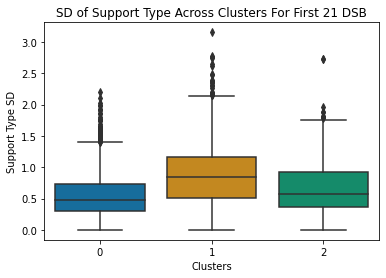

In [47]:
sns.boxplot(data=tgat1cbc_pf_sd_21_df, x='umap_KMeans', y='Support Type SD', palette='colorblind')
plt.title('SD of Support Type Across Clusters For First 21 DSB')
plt.xlabel('Clusters')
plt.ylabel('Support Type SD')

### Looking at Medications + Procedures

In [86]:
tgat1c_dm_df

PatientSeqID  pca_DBScan  pca_Hier  pca_KMeans  umap_DBScan  \
0             1134206           0         1           1            0   
1             1134206           0         1           1            0   
2             1134206           0         1           1            0   
3             1134206           0         1           1            0   
4             1134206           0         1           1            0   
...               ...         ...       ...         ...          ...   
1366688       6561044           0         0           0            0   
1366689       6561044           0         0           0            0   
1366690       6561044           0         0           0            0   
1366691       6561044           0         0           0            0   
1366692       6561044           0         0           0            0   

         umap_Hier  umap_KMeans  DSB  Calfactant (Infasurf)  Nystatin cream  \
0                3            3    0                      0               0   
1                3            3    1                      0               0   
2                3            3    2                      0               0   
3                3            3    3                      0               0   
4                3            3    4                      0               0   
...            ...          ...  ...                    ...             ...   
1366688          2            2   61                      0               0   
1366689          2            2   62                      0               0   
1366690          2            2   63                      0               0   
1366691          2            2   64                      0               0   
1366692          2            2   65                      0               0   

         ...  Gabapentin  FloraTummys  Cholestyramine Topical  \
0        ...           0            0                       0   
1        ...           0            0                       0   
2        ...           0            0                       0   
3        ...           0            0                       0   
4        ...           0            0                       0   
...      ...         ...          ...                     ...   
1366688  ...           0            0                       0   
1366689  ...           0            0                       0   
1366690  ...           0            0                       0   
1366691  ...           0            0                       0   
1366692  ...           0            0                       0   

         Acetaminophen IV  Ciprofloxacin Ophthalmic  Ertapenem  \
0                       0                         0          0   
1                       0                         0          0   
2                       0                         0          0   
3                       0                         0          0   
4                       0                         0          0   
...                   ...                       ...        ...   
1366688                 0                         0          0   
1366689                 0                         0          0   
1366690                 0                         0          0   
1366691                 0                         0          0   
1366692                 0                         0          0   

         Drops Not Coded  Pentamidine  Darbepoietin  Methicillin  
0                      0            0             0            0  
1                      0            0             0            0  
2                      0            0             0            0  
3                      0            0             0            0  
4                      0            0             0            0  
...                  ...          ...           ...          ...  
1366688                0            0             0            0  
1366689                0            0             0            0  
1366690           

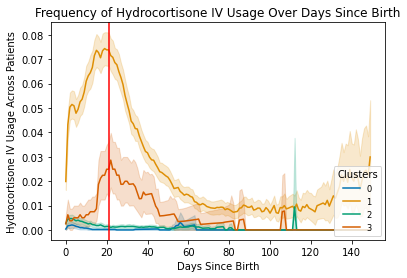

In [93]:
sns.lineplot(data=tgat1c_dm_df.loc[tgat1c_dm_df['DSB'] < 150], x='DSB', y='Hydrocortisone IV', 
             hue='umap_KMeans', palette='colorblind')

plt.ylabel('Hydrocortisone IV Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Hydrocortisone IV Usage Over Days Since Birth')
legend = plt.legend(title="Clusters",
                    loc=4, fontsize='small', fancybox=True)
plt.axvline(x=21, c='red')

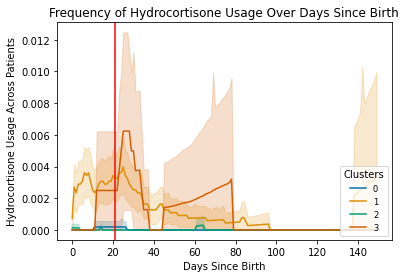

In [185]:
sns.lineplot(data=tgat1c_dm_df.loc[tgat1c_dm_df['DSB'] < 150], x='DSB', y='Hydrocortisone', 
             hue='umap_KMeans', palette='colorblind')

plt.ylabel('Hydrocortisone Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Hydrocortisone Usage Over Days Since Birth')
legend = plt.legend(title="Clusters",
                    loc=4, fontsize='small', fancybox=True)
plt.axvline(x=21, c='red')

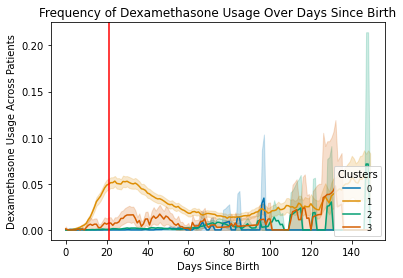

In [92]:
sns.lineplot(data=tgat1c_dm_df.loc[tgat1c_dm_df['DSB'] < 150], x='DSB', y='Dexamethasone', 
             hue='umap_KMeans', palette='colorblind')

plt.ylabel('Dexamethasone Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Dexamethasone Usage Over Days Since Birth')
legend = plt.legend(title="Clusters",
                    loc=4, fontsize='small', fancybox=True)
plt.axvline(x=21, c='red')

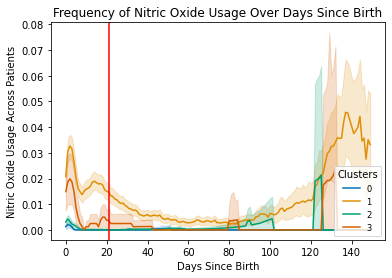

In [94]:
sns.lineplot(data=tgat1c_dm_df.loc[tgat1c_dm_df['DSB'] < 150], x='DSB', y='Nitric Oxide (iNO)', 
             hue='umap_KMeans', palette='colorblind')

plt.ylabel('Nitric Oxide Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Nitric Oxide Usage Over Days Since Birth')
legend = plt.legend(title="Clusters",
                    loc=4, fontsize='small', fancybox=True)
plt.axvline(x=21, c='red')

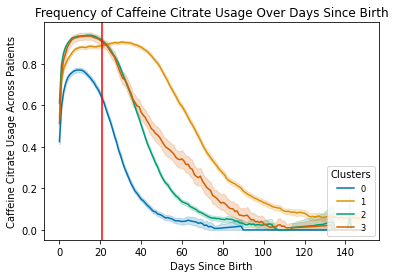

In [95]:
sns.lineplot(data=tgat1c_dm_df.loc[tgat1c_dm_df['DSB'] < 150], x='DSB', y='Caffeine Citrate', 
             hue='umap_KMeans', palette='colorblind')

plt.ylabel('Caffeine Citrate Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Caffeine Citrate Usage Over Days Since Birth')
legend = plt.legend(title="Clusters",
                    loc=4, fontsize='small', fancybox=True)
plt.axvline(x=21, c='red')

In [100]:
tgat1c_pf_df.shape

(19512, 27)

### Comparison to Ground-Truth Labels

In [48]:
comp_df = tgat1cbc_pf_df.loc[:, ['PatientSeqID', 'umap_KMeans', 'BPD Grade']]
comp_df = comp_df.set_index('PatientSeqID')
comp_df

umap_KMeans  BPD Grade
PatientSeqID                        
5231421                 1          3
5231626                 1          1
5231823                 0          0
5231871                 2          2
5232273                 1          3
...                   ...        ...
6559174                 0          1
6559560                 1          0
6560053                 2          1
6560532                 1          2
6560537                 1          1

[5542 rows x 2 columns]

In [49]:
comp_df.loc[(comp_df['umap_KMeans'] == 3) & (comp_df['BPD Grade'] ==3)]

Empty DataFrame
Columns: [umap_KMeans, BPD Grade]
Index: []

<AxesSubplot:xlabel='umap_KMeans', ylabel='Count'>

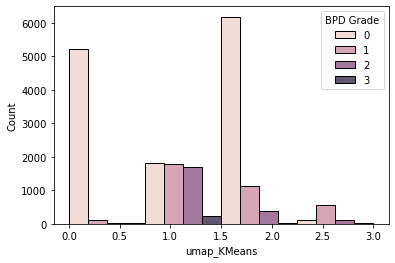

In [166]:
sns.histplot(data=comp_df, x='umap_KMeans', hue='BPD Grade', multiple='dodge', bins=4)

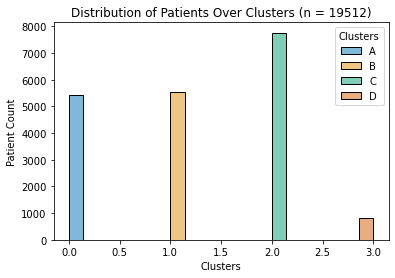

In [8]:
fig, ax1 = plt.subplots()
sp1 = sns.histplot(data=tgat1c_pf_df, x='umap_KMeans', hue='umap_KMeans', palette='colorblind', ax=ax1)
ax1.set_title('Distribution of Patients Over Clusters (n = 19512)')
ax1.set_ylabel('Patient Count')
ax1.set_xlabel('Clusters')
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['A', 'B', 'C', 'D'], title='Clusters')
plt.show()

Text(0, 0.5, 'Patient Count')

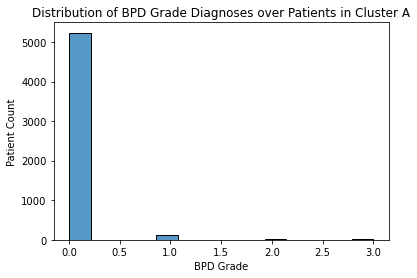

In [9]:
# cluster 0
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['umap_KMeans'] == 0], x='BPD Grade')
plt.title('Distribution of BPD Grade Diagnoses over Patients in Cluster A')
plt.xlabel('BPD Grade')
plt.ylabel('Patient Count')

Text(0, 0.5, 'Patient Count')

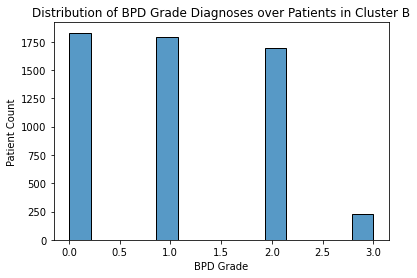

In [392]:
# cluster 1
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['umap_KMeans'] == 1], x='BPD Grade')
plt.title('Distribution of BPD Grade Diagnoses over Patients in Cluster B')
plt.xlabel('BPD Grade')
plt.ylabel('Patient Count')

Text(0, 0.5, 'Patient Count')

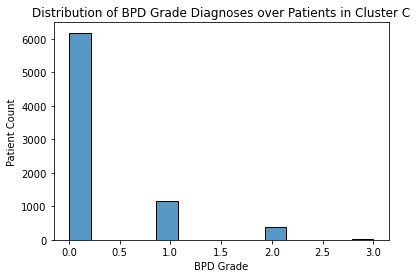

In [393]:
# cluster 2
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['umap_KMeans'] == 2], x='BPD Grade')
plt.title('Distribution of BPD Grade Diagnoses over Patients in Cluster C')
plt.xlabel('BPD Grade')
plt.ylabel('Patient Count')

Text(0, 0.5, 'Patient Count')

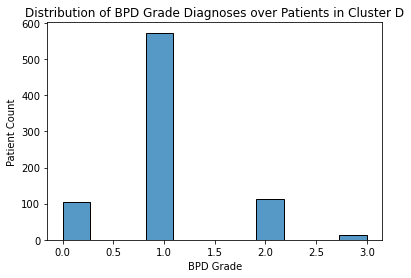

In [394]:
# cluster 3
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['umap_KMeans'] == 3], x='BPD Grade')
plt.title('Distribution of BPD Grade Diagnoses over Patients in Cluster D')
plt.xlabel('BPD Grade')
plt.ylabel('Patient Count')

#### Purity Analysis

In [51]:
c0 = np.array(list(tgat1cbc_pf_df.loc[tgat1cbc_pf_df['umap_KMeans'] == 0]['BPD Grade'].value_counts()))
c0 = np.around(c0/np.sum(c0), 4)
c1 = np.array(list(tgat1cbc_pf_df.loc[tgat1cbc_pf_df['umap_KMeans'] == 1]['BPD Grade'].value_counts()))
c1 = np.around(c1/np.sum(c1), 4)
c2 = np.array(list(tgat1cbc_pf_df.loc[tgat1cbc_pf_df['umap_KMeans'] == 2]['BPD Grade'].value_counts()))
c2 = np.around(c2/np.sum(c2), 4)

purity_df = pd.DataFrame({'BPD Grade': ['Grade ' + str(i) for i in range(4)], 'Cluster B1': c0, 
                          'Cluster B2': c1, 'Cluster B3': c2}).set_index('BPD Grade')
purity_df

Cluster B1  Cluster B2  Cluster B3
BPD Grade                                    
Grade 0        0.4044      0.4538      0.3614
Grade 1        0.3469      0.3210      0.3517
Grade 2        0.1795      0.2051      0.2579
Grade 3        0.0691      0.0201      0.0290

In [172]:
c0

array([0.96781949, 0.02404291, 0.00536342, 0.00277418])

In [52]:
temp0_df = pd.DataFrame({'BPD Grade': [str(i) for i in range(4)], 
                       'Cluster': ['B1' for _ in range(4)],
                       'Percent': c0*100})
temp1_df = pd.DataFrame({'BPD Grade': [str(i) for i in range(4)], 
                       'Cluster': ['B2' for _ in range(4)],
                       'Percent': c1*100})
temp2_df = pd.DataFrame({'BPD Grade': [str(i) for i in range(4)], 
                       'Cluster': ['B3' for _ in range(4)],
                       'Percent': c2*100})
comb_df = pd.concat([temp0_df, temp1_df, temp2_df], axis=0)

Text(0, 0.5, 'Percent of Patients')

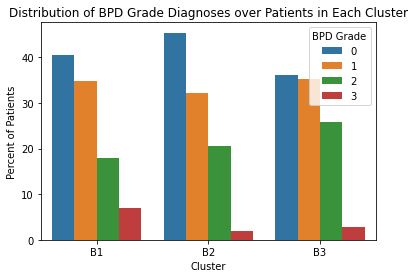

In [53]:
sns.barplot(data=comb_df, x='Cluster', y='Percent', hue='BPD Grade')
plt.title('Distribution of BPD Grade Diagnoses over Patients in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percent of Patients')

<AxesSubplot:xlabel='BPD Grade', ylabel='Percent'>

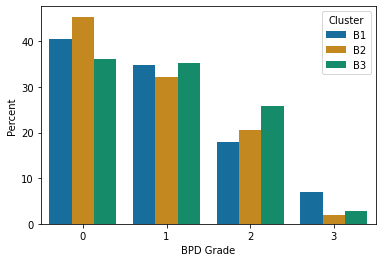

In [55]:
sns.barplot(data=comb_df, x='BPD Grade', y='Percent', hue='Cluster', palette=new_pal)

<AxesSubplot:xlabel='umap_KMeans', ylabel='Count'>

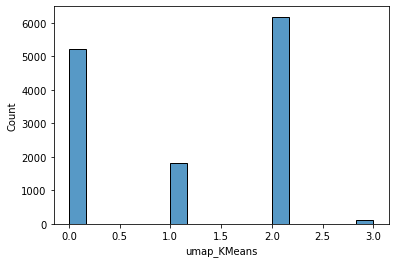

In [114]:
# grade 0
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['BPD Grade'] == 0], x='umap_KMeans')

<AxesSubplot:xlabel='umap_KMeans', ylabel='Count'>

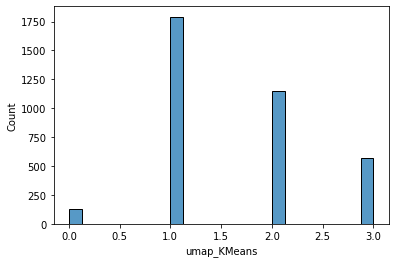

In [113]:
# grade 1
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['BPD Grade'] == 1], x='umap_KMeans')

<AxesSubplot:xlabel='umap_KMeans', ylabel='Count'>

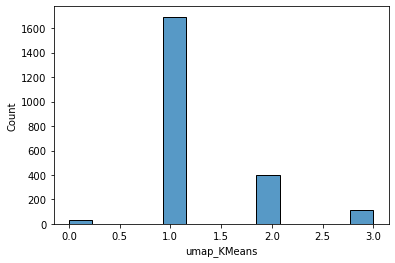

In [111]:
# grade 2
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['BPD Grade'] == 2], x='umap_KMeans')

<AxesSubplot:xlabel='umap_KMeans', ylabel='Count'>

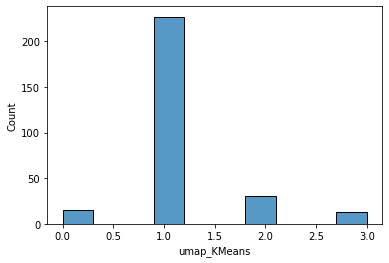

In [112]:
# grade 3
sns.histplot(data=tgat1c_pf_df.loc[tgat1c_pf_df['BPD Grade'] == 3], x='umap_KMeans')

### Feature Importance Analysis

In [139]:
tmgat1cv_df = tmgat1cv_df.dropna()

In [143]:
ft_df = tmgat1cv_df.loc[:, ['PatientSeqID'] + list(tmgat1cv_df.columns[7:])]

Feature: SupportType0 Score: 0.00340
Feature: SupportType1 Score: 0.00541
Feature: SupportType2 Score: 0.01139
Feature: SupportType3 Score: 0.01306
Feature: SupportType4 Score: 0.01224
Feature: SupportType5 Score: 0.01253
Feature: SupportType6 Score: 0.01275
Feature: SupportType7 Score: 0.01362
Feature: SupportType8 Score: 0.02347
Feature: SupportType9 Score: 0.01195
Feature: SupportType10 Score: 0.01705
Feature: SupportType11 Score: 0.02955
Feature: SupportType12 Score: 0.00996
Feature: SupportType13 Score: 0.01858
Feature: SupportType14 Score: 0.01180
Feature: SupportType15 Score: 0.01464
Feature: SupportType16 Score: 0.01567
Feature: SupportType17 Score: 0.00983
Feature: SupportType18 Score: 0.02088
Feature: SupportType19 Score: 0.00952
Feature: SupportType20 Score: 0.01499
Feature: SupportMax0 Score: 0.00319
Feature: SupportMax1 Score: 0.00626
Feature: SupportMax2 Score: 0.00400
Feature: SupportMax3 Score: 0.01126
Feature: SupportMax4 Score: 0.00334
Feature: SupportMax5 Score: 0.00

Feature: Nystatin13 Score: 0.00293
Feature: Nystatin14 Score: 0.00407
Feature: Nystatin15 Score: 0.00643
Feature: Nystatin16 Score: 0.00308
Feature: Nystatin17 Score: 0.00309
Feature: Nystatin18 Score: 0.00466
Feature: Nystatin19 Score: 0.00432
Feature: Nystatin20 Score: 0.00174
Feature: Heparin0 Score: 0.00000
Feature: Heparin1 Score: 0.00000
Feature: Heparin2 Score: 0.00000
Feature: Heparin3 Score: 0.00000
Feature: Heparin4 Score: 0.00000
Feature: Heparin5 Score: 0.00000
Feature: Heparin6 Score: 0.00000
Feature: Heparin7 Score: 0.00000
Feature: Heparin8 Score: 0.00000
Feature: Heparin9 Score: 0.00000
Feature: Heparin10 Score: 0.00000
Feature: Heparin11 Score: 0.00000
Feature: Heparin12 Score: 0.00000
Feature: Heparin13 Score: 0.00000
Feature: Heparin14 Score: 0.00000
Feature: Heparin15 Score: 0.00000
Feature: Heparin16 Score: 0.00000
Feature: Heparin17 Score: 0.00000
Feature: Heparin18 Score: 0.00000
Feature: Heparin19 Score: 0.00000
Feature: Heparin20 Score: 0.00000
Feature: Multivi

Feature: Vitamin - A (Retinyl Palmitate)7 Score: 0.00009
Feature: Vitamin - A (Retinyl Palmitate)8 Score: 0.00000
Feature: Vitamin - A (Retinyl Palmitate)9 Score: 0.00044
Feature: Vitamin - A (Retinyl Palmitate)10 Score: 0.00027
Feature: Vitamin - A (Retinyl Palmitate)11 Score: 0.00000
Feature: Vitamin - A (Retinyl Palmitate)12 Score: 0.00009
Feature: Vitamin - A (Retinyl Palmitate)13 Score: 0.00034
Feature: Vitamin - A (Retinyl Palmitate)14 Score: 0.00069
Feature: Vitamin - A (Retinyl Palmitate)15 Score: 0.00067
Feature: Vitamin - A (Retinyl Palmitate)16 Score: 0.00000
Feature: Vitamin - A (Retinyl Palmitate)17 Score: 0.00000
Feature: Vitamin - A (Retinyl Palmitate)18 Score: 0.00000
Feature: Vitamin - A (Retinyl Palmitate)19 Score: 0.00003
Feature: Vitamin - A (Retinyl Palmitate)20 Score: 0.00002
Feature: Pancuronium0 Score: 0.00000
Feature: Pancuronium1 Score: 0.00000
Feature: Pancuronium2 Score: 0.00000
Feature: Pancuronium3 Score: 0.00000
Feature: Pancuronium4 Score: 0.00000
Featur

Feature: Phenylephrine3 Score: 0.00000
Feature: Phenylephrine4 Score: 0.00000
Feature: Phenylephrine5 Score: 0.00000
Feature: Phenylephrine6 Score: 0.00000
Feature: Phenylephrine7 Score: 0.00000
Feature: Phenylephrine8 Score: 0.00000
Feature: Phenylephrine9 Score: 0.00000
Feature: Phenylephrine10 Score: 0.00000
Feature: Phenylephrine11 Score: 0.00000
Feature: Phenylephrine12 Score: 0.00000
Feature: Phenylephrine13 Score: 0.00000
Feature: Phenylephrine14 Score: 0.00000
Feature: Phenylephrine15 Score: 0.00000
Feature: Phenylephrine16 Score: 0.00000
Feature: Phenylephrine17 Score: 0.00000
Feature: Phenylephrine18 Score: 0.00000
Feature: Phenylephrine19 Score: 0.00000
Feature: Phenylephrine20 Score: 0.00000
Feature: Prednisolone0 Score: 0.00000
Feature: Prednisolone1 Score: 0.00000
Feature: Prednisolone2 Score: 0.00000
Feature: Prednisolone3 Score: 0.00000
Feature: Prednisolone4 Score: 0.00000
Feature: Prednisolone5 Score: 0.00000
Feature: Prednisolone6 Score: 0.00000
Feature: Prednisolone

Feature: Metronidazole10 Score: 0.00040
Feature: Metronidazole11 Score: 0.00092
Feature: Metronidazole12 Score: 0.00000
Feature: Metronidazole13 Score: 0.00025
Feature: Metronidazole14 Score: 0.00000
Feature: Metronidazole15 Score: 0.00052
Feature: Metronidazole16 Score: 0.00000
Feature: Metronidazole17 Score: 0.00025
Feature: Metronidazole18 Score: 0.00021
Feature: Metronidazole19 Score: 0.00028
Feature: Metronidazole20 Score: 0.00005
Feature: Ursodiol (Ursodeoxycholic Acid)0 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)1 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)2 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)3 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)4 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)5 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)6 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)7 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)8 Score: 0.00000
Feature: Ursodiol (Ursodeoxycholic Acid)9 Score

Feature: Eye Lubricant16 Score: 0.00000
Feature: Eye Lubricant17 Score: 0.00000
Feature: Eye Lubricant18 Score: 0.00000
Feature: Eye Lubricant19 Score: 0.00000
Feature: Eye Lubricant20 Score: 0.00000
Feature: Cefepime0 Score: 0.00000
Feature: Cefepime1 Score: 0.00000
Feature: Cefepime2 Score: 0.00000
Feature: Cefepime3 Score: 0.00000
Feature: Cefepime4 Score: 0.00000
Feature: Cefepime5 Score: 0.00000
Feature: Cefepime6 Score: 0.00000
Feature: Cefepime7 Score: 0.00000
Feature: Cefepime8 Score: 0.00010
Feature: Cefepime9 Score: 0.00000
Feature: Cefepime10 Score: 0.00001
Feature: Cefepime11 Score: 0.00000
Feature: Cefepime12 Score: 0.00000
Feature: Cefepime13 Score: 0.00000
Feature: Cefepime14 Score: 0.00000
Feature: Cefepime15 Score: 0.00000
Feature: Cefepime16 Score: 0.00025
Feature: Cefepime17 Score: 0.00000
Feature: Cefepime18 Score: 0.00000
Feature: Cefepime19 Score: 0.00000
Feature: Cefepime20 Score: 0.00000
Feature: Mycolog Cream0 Score: 0.00000
Feature: Mycolog Cream1 Score: 0.000

Feature: Caspofungin10 Score: 0.00000
Feature: Caspofungin11 Score: 0.00000
Feature: Caspofungin12 Score: 0.00000
Feature: Caspofungin13 Score: 0.00000
Feature: Caspofungin14 Score: 0.00000
Feature: Caspofungin15 Score: 0.00000
Feature: Caspofungin16 Score: 0.00000
Feature: Caspofungin17 Score: 0.00000
Feature: Caspofungin18 Score: 0.00000
Feature: Caspofungin19 Score: 0.00000
Feature: Caspofungin20 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops0 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops1 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops2 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops3 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops4 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops5 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops6 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops7 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops8 Score: 0.00000
Feature: Polymyxin B Topical Eye Drops9 Score: 0.00000
Feature: Polymyxin B Topical Eye

Feature: Iron Dextran5 Score: 0.00000
Feature: Iron Dextran6 Score: 0.00000
Feature: Iron Dextran7 Score: 0.00000
Feature: Iron Dextran8 Score: 0.00000
Feature: Iron Dextran9 Score: 0.00000
Feature: Iron Dextran10 Score: 0.00000
Feature: Iron Dextran11 Score: 0.00000
Feature: Iron Dextran12 Score: 0.00042
Feature: Iron Dextran13 Score: 0.00000
Feature: Iron Dextran14 Score: 0.00000
Feature: Iron Dextran15 Score: 0.00000
Feature: Iron Dextran16 Score: 0.00025
Feature: Iron Dextran17 Score: 0.00000
Feature: Iron Dextran18 Score: 0.00000
Feature: Iron Dextran19 Score: 0.00002
Feature: Iron Dextran20 Score: 0.00000
Feature: Phenytoin0 Score: 0.00000
Feature: Phenytoin1 Score: 0.00000
Feature: Phenytoin2 Score: 0.00000
Feature: Phenytoin3 Score: 0.00000
Feature: Phenytoin4 Score: 0.00000
Feature: Phenytoin5 Score: 0.00000
Feature: Phenytoin6 Score: 0.00000
Feature: Phenytoin7 Score: 0.00000
Feature: Phenytoin8 Score: 0.00000
Feature: Phenytoin9 Score: 0.00000
Feature: Phenytoin10 Score: 0.0

Feature: EMLA (lidocaine+prilocaine cream)20 Score: 0.00000
Feature: Oxymetazoline0 Score: 0.00000
Feature: Oxymetazoline1 Score: 0.00000
Feature: Oxymetazoline2 Score: 0.00000
Feature: Oxymetazoline3 Score: 0.00000
Feature: Oxymetazoline4 Score: 0.00000
Feature: Oxymetazoline5 Score: 0.00000
Feature: Oxymetazoline6 Score: 0.00000
Feature: Oxymetazoline7 Score: 0.00000
Feature: Oxymetazoline8 Score: 0.00000
Feature: Oxymetazoline9 Score: 0.00000
Feature: Oxymetazoline10 Score: 0.00000
Feature: Oxymetazoline11 Score: 0.00000
Feature: Oxymetazoline12 Score: 0.00000
Feature: Oxymetazoline13 Score: 0.00000
Feature: Oxymetazoline14 Score: 0.00000
Feature: Oxymetazoline15 Score: 0.00000
Feature: Oxymetazoline16 Score: 0.00000
Feature: Oxymetazoline17 Score: 0.00000
Feature: Oxymetazoline18 Score: 0.00000
Feature: Oxymetazoline19 Score: 0.00000
Feature: Oxymetazoline20 Score: 0.00000
Feature: Adenosine0 Score: 0.00000
Feature: Adenosine1 Score: 0.00000
Feature: Adenosine2 Score: 0.00000
Featu

Feature: Cloxacillin/Dicloxacillin16 Score: 0.00000
Feature: Cloxacillin/Dicloxacillin17 Score: 0.00000
Feature: Cloxacillin/Dicloxacillin18 Score: 0.00000
Feature: Cloxacillin/Dicloxacillin19 Score: 0.00000
Feature: Cloxacillin/Dicloxacillin20 Score: 0.00000
Feature: Erythromycin-Sulfa0 Score: 0.00000
Feature: Erythromycin-Sulfa1 Score: 0.00000
Feature: Erythromycin-Sulfa2 Score: 0.00000
Feature: Erythromycin-Sulfa3 Score: 0.00000
Feature: Erythromycin-Sulfa4 Score: 0.00000
Feature: Erythromycin-Sulfa5 Score: 0.00000
Feature: Erythromycin-Sulfa6 Score: 0.00000
Feature: Erythromycin-Sulfa7 Score: 0.00000
Feature: Erythromycin-Sulfa8 Score: 0.00000
Feature: Erythromycin-Sulfa9 Score: 0.00000
Feature: Erythromycin-Sulfa10 Score: 0.00000
Feature: Erythromycin-Sulfa11 Score: 0.00000
Feature: Erythromycin-Sulfa12 Score: 0.00000
Feature: Erythromycin-Sulfa13 Score: 0.00000
Feature: Erythromycin-Sulfa14 Score: 0.00000
Feature: Erythromycin-Sulfa15 Score: 0.00000
Feature: Erythromycin-Sulfa16 

Feature: Promod10 Score: 0.00000
Feature: Promod11 Score: 0.00000
Feature: Promod12 Score: 0.00000
Feature: Promod13 Score: 0.00000
Feature: Promod14 Score: 0.00000
Feature: Promod15 Score: 0.00000
Feature: Promod16 Score: 0.00000
Feature: Promod17 Score: 0.00000
Feature: Promod18 Score: 0.00000
Feature: Promod19 Score: 0.00000
Feature: Promod20 Score: 0.00000
Feature: Cefaclor0 Score: 0.00000
Feature: Cefaclor1 Score: 0.00000
Feature: Cefaclor2 Score: 0.00000
Feature: Cefaclor3 Score: 0.00000
Feature: Cefaclor4 Score: 0.00000
Feature: Cefaclor5 Score: 0.00000
Feature: Cefaclor6 Score: 0.00000
Feature: Cefaclor7 Score: 0.00000
Feature: Cefaclor8 Score: 0.00000
Feature: Cefaclor9 Score: 0.00000
Feature: Cefaclor10 Score: 0.00000
Feature: Cefaclor11 Score: 0.00000
Feature: Cefaclor12 Score: 0.00000
Feature: Cefaclor13 Score: 0.00000
Feature: Cefaclor14 Score: 0.00000
Feature: Cefaclor15 Score: 0.00000
Feature: Cefaclor16 Score: 0.00000
Feature: Cefaclor17 Score: 0.00000
Feature: Cefaclor

Feature: Isoproterenol4 Score: 0.00000
Feature: Isoproterenol5 Score: 0.00000
Feature: Isoproterenol6 Score: 0.00000
Feature: Isoproterenol7 Score: 0.00000
Feature: Isoproterenol8 Score: 0.00000
Feature: Isoproterenol9 Score: 0.00000
Feature: Isoproterenol10 Score: 0.00000
Feature: Isoproterenol11 Score: 0.00000
Feature: Isoproterenol12 Score: 0.00000
Feature: Isoproterenol13 Score: 0.00000
Feature: Isoproterenol14 Score: 0.00000
Feature: Isoproterenol15 Score: 0.00000
Feature: Isoproterenol16 Score: 0.00000
Feature: Isoproterenol17 Score: 0.00000
Feature: Isoproterenol18 Score: 0.00000
Feature: Isoproterenol19 Score: 0.00000
Feature: Isoproterenol20 Score: 0.00000
Feature: Nose drops0 Score: 0.00000
Feature: Nose drops1 Score: 0.00000
Feature: Nose drops2 Score: 0.00000
Feature: Nose drops3 Score: 0.00000
Feature: Nose drops4 Score: 0.00000
Feature: Nose drops5 Score: 0.00000
Feature: Nose drops6 Score: 0.00000
Feature: Nose drops7 Score: 0.00000
Feature: Nose drops8 Score: 0.00000
Fe

Feature: Docusate1 Score: 0.00000
Feature: Docusate2 Score: 0.00000
Feature: Docusate3 Score: 0.00000
Feature: Docusate4 Score: 0.00000
Feature: Docusate5 Score: 0.00000
Feature: Docusate6 Score: 0.00000
Feature: Docusate7 Score: 0.00000
Feature: Docusate8 Score: 0.00000
Feature: Docusate9 Score: 0.00000
Feature: Docusate10 Score: 0.00000
Feature: Docusate11 Score: 0.00000
Feature: Docusate12 Score: 0.00000
Feature: Docusate13 Score: 0.00000
Feature: Docusate14 Score: 0.00000
Feature: Docusate15 Score: 0.00000
Feature: Docusate16 Score: 0.00000
Feature: Docusate17 Score: 0.00000
Feature: Docusate18 Score: 0.00000
Feature: Docusate19 Score: 0.00000
Feature: Docusate20 Score: 0.00000
Feature: Polymyxin B Topical0 Score: 0.00000
Feature: Polymyxin B Topical1 Score: 0.00000
Feature: Polymyxin B Topical2 Score: 0.00000
Feature: Polymyxin B Topical3 Score: 0.00000
Feature: Polymyxin B Topical4 Score: 0.00000
Feature: Polymyxin B Topical5 Score: 0.00000
Feature: Polymyxin B Topical6 Score: 0.

Feature: Glutamine16 Score: 0.00000
Feature: Glutamine17 Score: 0.00000
Feature: Glutamine18 Score: 0.00000
Feature: Glutamine19 Score: 0.00000
Feature: Glutamine20 Score: 0.00000
Feature: Tropicamide0 Score: 0.00000
Feature: Tropicamide1 Score: 0.00000
Feature: Tropicamide2 Score: 0.00000
Feature: Tropicamide3 Score: 0.00000
Feature: Tropicamide4 Score: 0.00000
Feature: Tropicamide5 Score: 0.00000
Feature: Tropicamide6 Score: 0.00000
Feature: Tropicamide7 Score: 0.00000
Feature: Tropicamide8 Score: 0.00000
Feature: Tropicamide9 Score: 0.00000
Feature: Tropicamide10 Score: 0.00000
Feature: Tropicamide11 Score: 0.00000
Feature: Tropicamide12 Score: 0.00000
Feature: Tropicamide13 Score: 0.00000
Feature: Tropicamide14 Score: 0.00000
Feature: Tropicamide15 Score: 0.00000
Feature: Tropicamide16 Score: 0.00000
Feature: Tropicamide17 Score: 0.00000
Feature: Tropicamide18 Score: 0.00000
Feature: Tropicamide19 Score: 0.00000
Feature: Tropicamide20 Score: 0.00000
Feature: Scopolamine Topical0 Sc

Feature: Cryoprecipitate11 Score: 0.00000
Feature: Cryoprecipitate12 Score: 0.00000
Feature: Cryoprecipitate13 Score: 0.00000
Feature: Cryoprecipitate14 Score: 0.00000
Feature: Cryoprecipitate15 Score: 0.00000
Feature: Cryoprecipitate16 Score: 0.00000
Feature: Cryoprecipitate17 Score: 0.00000
Feature: Cryoprecipitate18 Score: 0.00000
Feature: Cryoprecipitate19 Score: 0.00000
Feature: Cryoprecipitate20 Score: 0.00000
Feature: Nitroprusside0 Score: 0.00000
Feature: Nitroprusside1 Score: 0.00000
Feature: Nitroprusside2 Score: 0.00000
Feature: Nitroprusside3 Score: 0.00000
Feature: Nitroprusside4 Score: 0.00000
Feature: Nitroprusside5 Score: 0.00000
Feature: Nitroprusside6 Score: 0.00000
Feature: Nitroprusside7 Score: 0.00000
Feature: Nitroprusside8 Score: 0.00000
Feature: Nitroprusside9 Score: 0.00000
Feature: Nitroprusside10 Score: 0.00000
Feature: Nitroprusside11 Score: 0.00000
Feature: Nitroprusside12 Score: 0.00000
Feature: Nitroprusside13 Score: 0.00000
Feature: Nitroprusside14 Score

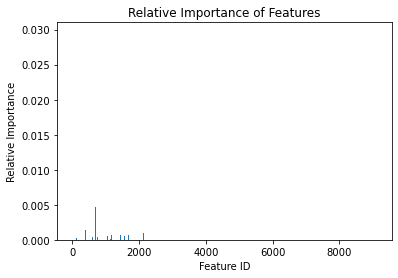

{'SupportType0': 0.003404770568903415, 'SupportType1': 0.005414124642233233, 'SupportType2': 0.011389500802224523, 'SupportType3': 0.013057064557523724, 'SupportType4': 0.012236784495143137, 'SupportType5': 0.012528202526698087, 'SupportType6': 0.012748799654646453, 'SupportType7': 0.0136177315368963, 'SupportType8': 0.023470400968863294, 'SupportType9': 0.011950990740294267, 'SupportType10': 0.01704771612244904, 'SupportType11': 0.02955456564535101, 'SupportType12': 0.009955098417107223, 'SupportType13': 0.018584002638891546, 'SupportType14': 0.011798115071455919, 'SupportType15': 0.014644879534851421, 'SupportType16': 0.01566594544245018, 'SupportType17': 0.009829624837410286, 'SupportType18': 0.020877395525333027, 'SupportType19': 0.009518131097191377, 'SupportType20': 0.014991759805259254, 'SupportMax0': 0.0031872808016847813, 'SupportMax1': 0.006259122003834494, 'SupportMax2': 0.004000090375687323, 'SupportMax3': 0.011256201438516081, 'SupportMax4': 0.003338905619004046, 'SupportM

In [148]:
# define dataset
X = make_X(ft_df)
y = np.array(tmgat1cv_df['umap_KMeans'])
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
features = ft_df.columns[1:]
imp_dict = dict()
# summarize feature importance
for v, name in zip(importance, features):
    print('Feature:', name, 'Score: %.5f' % (v))
    imp_dict[name] = v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Relative Importance of Features')
plt.xlabel('Feature ID')
plt.ylabel('Relative Importance')
plt.show()
print(imp_dict)

#### putting together features from same category

There are 432 total longitudinal variables that we're going to sum their importances.

In [174]:
lfts = [features[ft] for ft in range(0, len(imp_values)-38, 21)]

In [204]:
# feature names
lfts = [features[ft].split('0')[0] for ft in range(0, len(imp_values)-38, 21)]
imp_values = list(imp_dict.values())
lft_sums = [np.sum(np.array(imp_values[i:i+21])) for i in range(0, len(imp_values)-38, 21)]

In [207]:
np.sum(np.array(lft_sums) > 0.0)

87

Now we should definitely note that only 87 of the longitudinal variances have importance over 0.0000.

Adding back in the static variables:

In [196]:
imp_values[-17:], features[-17:]

([0.0037789032697464306,
  0.0,
  0.001377229693883801,
  0.0004073478785144658,
  0.0005656433920601737,
  6.377124095030419e-05,
  0.00040912509400852344,
  0.00042894088006976955,
  0.00041025018973257863,
  4.741430975822347e-06,
  0.010000703004481993,
  0.005699255797326418,
  0.006635924637695455,
  0.009761582886319122,
  0.002142753755595731,
  0.001462473892431216,
  0.005573681620125835],
 Index(['MatAgePreg', 'MaternalFever', 'Pre.eclampsia', 'SmokingRpt',
        'Smoking...1.2.pack.per.day', 'Abruption', 'DiabetesRpt',
        'Insulin.Reported', 'Antenatal.Steroids', 'Chorioamnionitis',
        'BirthWeight', 'GestAge', 'Facility_ID', 'Disch_DSB', 'Gender.Code',
        'Delivery.Code', 'Race.Code'],
       dtype='object'))

In [200]:
features[-17:]

Index(['MatAgePreg', 'MaternalFever', 'Pre.eclampsia', 'SmokingRpt',
       'Smoking...1.2.pack.per.day', 'Abruption', 'DiabetesRpt',
       'Insulin.Reported', 'Antenatal.Steroids', 'Chorioamnionitis',
       'BirthWeight', 'GestAge', 'Facility_ID', 'Disch_DSB', 'Gender.Code',
       'Delivery.Code', 'Race.Code'],
      dtype='object')

From here, it seems that 'MaternalFever' is the only static variable less than 0.0000, so we'll count this as a total of 87 + 16 = 103 variables to rank.

In [205]:
all_fts = lfts + list(features)[-17:]
all_sums = lft_sums + imp_values[-17:]

In [210]:
index_order = np.argsort(all_sums)
top_103 = list(index_order[-101:])
top_103.reverse()
print('Cumulative Variable Importance Over 21 Days')
for i, ind in enumerate(top_103):
    print(i+1, all_fts[ind], ':', '{:0.4f}'.format(all_sums[ind]))

Cumulative Variable Importance Over 21 Days
1 SupportType : 0.2923
2 Weight : 0.1600
3 SupportMax : 0.1192
4 Nystatin : 0.0780
5 Glycerin Suppository : 0.0221
6 Ampicillin : 0.0153
7 Gentamicin : 0.0153
8 Caffeine Citrate : 0.0148
9 Multivitamins with Iron : 0.0142
10 Vancomycin : 0.0130
11 Ferrous Sulfate : 0.0125
12 Fentanyl : 0.0118
13 Bactroban Ointment (Mupirocin) : 0.0107
14 Fluconazole : 0.0101
15 BirthWeight : 0.0100
16 Disch_DSB : 0.0098
17 Lorazepam : 0.0088
18 Vitamin - D3 : 0.0074
19 Aminophylline : 0.0069
20 Facility_ID : 0.0066
21 Dopamine : 0.0060
22 GestAge : 0.0057
23 BBCELOPP : 0.0056
24 Race.Code : 0.0056
25 Tobramycin : 0.0055
26 Amikacin : 0.0052
27 Zidovudine (ZDV, AZT) : 0.0050
28 Midazolam : 0.0044
29 Vitamin - A (Retinyl Palmitate) : 0.0043
30 Indomethacin : 0.0042
31 Nystatin oral : 0.0041
32 Ranitidine : 0.0039
33 MatAgePreg : 0.0038
34 Zinc Oxide : 0.0037
35 Morphine : 0.0035
36 Budesonide : 0.0035
37 FloraTummys : 0.0033
38 Acetaminophen : 0.0032
39 Triviso

In [212]:
index_order = np.argsort(importance)
top_50 = list(index_order[-100:])
top_50.reverse()
print('Top 50 Raw Data Variables Ranked in Importance')
for i, ind in enumerate(top_50):
    print(i+1, features[ind], ':', '{:0.4f}'.format(importance[ind]))

Top 50 Raw Data Variables Ranked in Importance
1 SupportType11 : 0.0296
2 SupportType8 : 0.0235
3 SupportType18 : 0.0209
4 SupportType13 : 0.0186
5 SupportType10 : 0.0170
6 SupportType16 : 0.0157
7 SupportType20 : 0.0150
8 SupportType15 : 0.0146
9 SupportType7 : 0.0136
10 SupportType3 : 0.0131
11 SupportType6 : 0.0127
12 SupportType5 : 0.0125
13 Weight0 : 0.0124
14 SupportType4 : 0.0122
15 SupportType9 : 0.0120
16 SupportType14 : 0.0118
17 SupportType2 : 0.0114
18 SupportMax3 : 0.0113
19 Weight9 : 0.0112
20 Weight7 : 0.0110
21 Weight12 : 0.0107
22 Weight14 : 0.0104
23 Weight4 : 0.0102
24 Weight13 : 0.0102
25 BirthWeight : 0.0100
26 Weight10 : 0.0100
27 SupportType12 : 0.0100
28 SupportType17 : 0.0098
29 Disch_DSB : 0.0098
30 SupportType19 : 0.0095
31 SupportMax19 : 0.0094
32 Weight18 : 0.0091
33 Weight19 : 0.0087
34 SupportMax6 : 0.0085
35 SupportMax20 : 0.0083
36 Weight17 : 0.0080
37 SupportMax11 : 0.0080
38 Weight1 : 0.0075
39 Nystatin1 : 0.0074
40 SupportMax18 : 0.0071
41 Facility_I

### Table Collecting

In [19]:
ntable_df = table_df.merge(tgat1c_pf_df.loc[:, ['PatientSeqID', 'umap_KMeans']])
ntable_df.columns

Index(['PatientSeqID', 'umap_KMeans', 'Gender.Code', 'BirthWeight', 'GestAge',
       'APGAR1', 'APGAR5', 'APGAR10', 'Delivery.Code', 'Race.Code',
       'AliveDied.Transfer', 'Facility_ID', 'Disch_DSB',
       'Daily or DC_Age in Days', 'Post Menstral Age in Days',
       'Support Rank at 36 wks or DC', 'FiO2 at 36 wks or DC',
       'Ventilator support at 36 wks or DC', 'Group', 'Rank Group', 'BPD Text',
       'BPD Grade', 'MatAgePreg', 'MaternalFever', 'Pre.eclampsia',
       'SmokingRpt', 'Smoking...1.2.pack.per.day', 'Abruption', 'DiabetesRpt',
       'Insulin.Reported', 'Antenatal.Steroids', 'Chorioamnionitis'],
      dtype='object')

In [131]:
np.sum(ntable_df.loc[(ntable_df['umap_KMeans'] == 3)]['APGAR5'] < 5)/804

0.046019900497512436

In [98]:
np.sum(table_df.loc[(table_df['BPD Grade'] == 3)]['Antenatal.Steroids'])/286

130.1048951048951

In [340]:
table_df.loc[table_df['BPD Grade'] == 0]['Antenatal.Steroids'].value_counts()

1    11677
0     1675
Name: Antenatal.Steroids, dtype: int64

### Medications

In [89]:
med_cols = list(tg3t1c_dm_df.columns[8:])

In [90]:
dm_counting = tg3t1c_dm_df.groupby('PatientSeqID').sum().sum()
meds_absent = list(dm_counting[dm_counting == 0].index)
meds_present = list(dm_counting[dm_counting != 0].index)
print('total:', len(med_cols))
print('absent:', len(meds_absent))
print('present:', len(meds_present))

total: 430
absent: 167
present: 270


In [91]:
dm_s0 = tg3t1c_dm_df.loc[tg3t1c_dm_df['umap_KMeans'] == 0]
dm_s1 = tg3t1c_dm_df.loc[tg3t1c_dm_df['umap_KMeans'] == 1]

In [92]:
# looking more specifically at subgroups
# S1
s1_counting = dm_s1.loc[:, ['PatientSeqID'] + med_cols].groupby('PatientSeqID').sum().sum()
s1_absent = list(s1_counting[s1_counting == 0].index)
s1_present = list(s1_counting[s1_counting != 0].index)
# S0
s0_counting = dm_s0.loc[:, ['PatientSeqID'] + med_cols].groupby('PatientSeqID').sum().sum()
s0_absent = list(s0_counting[s0_counting == 0].index)
s0_present = list(s0_counting[s0_counting != 0].index)
print('total:', len(med_cols))
print('s1 absent:', len(s1_absent))
print('s1 present:', len(s1_present))
print('s0 absent:', len(s0_absent))
print('s0 present:', len(s0_present))

total: 430
s1 absent: 187
s1 present: 243
s0 absent: 229
s0 present: 201


In [94]:
# generally present in all subgroups
s10_present = set(s1_present) & set(s0_present)
print(len(s10_present))
# present in only one subgroup
s1_only_present = set(s1_present) & set(s0_absent)
s0_only_present = set(s0_present) & set(s1_absent)
# significance analysis
for col in s1_only_present:
    print(dm_s1.groupby('PatientSeqID').sum()[col].value_counts())
# not very significant for any of them

179
0      179
99       1
140      1
88       1
12       1
45       1
66       1
Name: Heparin, dtype: int64
0    184
5      1
Name: Flucytosine (5-FC), dtype: int64
0     182
1       2
24      1
Name: Calcium Supplement, dtype: int64
0     184
28      1
Name: Quinidine, dtype: int64
0    181
1      4
Name: Ketamine, dtype: int64
0    184
2      1
Name: Oxymetazoline, dtype: int64
0    184
9      1
Name: Electrolyte Supplements, dtype: int64
0    184
5      1
Name: Lotrimin, dtype: int64
0     184
15      1
Name: Ketoconazole, dtype: int64
0    180
1      4
6      1
Name: Alteplase (Tissue Plasminogen Activator, t-PA), dtype: int64
0    184
3      1
Name: Cefuroxime, dtype: int64
0    182
1      2
2      1
Name: Sodium Polystyrene Sulfonate (Kayexalate), dtype: int64
0     184
20      1
Name: Lysine, dtype: int64
0     184
19      1
Name: Amphotericin B (Lipid Complex/Liposomal), dtype: int64
0     182
8       1
44      1
3       1
Name: Hydrochlorothiazide Spironolactone, dtype: int64

In [95]:
def freq_separator(df, cols):
    """
    """
    if_cols, fr_cols, ef_cols = list(), list(), list()
    total_ids = len(set(df['PatientSeqID']))
    curr_df = df.groupby('PatientSeqID').mean().reset_index()
    for col in cols:
        curr_s = curr_df[col].value_counts()
        if (0.0 not in curr_s.keys()) or curr_s[0.0]/total_ids <= 0.75:
            ef_cols.append(col)
        elif curr_s[0.0]/total_ids < 0.98:
            fr_cols.append(col)
        else:
            if_cols.append(col)
    return if_cols, fr_cols, ef_cols

In [97]:
# frequency classification
s1_if_cols, s1_fr_cols, s1_ef_cols = freq_separator(dm_s1, s1_present)
s0_if_cols, s0_fr_cols, s0_ef_cols = freq_separator(dm_s0, s0_present)

In [108]:
s1_ef_cols

['Calfactant (Infasurf)',
 'Gentamicin',
 'Caffeine Citrate',
 'Ampicillin',
 'Multivitamins with Iron',
 'Furosemide',
 'Vitamin - K1 (Pytonadione)',
 'Piperacillin+Tazobactum',
 'Ranitidine',
 'Dopamine',
 'Fentanyl',
 'Midazolam',
 'Phenobarbital',
 'Glycerin Suppository',
 'Erythromycin Eye Ointment',
 'Potassium Chloride',
 'Ferrous Sulfate',
 'Acetaminophen',
 'Poractant Alpha (Curosurf)',
 'Morphine',
 'Vancomycin',
 'Chlorothiazide',
 'Insulin',
 'Nitric Oxide (iNO)',
 'Lorazepam',
 'Sodium Chloride',
 'Tobramycin',
 'Indomethacin',
 'Dexamethasone',
 'Cefotaxime',
 'Albuterol',
 'Meropenem',
 'Fluconazole',
 'Ursodiol (Ursodeoxycholic Acid)',
 'Budesonide',
 'Hydrocortisone IV']

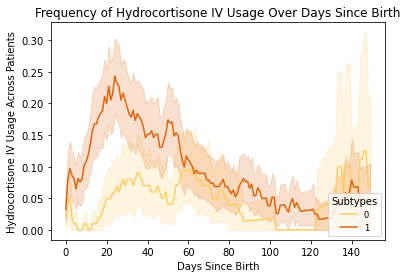

In [68]:
sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y='Hydrocortisone IV', hue='umap_KMeans', palette='YlOrBr')

plt.ylabel('Hydrocortisone IV Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Hydrocortisone IV Usage Over Days Since Birth')
legend = plt.legend(title="Subtypes",
                    loc=4, fontsize='small', fancybox=True)

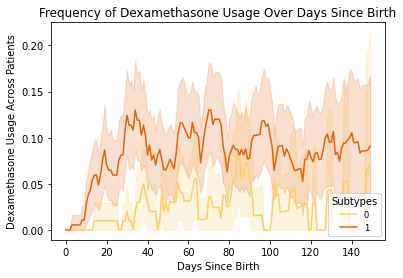

In [69]:
sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y='Dexamethasone', 
             hue='umap_KMeans', palette='YlOrBr')

plt.ylabel('Dexamethasone Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Dexamethasone Usage Over Days Since Birth')
legend = plt.legend(title="Subtypes",
                    loc=4, fontsize='small', fancybox=True)

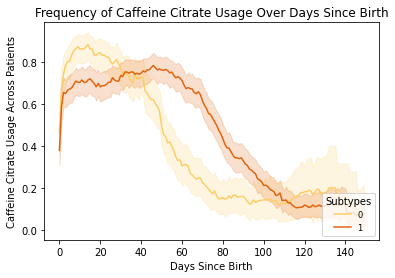

In [70]:
sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y='Caffeine Citrate', 
             hue='umap_KMeans', palette='YlOrBr')

plt.ylabel('Caffeine Citrate Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Caffeine Citrate Usage Over Days Since Birth')
legend = plt.legend(title="Subtypes",
                    loc=4, fontsize='small', fancybox=True)

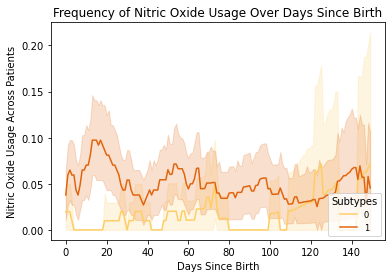

In [71]:
sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y='Nitric Oxide (iNO)', 
             hue='umap_KMeans', palette='YlOrBr')

plt.ylabel('Nitric Oxide Usage Across Patients')
plt.xlabel('Days Since Birth')
plt.title('Frequency of Nitric Oxide Usage Over Days Since Birth')
legend = plt.legend(title="Subtypes",
                    loc=4, fontsize='small', fancybox=True)

<AxesSubplot:xlabel='DSB', ylabel='Phenobarbital'>

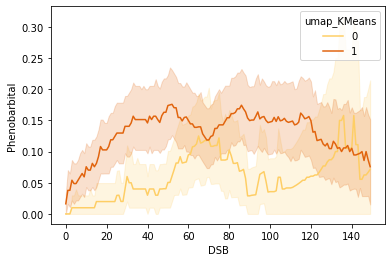

In [114]:
sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y='Phenobarbital', hue='umap_KMeans', palette='YlOrBr')

KeyboardInterrupt: 

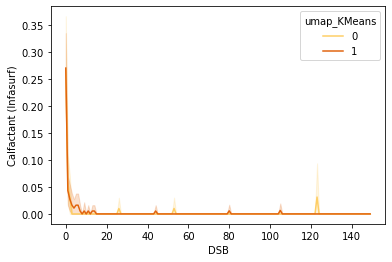

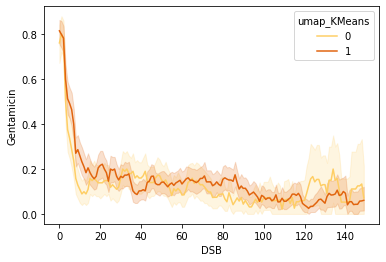

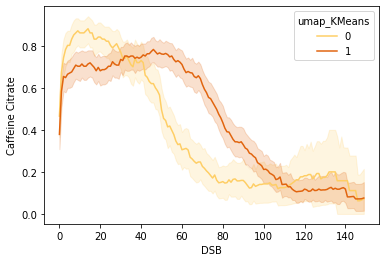

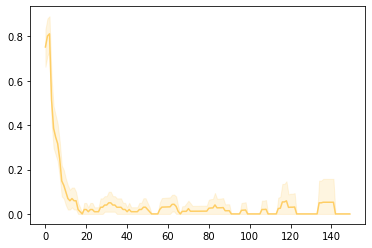

In [111]:
for med in s1_ef_cols:
    colors = ['#7F646C', '#829D58']
    plt.figure()
    sns.lineplot(data=tg3t1c_dm_df.loc[tg3t1c_dm_df['DSB'] < 150], x='DSB', y=med, hue='umap_KMeans', palette='YlOrBr')

In [ ]:
# collecting cluster identities
d1_df = pd.read_csv(CDATA_DIR_PATH + 'new/' + 'tga_d1_c_df.csv')
d1_vdf = pd.read_csv(VDATA_DIR_PATH + 'tga_d1_v_df.csv')
d3_df = pd.read_csv(CDATA_DIR_PATH + 'new/' + 'tga_d3_c_df.csv')
d3_vdf = pd.read_csv(VDATA_DIR_PATH + 'tga_d3_v_df.csv')
d7_df = pd.read_csv(CDATA_DIR_PATH + 'new/' + 'tga_d7_c_df.csv')
d7_vdf = pd.read_csv(VDATA_DIR_PATH + 'tga_d7_v_df.csv')
d14_df = pd.read_csv(CDATA_DIR_PATH + 'new/' + 'tga_d14_c_df.csv')
d14_vdf = pd.read_csv(VDATA_DIR_PATH + 'tga_d14_v_df.csv')
d21_df = pd.read_csv(CDATA_DIR_PATH + 'new/' + 'tga_d21_c_df.csv')
d21_vdf = pd.read_csv(VDATA_DIR_PATH + 'tga_d21_v_df.csv')